本プログラムについては以下のサイトで説明しています。

https://qiita.com/yuki_2020/items/e0352e2c6a56133d2267

# クラスのプログラム

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression


class TestObject:
    
    def __init__(self, csv_dir):
        self.csv_dir = csv_dir
    
    
    def set_specimen(self, widths, thicknesses):
        #試験片幅[mm]
        self.width = np.mean(widths)
        print("平均幅[mm]", self.width) 
        
        #試験片厚さ[mm]
        self.thickness = np.mean(thicknesses)
        print("平均厚さ[mm]",self.thickness) 
        
        #断面積[m^2]
        self.area = self.width * self.thickness * 10**-6
        print("断面積[m^2]", self.area)
        
        
    def set_test_condition(self, gauge_rate, Force_scale, cross_head_scale):
        #ひずみゲージのゲージ率
        self.gauge_rate = gauge_rate
        
        #[N/V]荷重の出力電圧が何Nに対応するか
        self.Force_scale = Force_scale
        
        #[mm/V]クロスヘッド変位の出力電圧が何mmに対応するか
        self.cross_head_scale = cross_head_scale

    

    
    
    def data2data(self):
        #データの読み込み
        
        
        
        
        
        #データの読み込み
        #header=56はcsvの最初のほうの行を無視している　
        #skipfooterはCSVの最後のスキップする行数（適切に指定しないと数字が文字列になってしまう。　また、これを使うためにengine='python'としている）
        self.df = pd.read_csv(self.csv_dir,encoding="shift jis",header=56, skipfooter=3, engine='python')
        print(self.df.dtypes)
        
       

        
        #なぜか数字が文字列になったとき用にfloatに変換
        #for j in range(2,6):
            #self.df.iloc[:,j] = self.df.iloc[:,j].astype(float)
        
        #データの変換
        
        #応力[MPa]
        self.df["stress"] = self.df["(1)HA-V01"] * self.Force_scale / (self.area * 10**6)
        #クロスヘッド変位[mm]
        self.df["cross_head_displacement"] = self.df["(1)HA-V02"] * self.cross_head_scale
        
        #ひずみ[-]マイクロでもなく%でもなく無次元
        self.df["strainL1"] = self.df["(2)ST-CH01"]*2*10**-6/self.gauge_rate
        self.df["strainT1"] = self.df["(2)ST-CH02"]*2*10**-6/self.gauge_rate
        self.df["strainL2"] = self.df["(2)ST-CH03"]*2*10**-6/self.gauge_rate
        self.df["strainT2"] = self.df["(2)ST-CH04"]*2*10**-6/self.gauge_rate
        
        self.df["strainLave"] = (self.df["strainL1"] + self.df["strainL2"])/2
        self.df["strainTave"] = (self.df["strainT1"] + self.df["strainT2"])/2
        
        self.df["poissonLT"] = -1 *self.df["strainTave"] / self.df["strainLave"]
        
        
        





    def get_characteristics(self):
        
        #最大応力表示
        #https://www.self-study-blog.com/dokugaku/python-pandas-dataframe-max-min-describe/
        #https://www.yutaka-note.com/entry/pandas_maxmin
        #最大。最小・平均などをまとめて表示
        self.df_des = self.df.describe()
        print(self.df_des)
        
        
        self.stress_max_index = self.df["stress"].idxmax()
        print("最大応力", self.stress_max_index, "番目　値[MPa]", self.df["stress"][self.stress_max_index])

    
        #弾性率計算
        #ひずみ0.0005と0.0025における引張り応力を使用して弾性率を最小二乗法で回帰する
        
        #i=1から初めて0.0005を超えたら破断後などのデータが混ざらない
        for i in range(len(self.df)):
            if self.df["strainLave"][i] > 0.0005:
                print("i=",i,"ひずみ[-]",self.df["strainLave"][i])
                self.start_reg_index = i
                break
        #i=1から初めて0.0025を超えたら破断後などのデータが混ざらない
        for i in range(len(self.df)):
            if self.df["strainLave"][i] > 0.0025:
                print("i=",i,"ひずみ[-]",self.df["strainLave"][i])
                self.end_reg_index = i
                break
    
    
    
    
    
    
        # 最小二乗法モデルで予測式を求める
        #https://qiita.com/niwasawa/items/400afeb5239e197bb53f
        #https://laid-back-scientist.com/least-squares
        #xに関しては、[[10.0], [8.0], [13.0]]というようにしないといけないのでreshape
        self.model = LinearRegression()
        self.model.fit(np.array(self.df["strainLave"][self.start_reg_index : self.end_reg_index]).reshape(-1, 1) , self.df["stress"][self.start_reg_index : self.end_reg_index])
        #print("弾性率について、傾きが弾性率[MPa]")
        #print('切片:', self.model.intercept_)
        #print('傾き:', self.model.coef_[0])
        print("弾性率[MPa]",self.model.coef_[0])
        
    
    
        #ひずみ0.0005と0.0025における縦ひずみ横ひずみを使用してポワソン比を最小二乗法で回帰する
        self.poisson_model = LinearRegression()
        self.poisson_model.fit(np.array(self.df["strainLave"][self.start_reg_index : self.end_reg_index]).reshape(-1, 1) , self.df["strainTave"][self.start_reg_index : self.end_reg_index])
        #print("ポワソン比について、マイナス傾きがポワソン比[-]")
        #print('切片:', self.poisson_model.intercept_)
        #print('傾き:', self.poisson_model.coef_[0])
        print("ポワソン比[-]",-self.poisson_model.coef_[0])
        
    
    
    
    
    def plot_tmp(self):


        #グラフ描画
        #https://qiita.com/MENDY/items/fe9b0c50383d8b2fd919
        #https://qiita.com/Nick_utuiuc/items/9bf839f5612c54606348
        #https://phst.hateblo.jp/entry/2020/02/28/000000
        #https://qiita.com/M_Kumagai/items/b11de7c9d06b3c43431d
        
        
        #グラフ設定
        
        #フォント設定
        plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
        #plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
        plt.rcParams["font.size"] = 15 # 全体のフォントサイズが変更されます。
        #plt.rcParams['xtick.labelsize'] = 9 # 軸だけ変更されます。
        #plt.rcParams['ytick.labelsize'] = 24 # 軸だけ変更されます
        
        
        
        #軸設定
        plt.rcParams['xtick.direction'] = 'in' # x axis in
        plt.rcParams['ytick.direction'] = 'in' # y axis in 
        #plt.rcParams['axes.grid'] = True # make grid
        #plt.rcParams['grid.linestyle']='--' #グリッドの線種
        plt.rcParams["xtick.minor.visible"] = True  #x軸補助目盛りの追加
        plt.rcParams["ytick.minor.visible"] = True  #y軸補助目盛りの追加
        plt.rcParams['xtick.top'] = True                   #x軸の上部目盛り
        plt.rcParams['ytick.right'] = True                 #y軸の右部目盛り
        
        
        
        #軸大きさ
        #plt.rcParams["xtick.major.width"] = 1.0             #x軸主目盛り線の線幅
        #plt.rcParams["ytick.major.width"] = 1.0             #y軸主目盛り線の線幅
        #plt.rcParams["xtick.minor.width"] = 1.0             #x軸補助目盛り線の線幅
        #plt.rcParams["ytick.minor.width"] = 1.0             #y軸補助目盛り線の線幅
        #plt.rcParams["xtick.major.size"] = 10               #x軸主目盛り線の長さ
        #plt.rcParams["ytick.major.size"] = 10               #y軸主目盛り線の長さ
        #plt.rcParams["xtick.minor.size"] = 5                #x軸補助目盛り線の長さ
        #plt.rcParams["ytick.minor.size"] = 5                #y軸補助目盛り線の長さ
        #plt.rcParams["axes.linewidth"] = 1.0                #囲みの太さ
        
        
        
        
        #凡例設定
        plt.rcParams["legend.fancybox"] = False  # 丸角OFF
        plt.rcParams["legend.framealpha"] = 1  # 透明度の指定、0で塗りつぶしなし
        plt.rcParams["legend.edgecolor"] = 'black'  # edgeの色を変更
        plt.rcParams["legend.markerscale"] = 5 #markerサイズの倍率
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        #グラフ描画テンプレ
        
        strain_names = ["strainL1","strainL2","strainLave","strainT1","strainT2","strainTave"]
        for col_name in strain_names:
            plt.figure(figsize=(7,5),dpi=300)
            plt.plot(self.df[col_name],self.df["stress"], label=col_name,c="k",lw=1)
            plt.xlabel("Strain [-]")
            plt.ylabel("Stress [MPa]")
            plt.legend()
            #plt.title("Template")
            plt.show()
        
        
        
        #応力ひずみ線図 L方向まとめ
        plt.figure(figsize=(7,5),dpi=300)
        plt.plot(self.df["strainL1"],self.df["stress"], label="strainL1",lw=1)
        plt.plot(self.df["strainL2"],self.df["stress"], label="strainL2",lw=1)
        plt.plot(self.df["strainLave"],self.df["stress"], label="strainLave",lw=1)
        plt.xlabel("Strain [-]")
        plt.ylabel("Stress [MPa]")
        plt.legend()
        #plt.title("Template")
        plt.show()
        
        
        
        
        
        #応力ひずみ線図 T方向まとめ
        plt.figure(figsize=(7,5),dpi=300)
        plt.plot(self.df["strainT1"],self.df["stress"], label="strainT1",lw=1)
        plt.plot(self.df["strainT2"],self.df["stress"], label="strainT2",lw=1)
        plt.plot(self.df["strainTave"],self.df["stress"], label="strainTave",lw=1)
        plt.xlabel("Strain [-]")
        plt.ylabel("Stress [MPa]")
        plt.legend()
        #plt.title("Template")
        plt.show()
        
        
        
        #ポワソン比
        plt.figure(figsize=(7,5),dpi=300)
        plt.plot(self.df["strainLave"],self.df["strainTave"], label="poissonLT",c="k",lw=1)
        plt.xlabel("StrainL [-]")
        plt.ylabel("StrainT [-]")
        plt.legend()
        #plt.title("Template")
        plt.show()
        
        #ポワソン比の縦ひずみ変化
        plt.figure(figsize=(7,5),dpi=300)
        plt.plot(self.df["strainLave"],self.df["poissonLT"], label="PoissonLT",c="k",lw=1)
        plt.xlabel("StrainL [-]")
        plt.ylabel("PoissonLT")
        plt.legend()
        #plt.title("Template")
        plt.show()
        
        
        
        
        
        
        
        
        
        

        
        #弾性率のグラフ
        x = np.arange(0.0005, 0.0025, 0.00001)
        y = self.model.predict(x.reshape(-1, 1))
        
        # 可視化 ひずみ0.0005と0.0025における
        plt.figure(figsize=(7,5),dpi=300)
        plt.scatter(self.df["strainLave"][self.start_reg_index : self.end_reg_index] , self.df["stress"][self.start_reg_index : self.end_reg_index], s=1, c='k')
        plt.plot(x, y, c='r')
        plt.xlabel("Strain [-]")
        plt.ylabel("Stress [MPa]")
        #plt.title("Template")
        plt.show()
        
        # 可視化　全体
        plt.figure(figsize=(7,5),dpi=300)
        plt.scatter(self.df["strainLave"] , self.df["stress"], s=1, c='k')
        plt.plot(x, y, c='r')
        plt.xlabel("Strain [-]")
        plt.ylabel("Stress [MPa]")
        #plt.title("Template")
        plt.show()
        
        
        
        
        
        
        

        #ポアソン比のグラフ
        x = np.arange(0.0005, 0.0025, 0.00001)
        y = self.poisson_model.predict(x.reshape(-1, 1))
        
        # 可視化 ひずみ0.0005と0.0025における
        plt.figure(figsize=(7,5),dpi=300)
        plt.scatter(self.df["strainLave"][self.start_reg_index : self.end_reg_index] , self.df["strainTave"][self.start_reg_index : self.end_reg_index], s=1, c='k')
        plt.plot(x, y, c='r')
        plt.xlabel("StrainL [-]")
        plt.ylabel("StrainT [-]")
        #plt.title("Template")
        plt.show()
        
        # 可視化　全体
        plt.figure(figsize=(7,5),dpi=300)
        plt.scatter(self.df["strainLave"] , self.df["strainTave"], s=1, c='k')
        plt.plot(x, y, c='r')
        plt.xlabel("StrainL [-]")
        plt.ylabel("StrainT [-]")
        #plt.title("Template")
        plt.show()
        
    
    
    def do_set(self):
        self.data2data()
        self.get_characteristics()
        self.plot_tmp()

# クラスを使用したグラフの作成

平均幅[mm] 14.966666666666669
平均厚さ[mm] 1.3166666666666669
断面積[m^2] 1.9706111111111117e-05
#EndHeader     object
日時(μs)          int64
(1)HA-V01     float64
(1)HA-V02     float64
(2)ST-CH01    float64
(2)ST-CH02    float64
(2)ST-CH03    float64
(2)ST-CH04    float64
dtype: object


              日時(μs)   (1)HA-V01   (1)HA-V02    (2)ST-CH01   (2)ST-CH02  \
count     300.000000  300.000000  300.000000    300.000000   300.000000   
mean   499000.000000    0.049699    0.016992   7355.320000 -2234.435000   
std    287708.045999    0.029225    0.009714   4651.025776  1313.454892   
min     49000.000000    0.000000    0.001100    -10.500000 -4368.000000   
25%    249000.000000    0.024350    0.008400   3262.875000 -3383.625000   
50%    499000.000000    0.052150    0.017400   7392.000000 -2304.750000   
75%    749000.000000    0.075775    0.025200  11397.750000 -1107.750000   
max    949000.000000    0.094400    0.034000  15225.000000     0.000000   

         (2)ST-CH03   (2)ST-CH04      stress  cross_head_displacement  \
count    300.000000   300.000000  300.000000               300.000000   
mean    7460.320000 -2129.435000   25.220249                 0.169917   
std     4651.025776  1313.454892   14.830384                 0.097140   
min       94.500000 -4263.000000

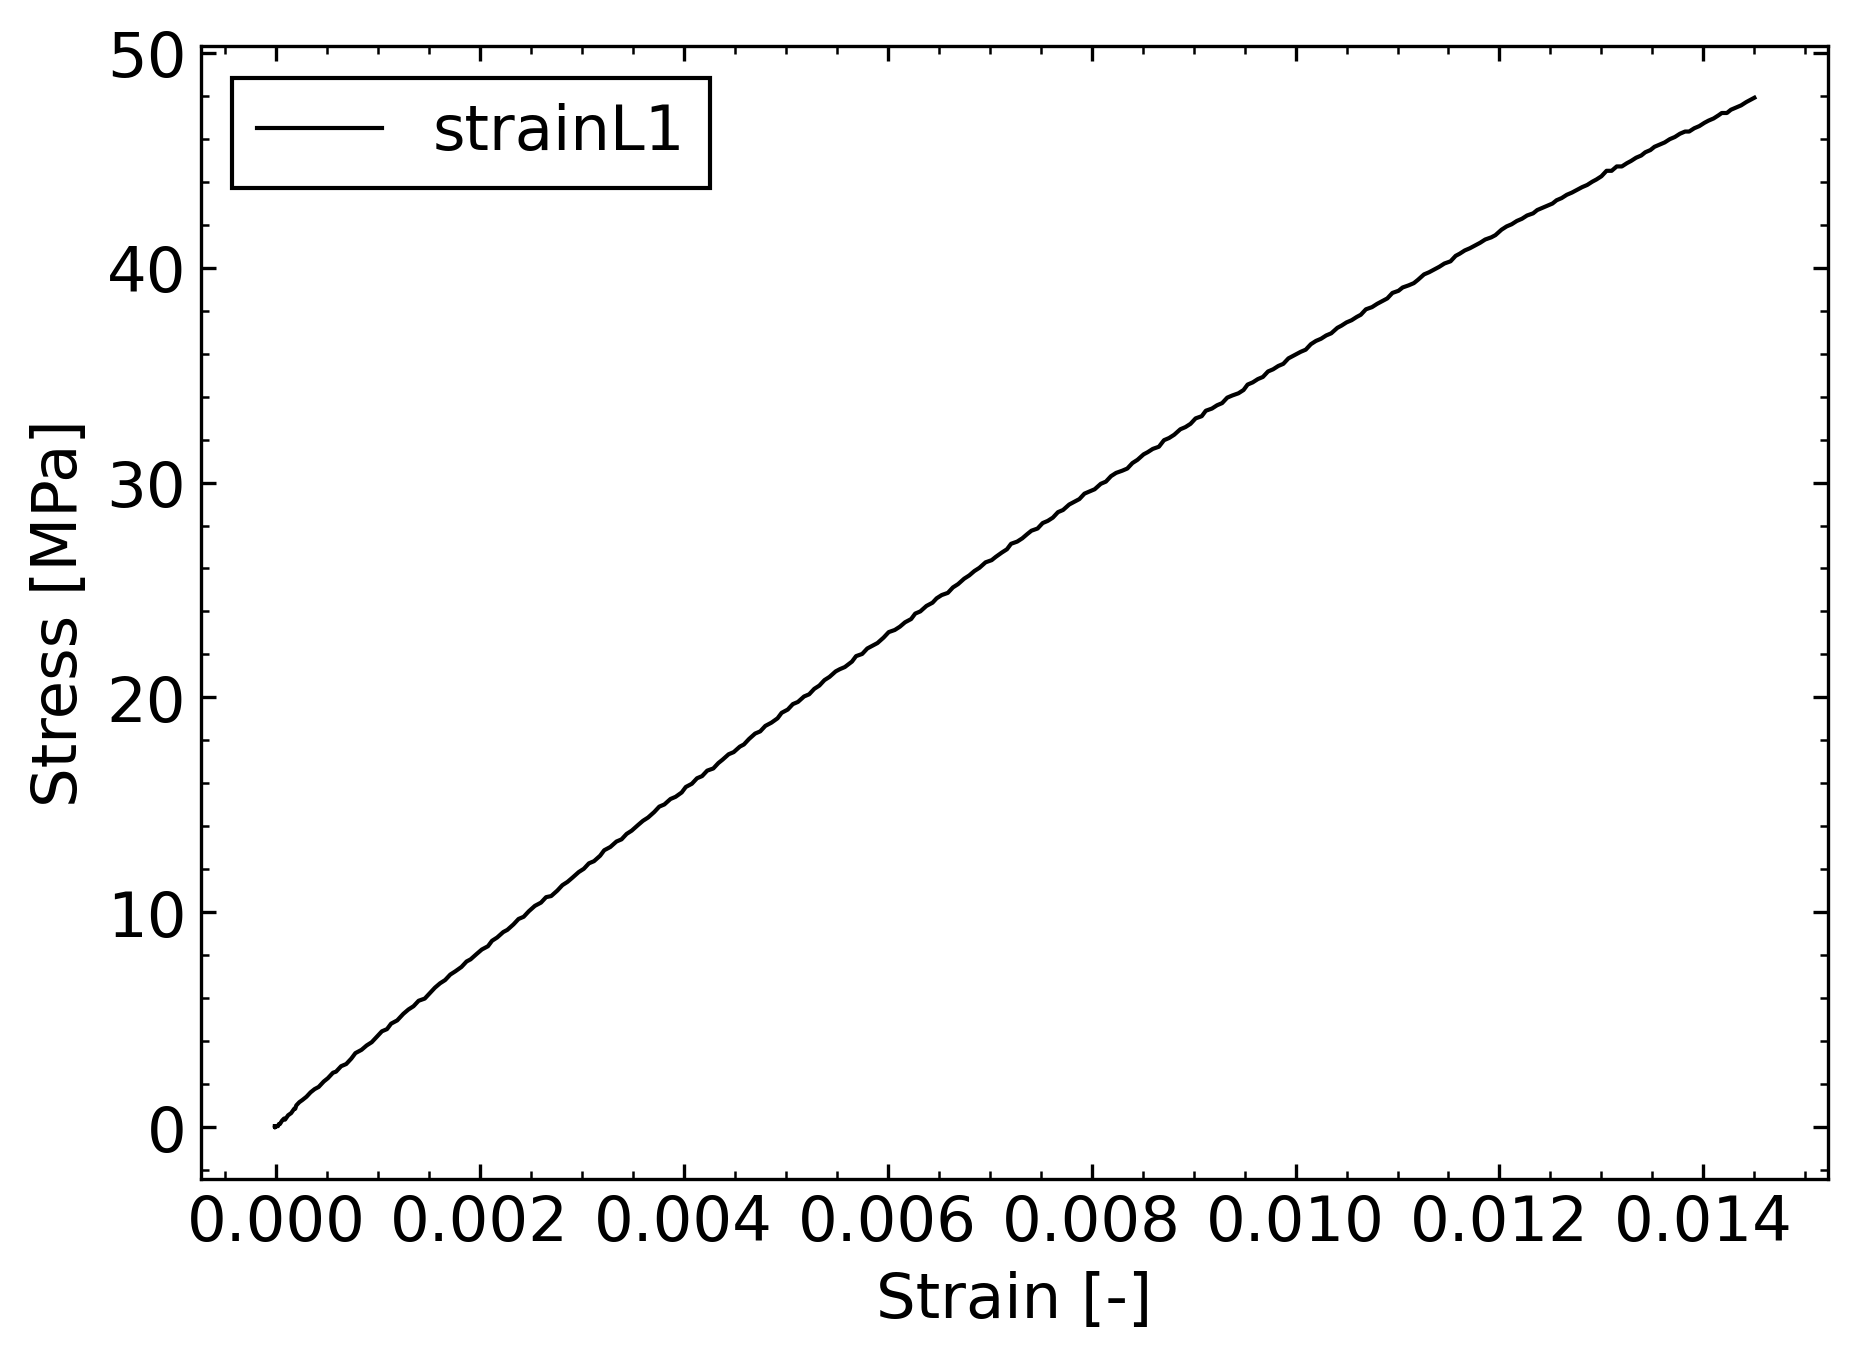

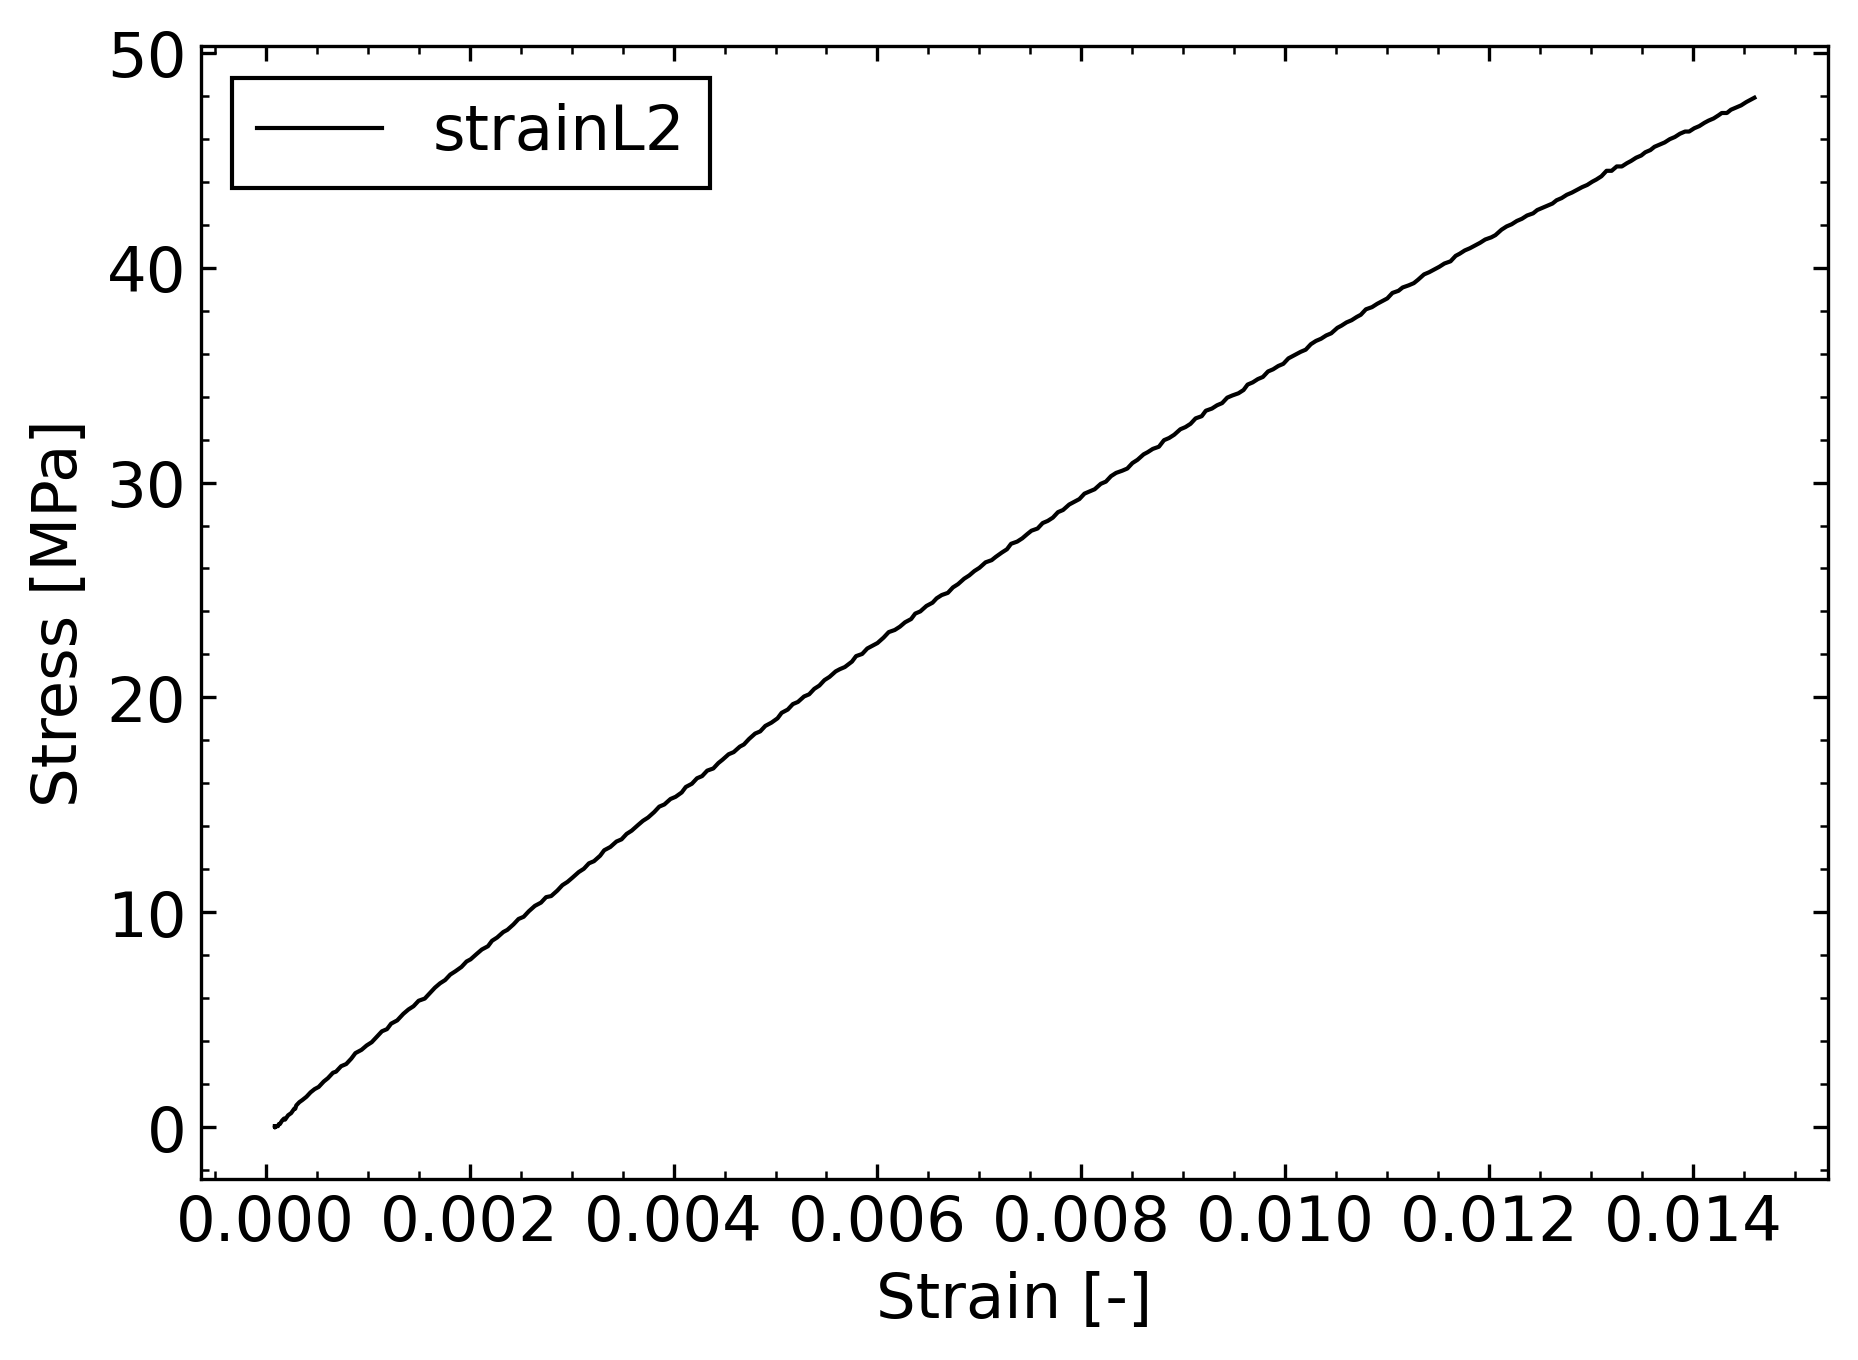

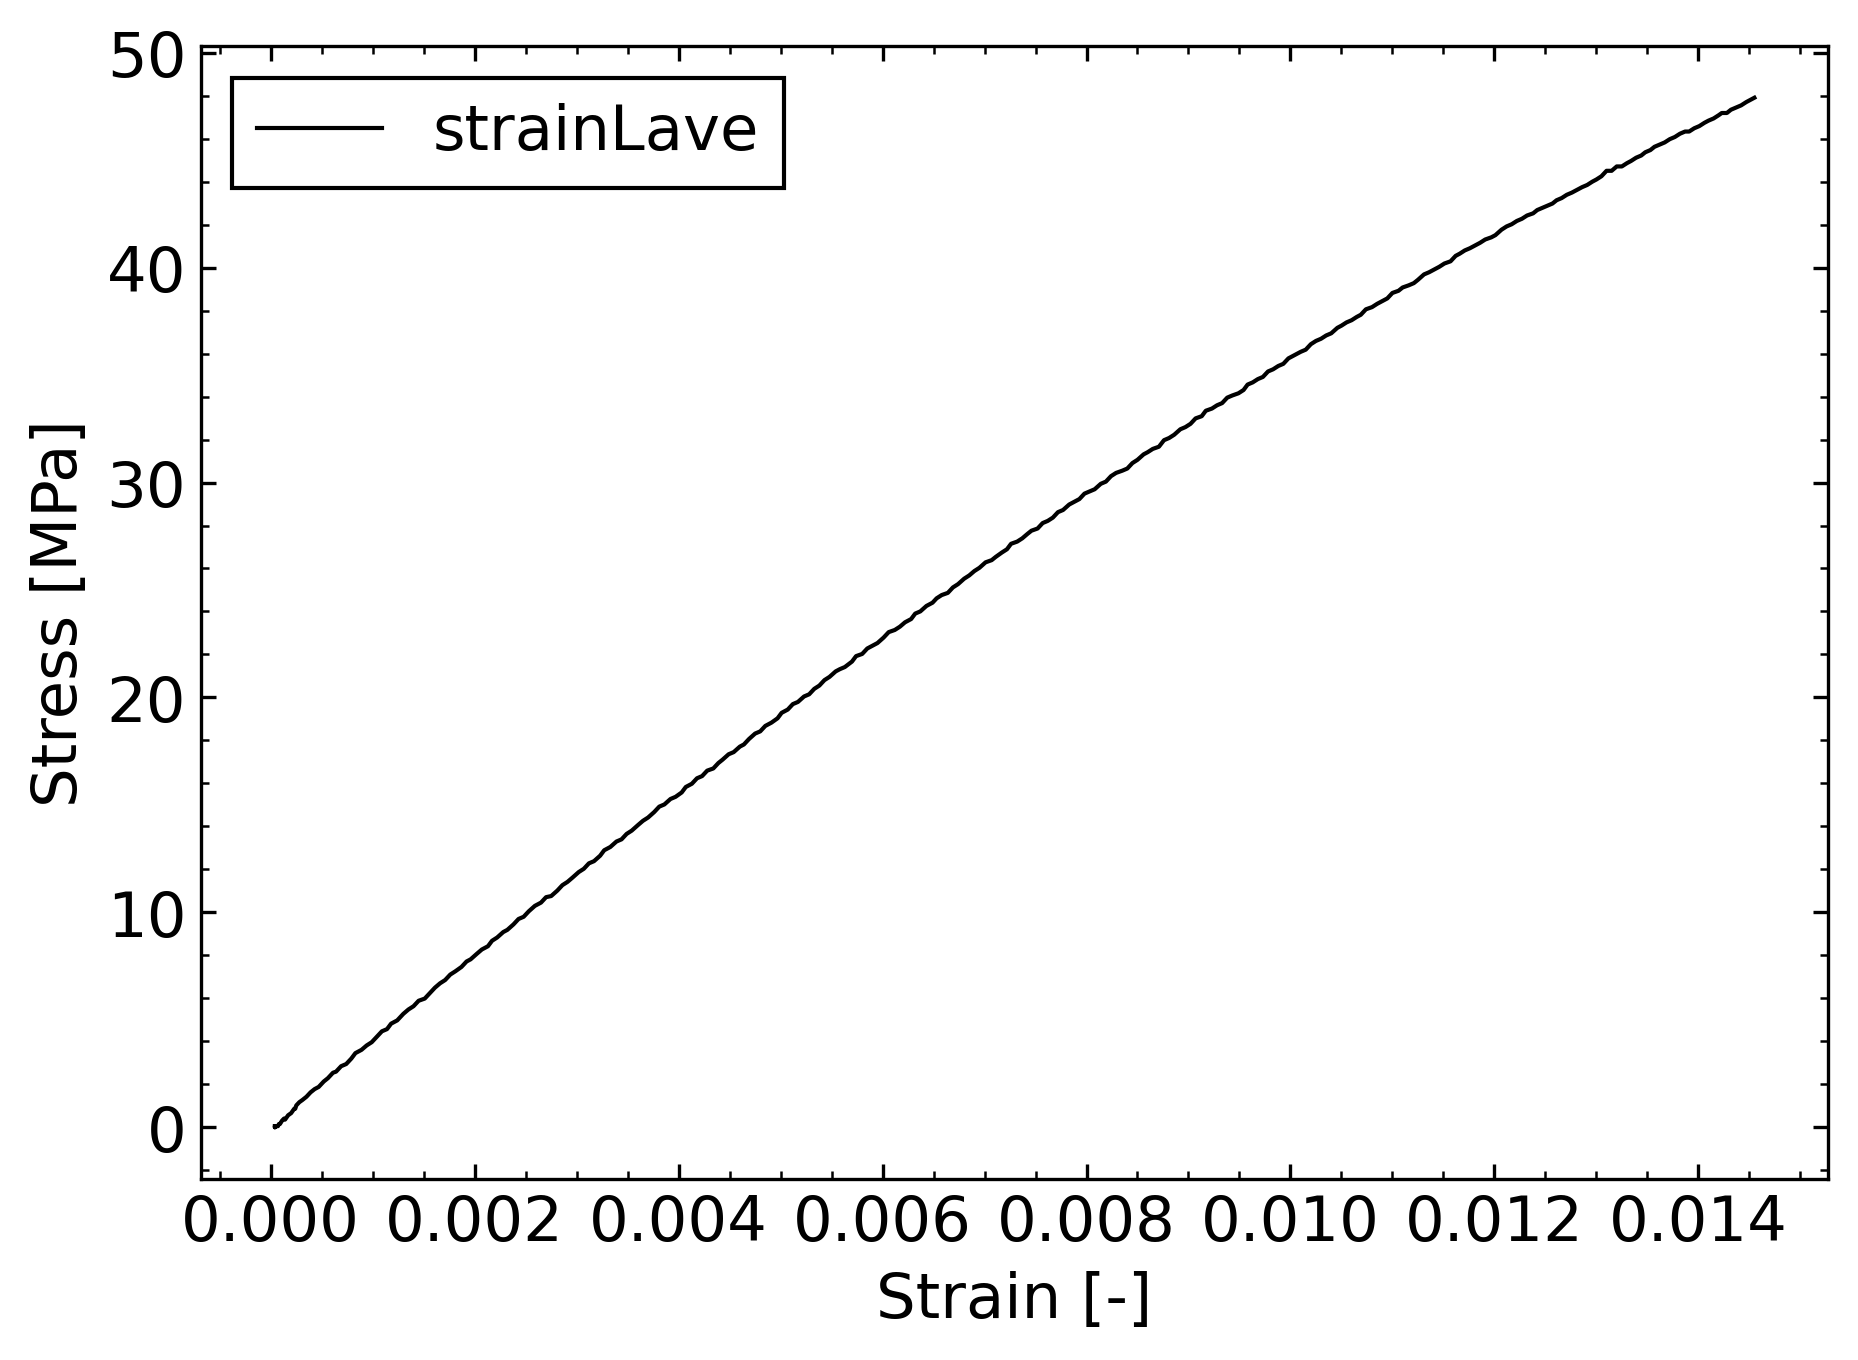

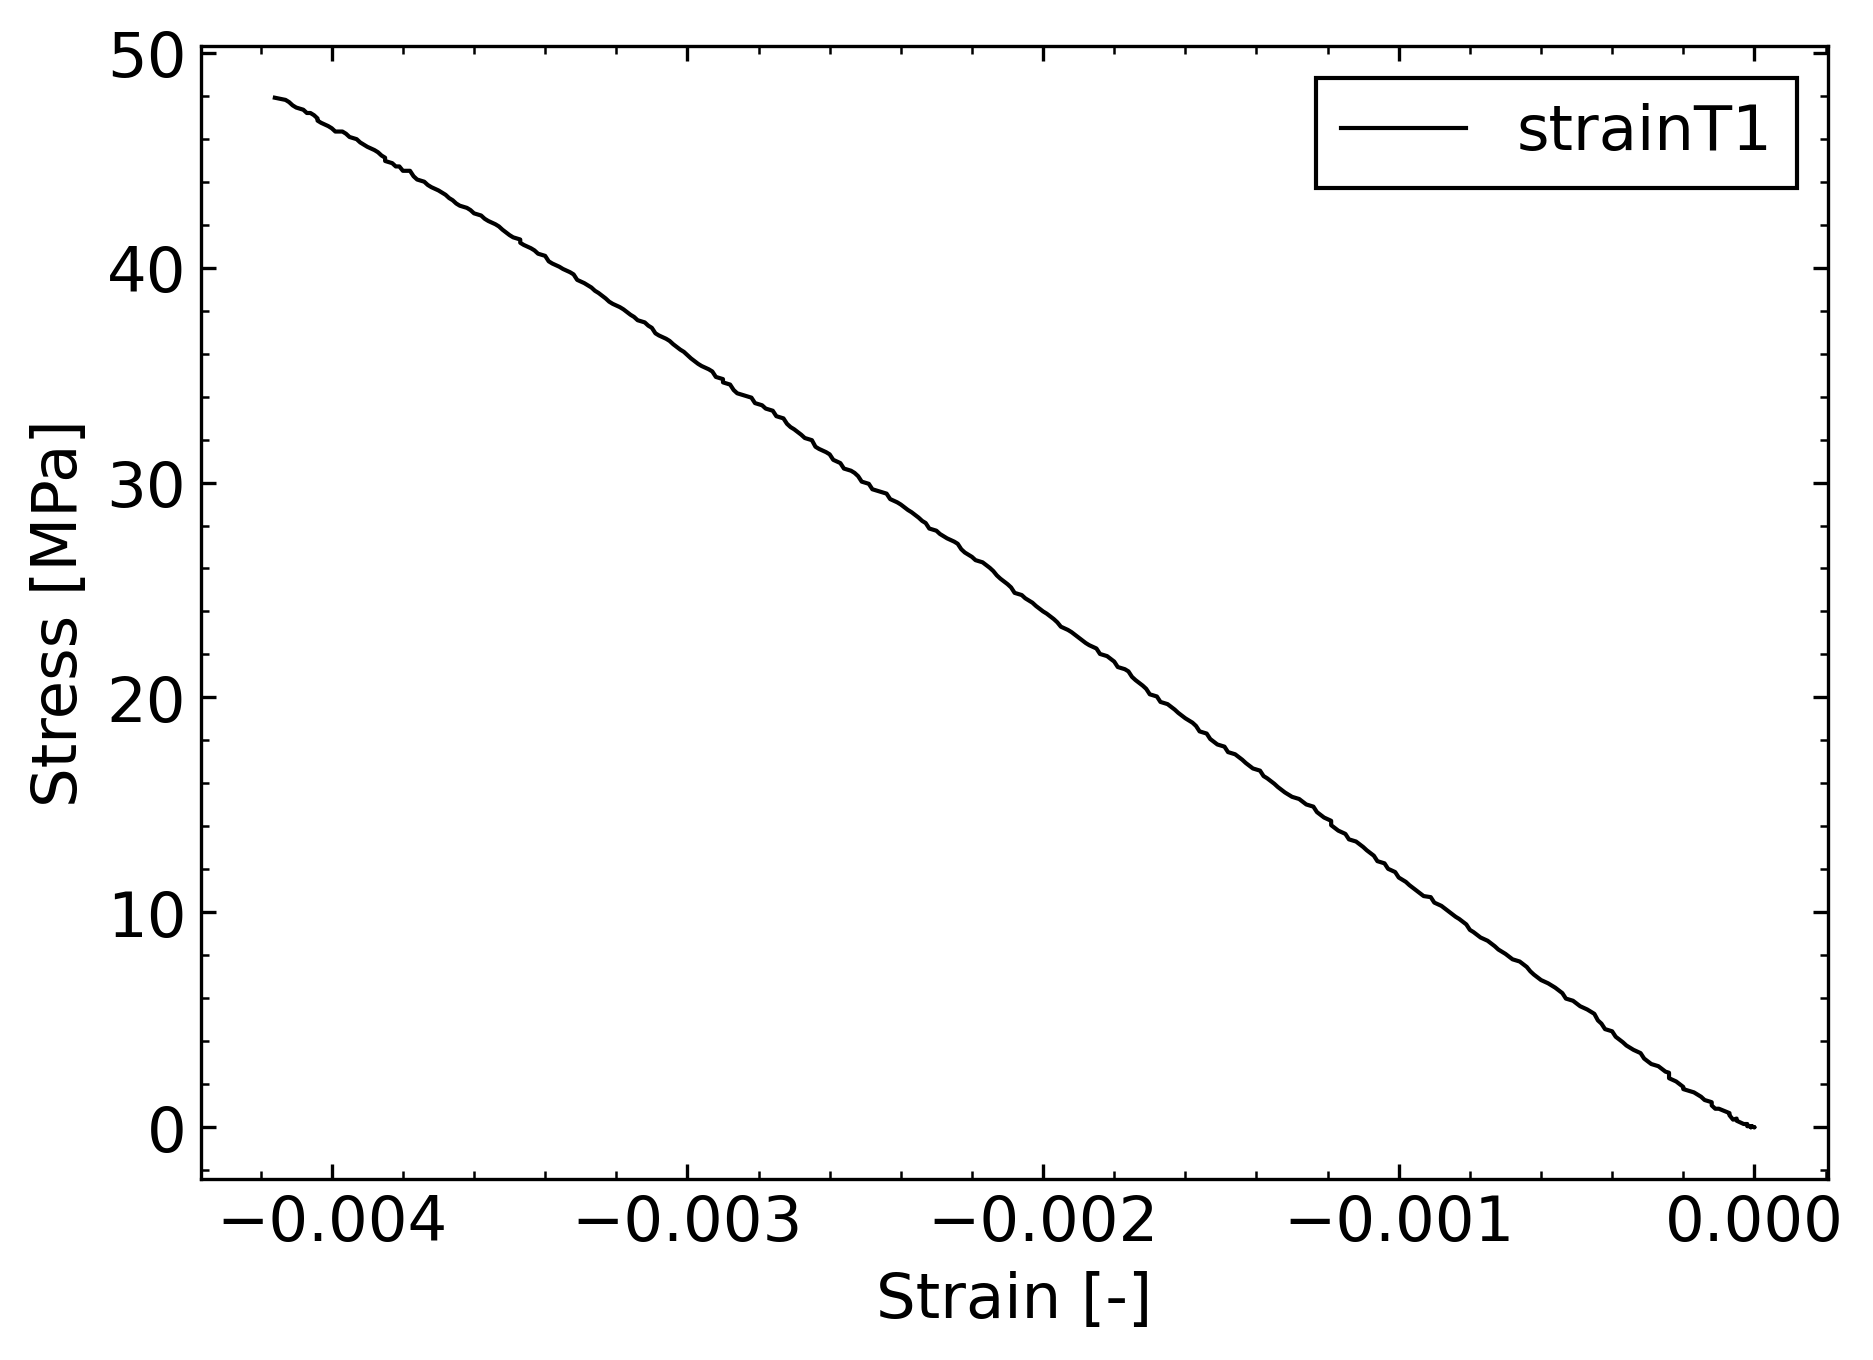

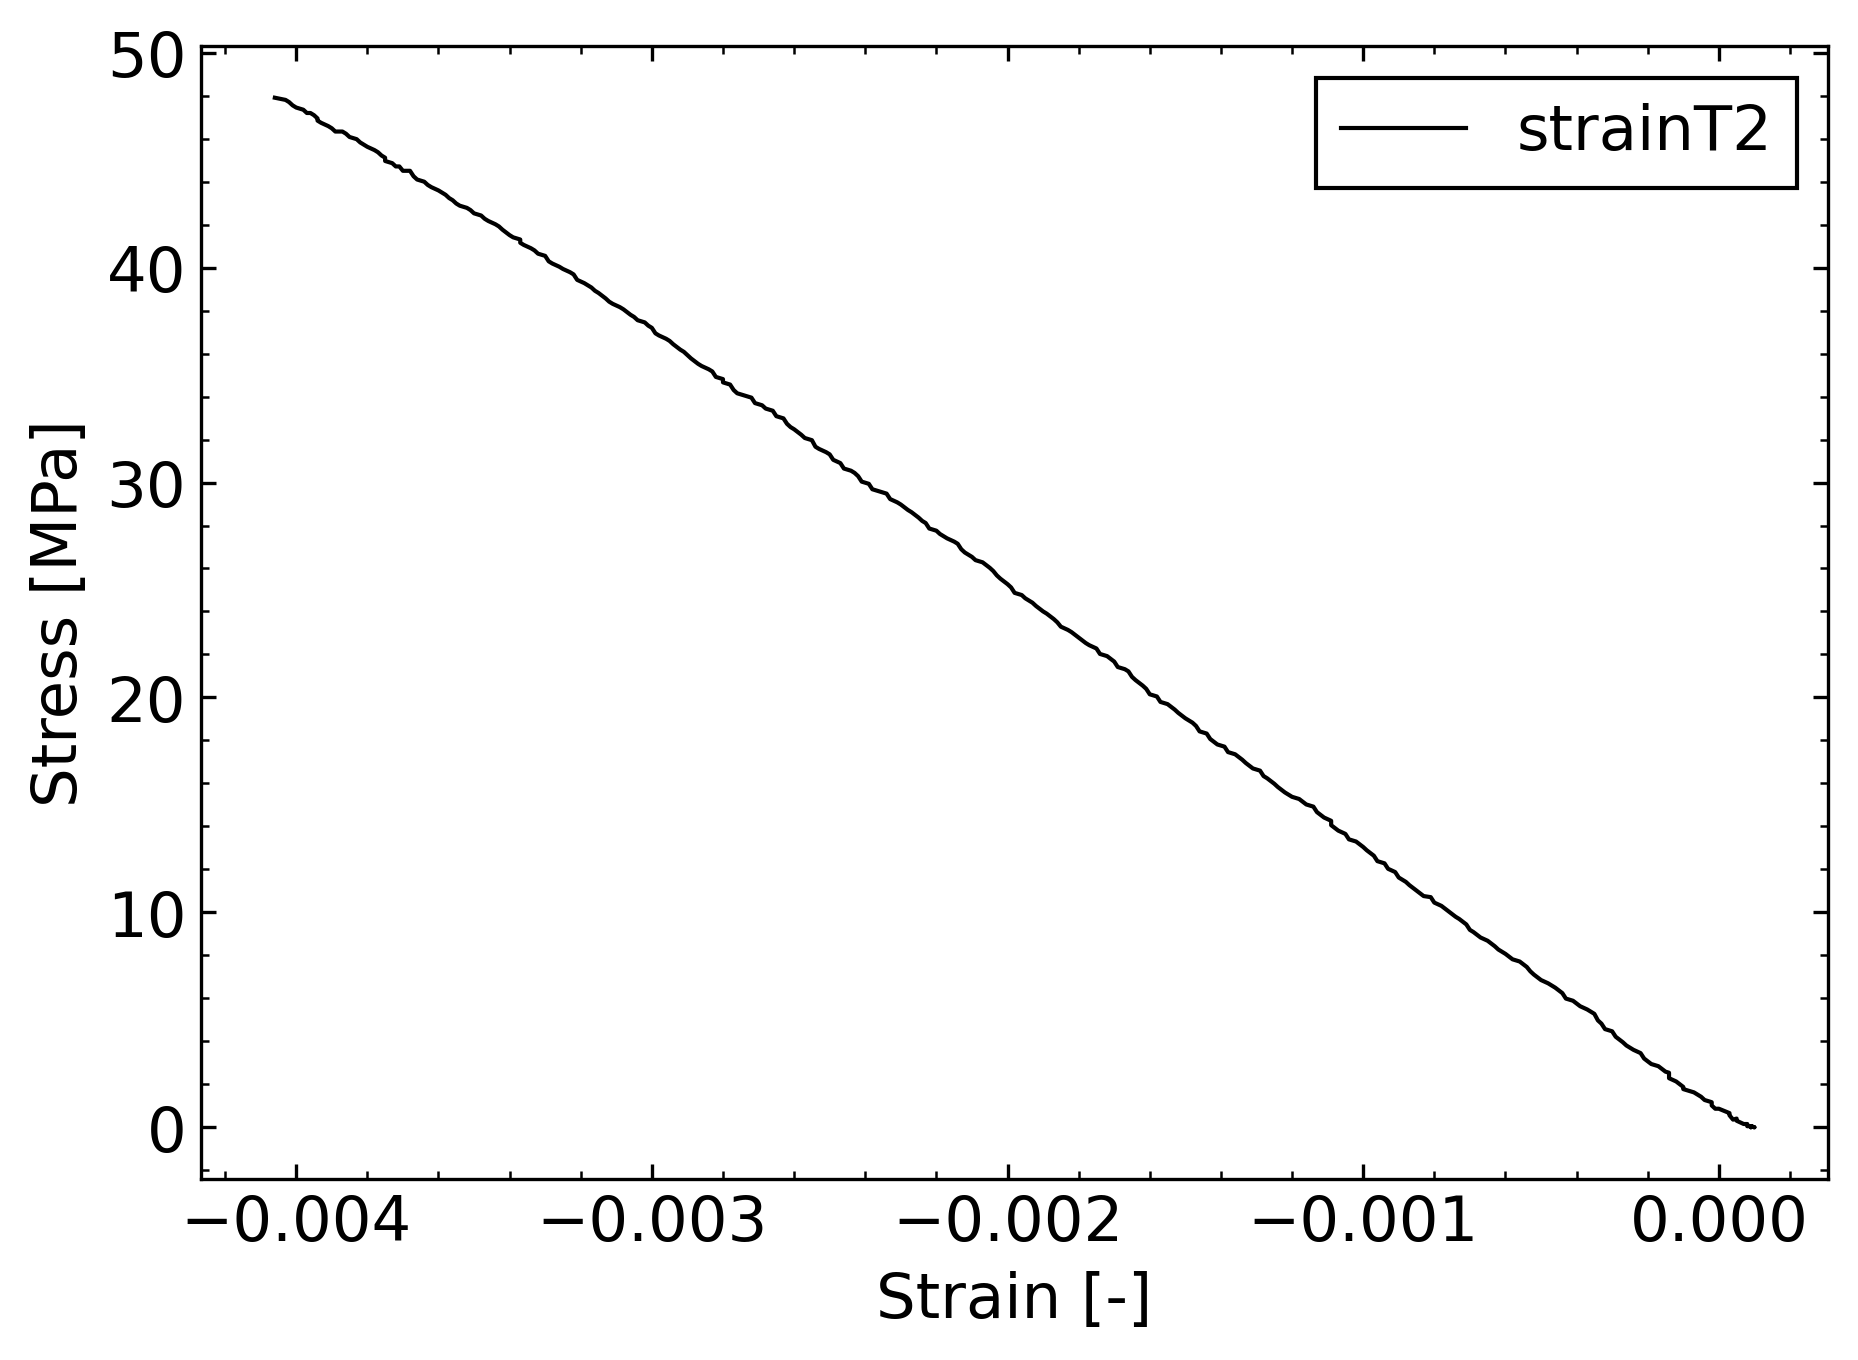

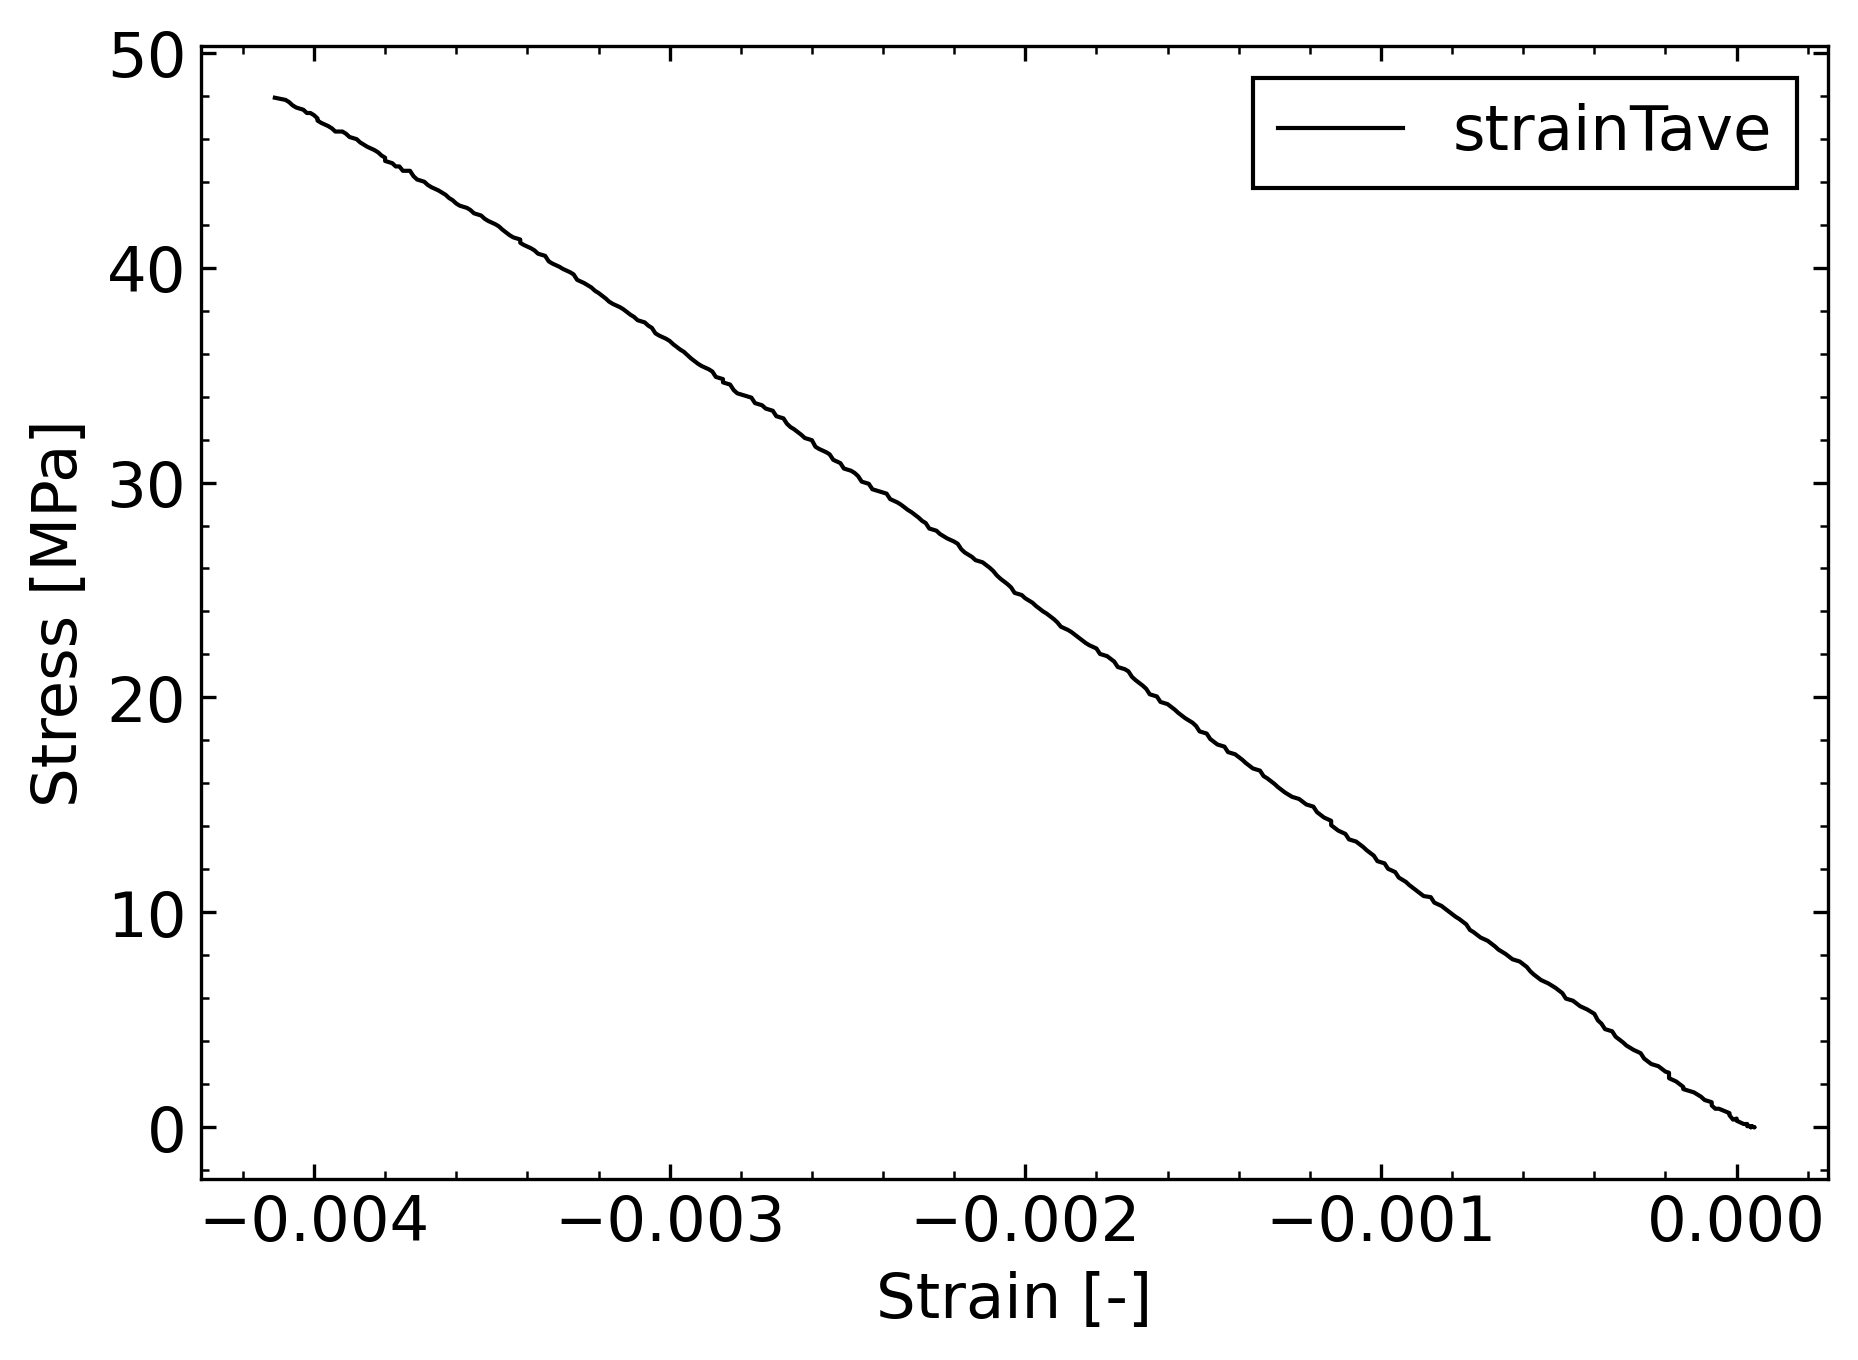

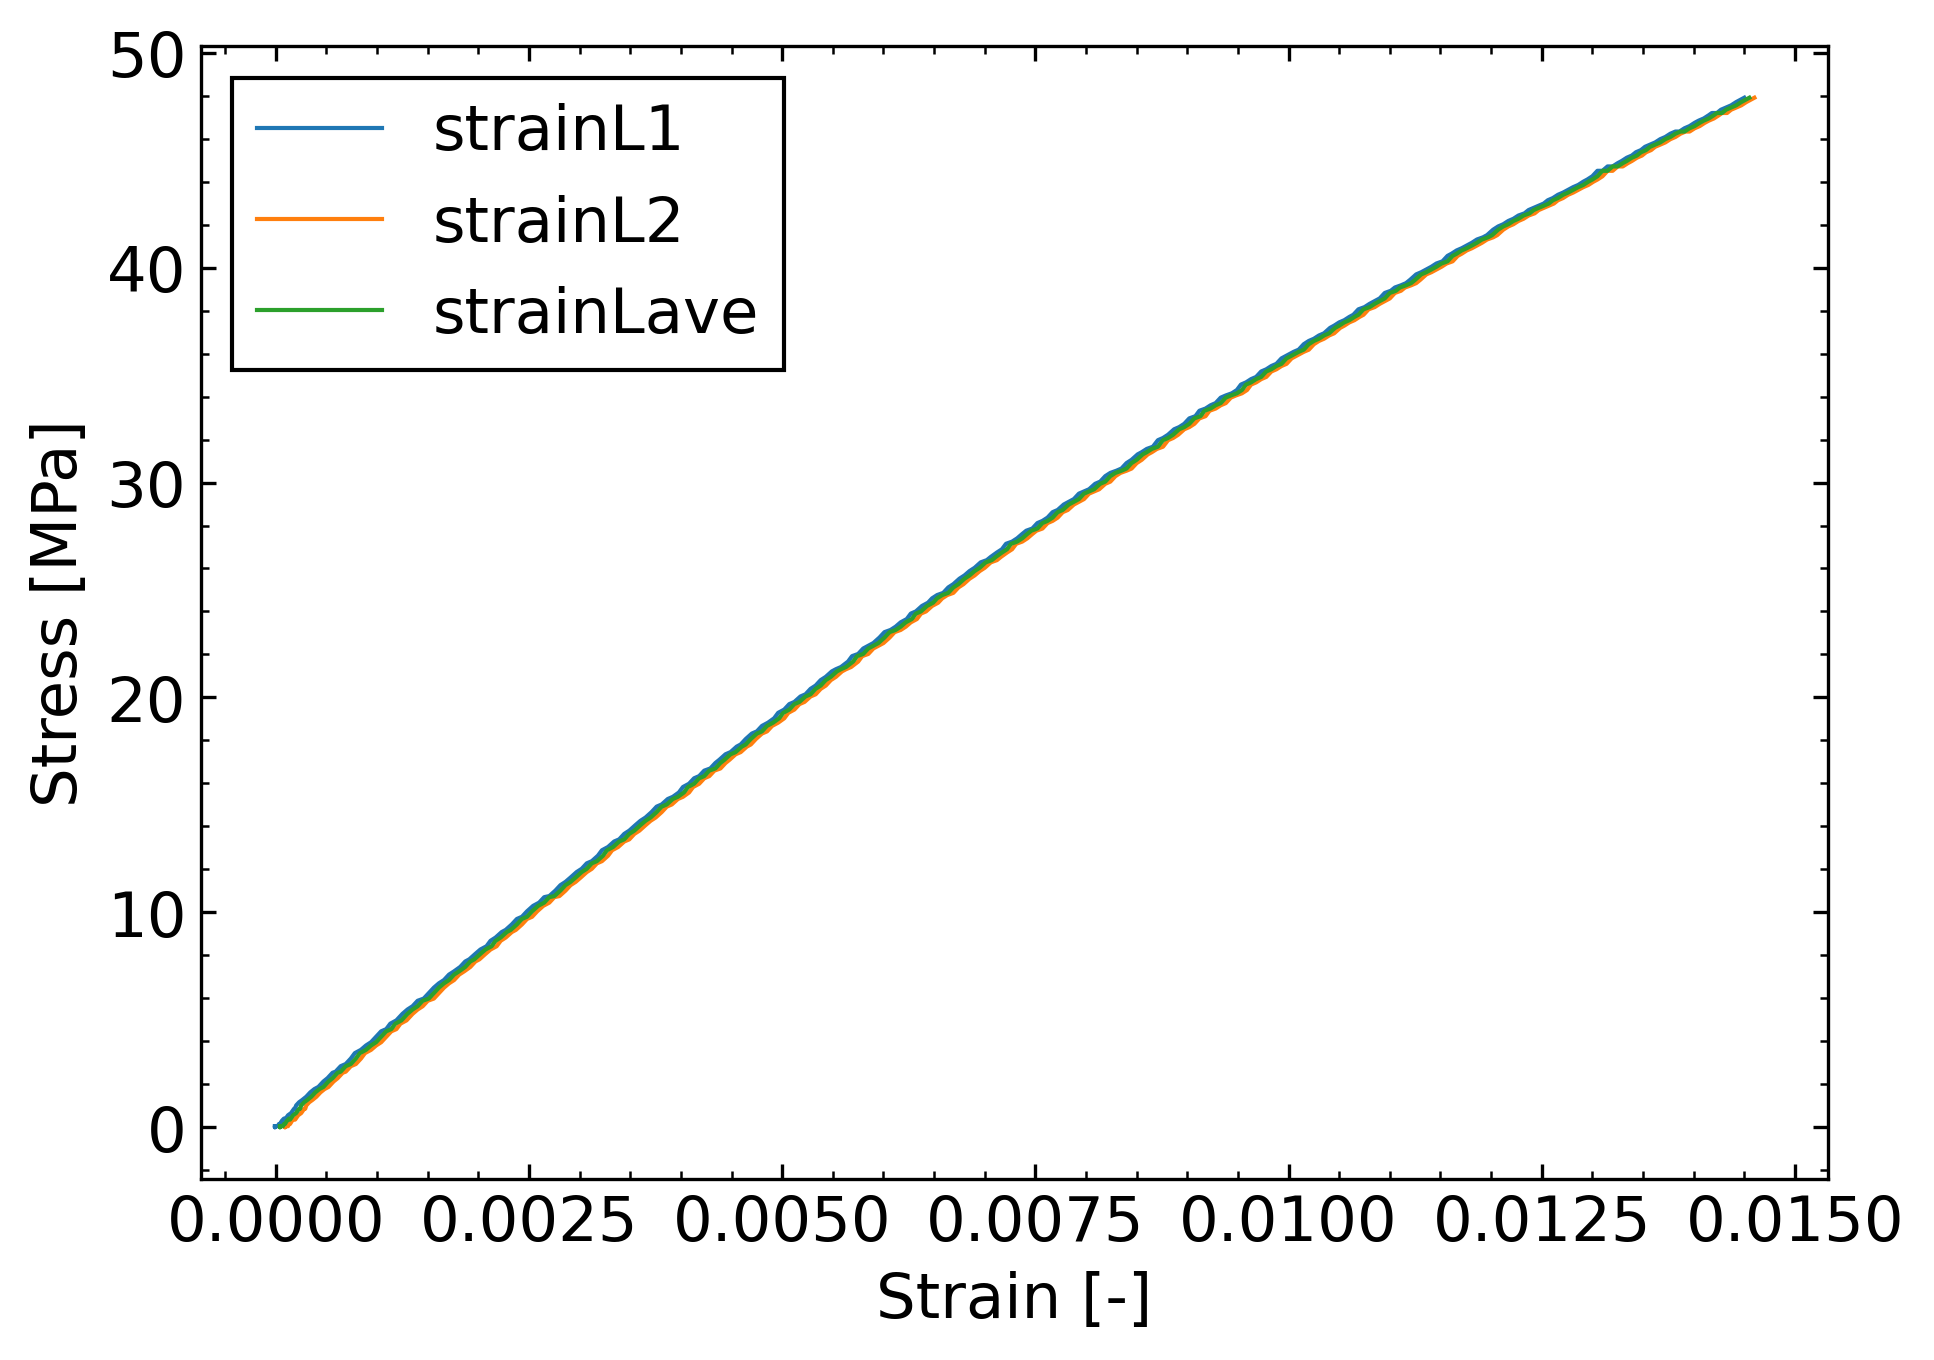

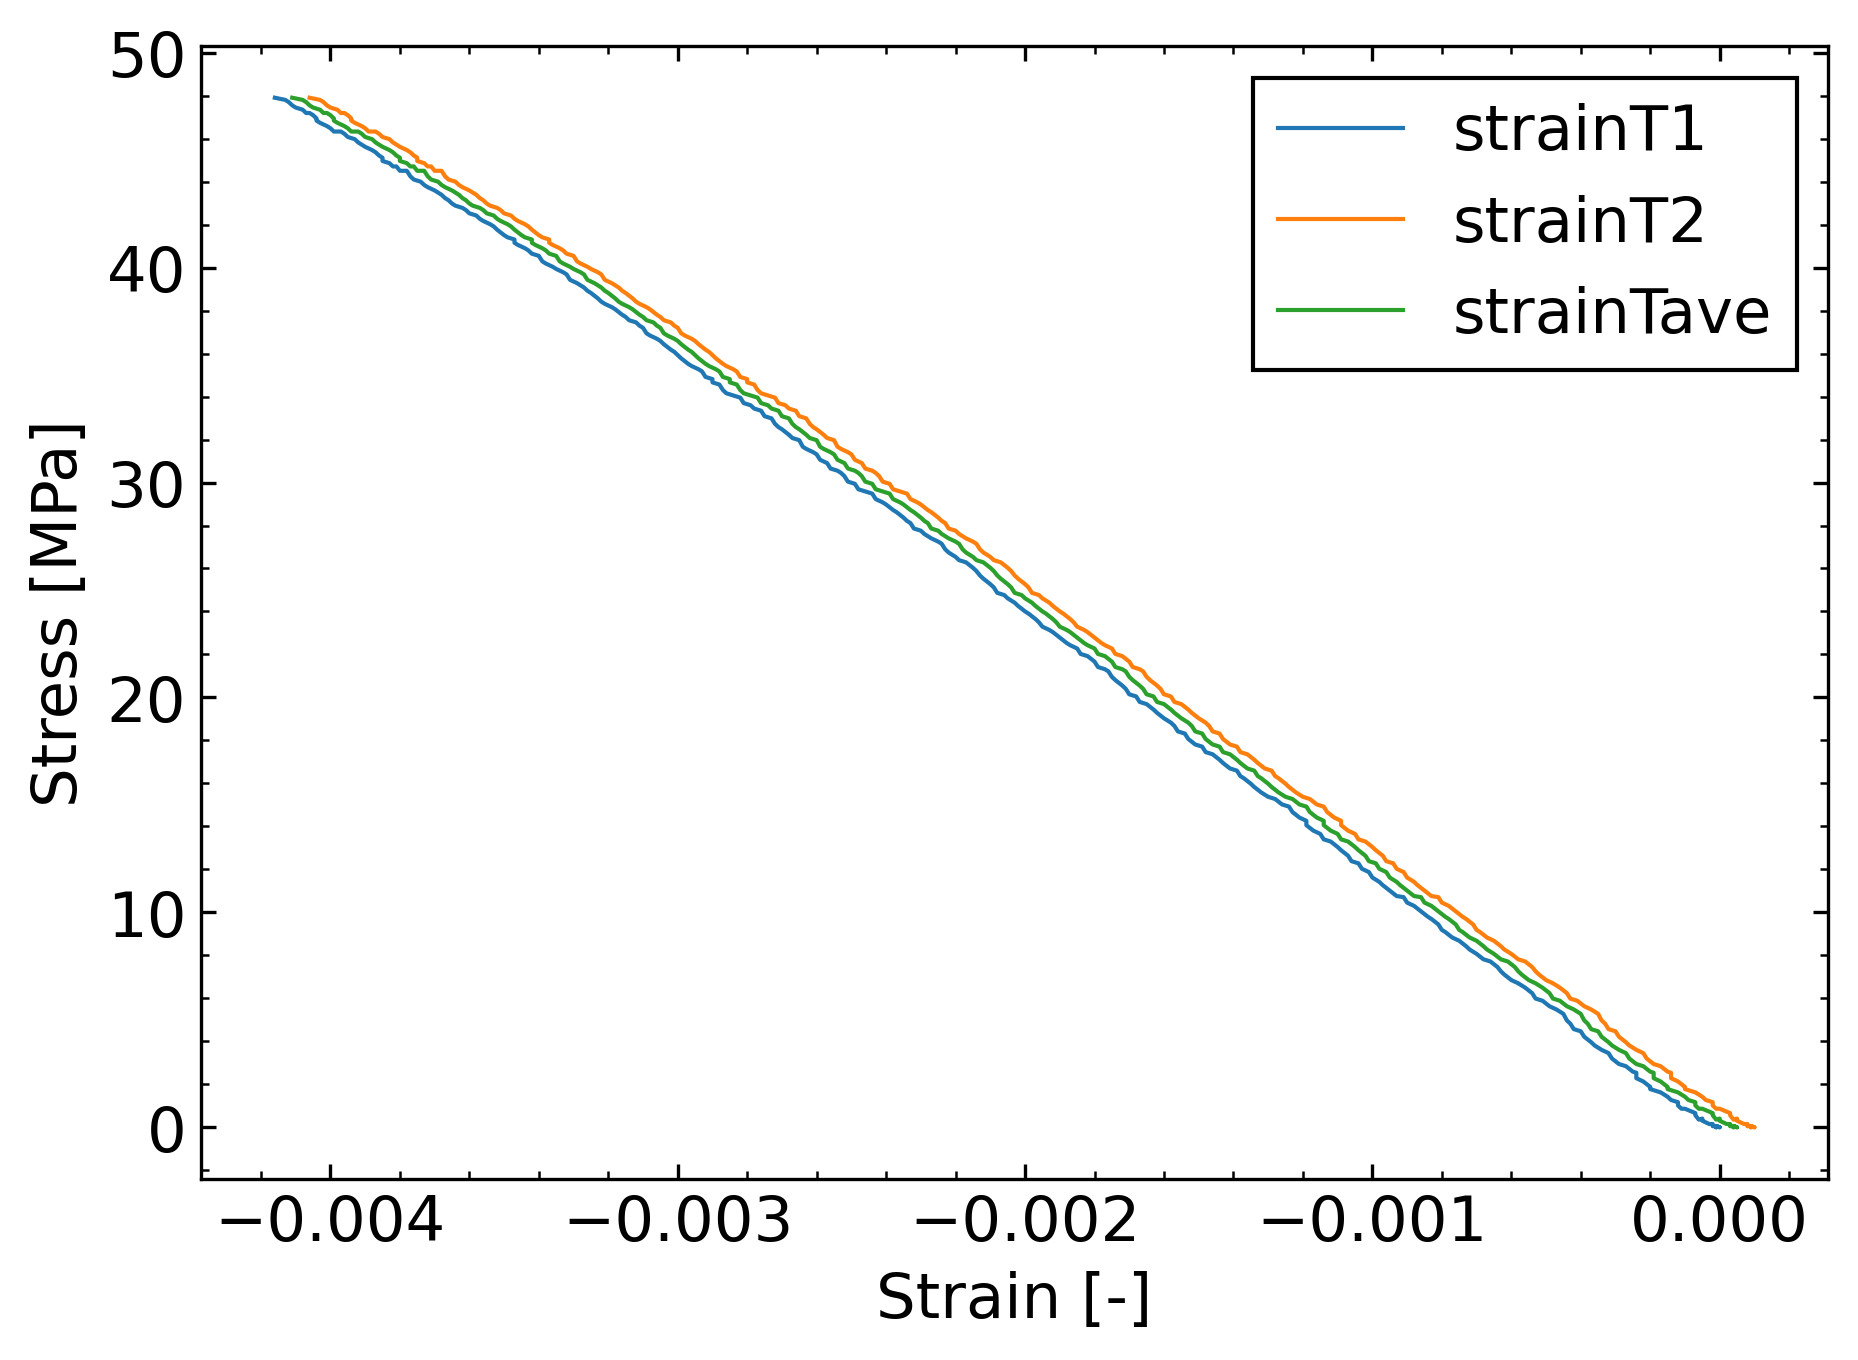

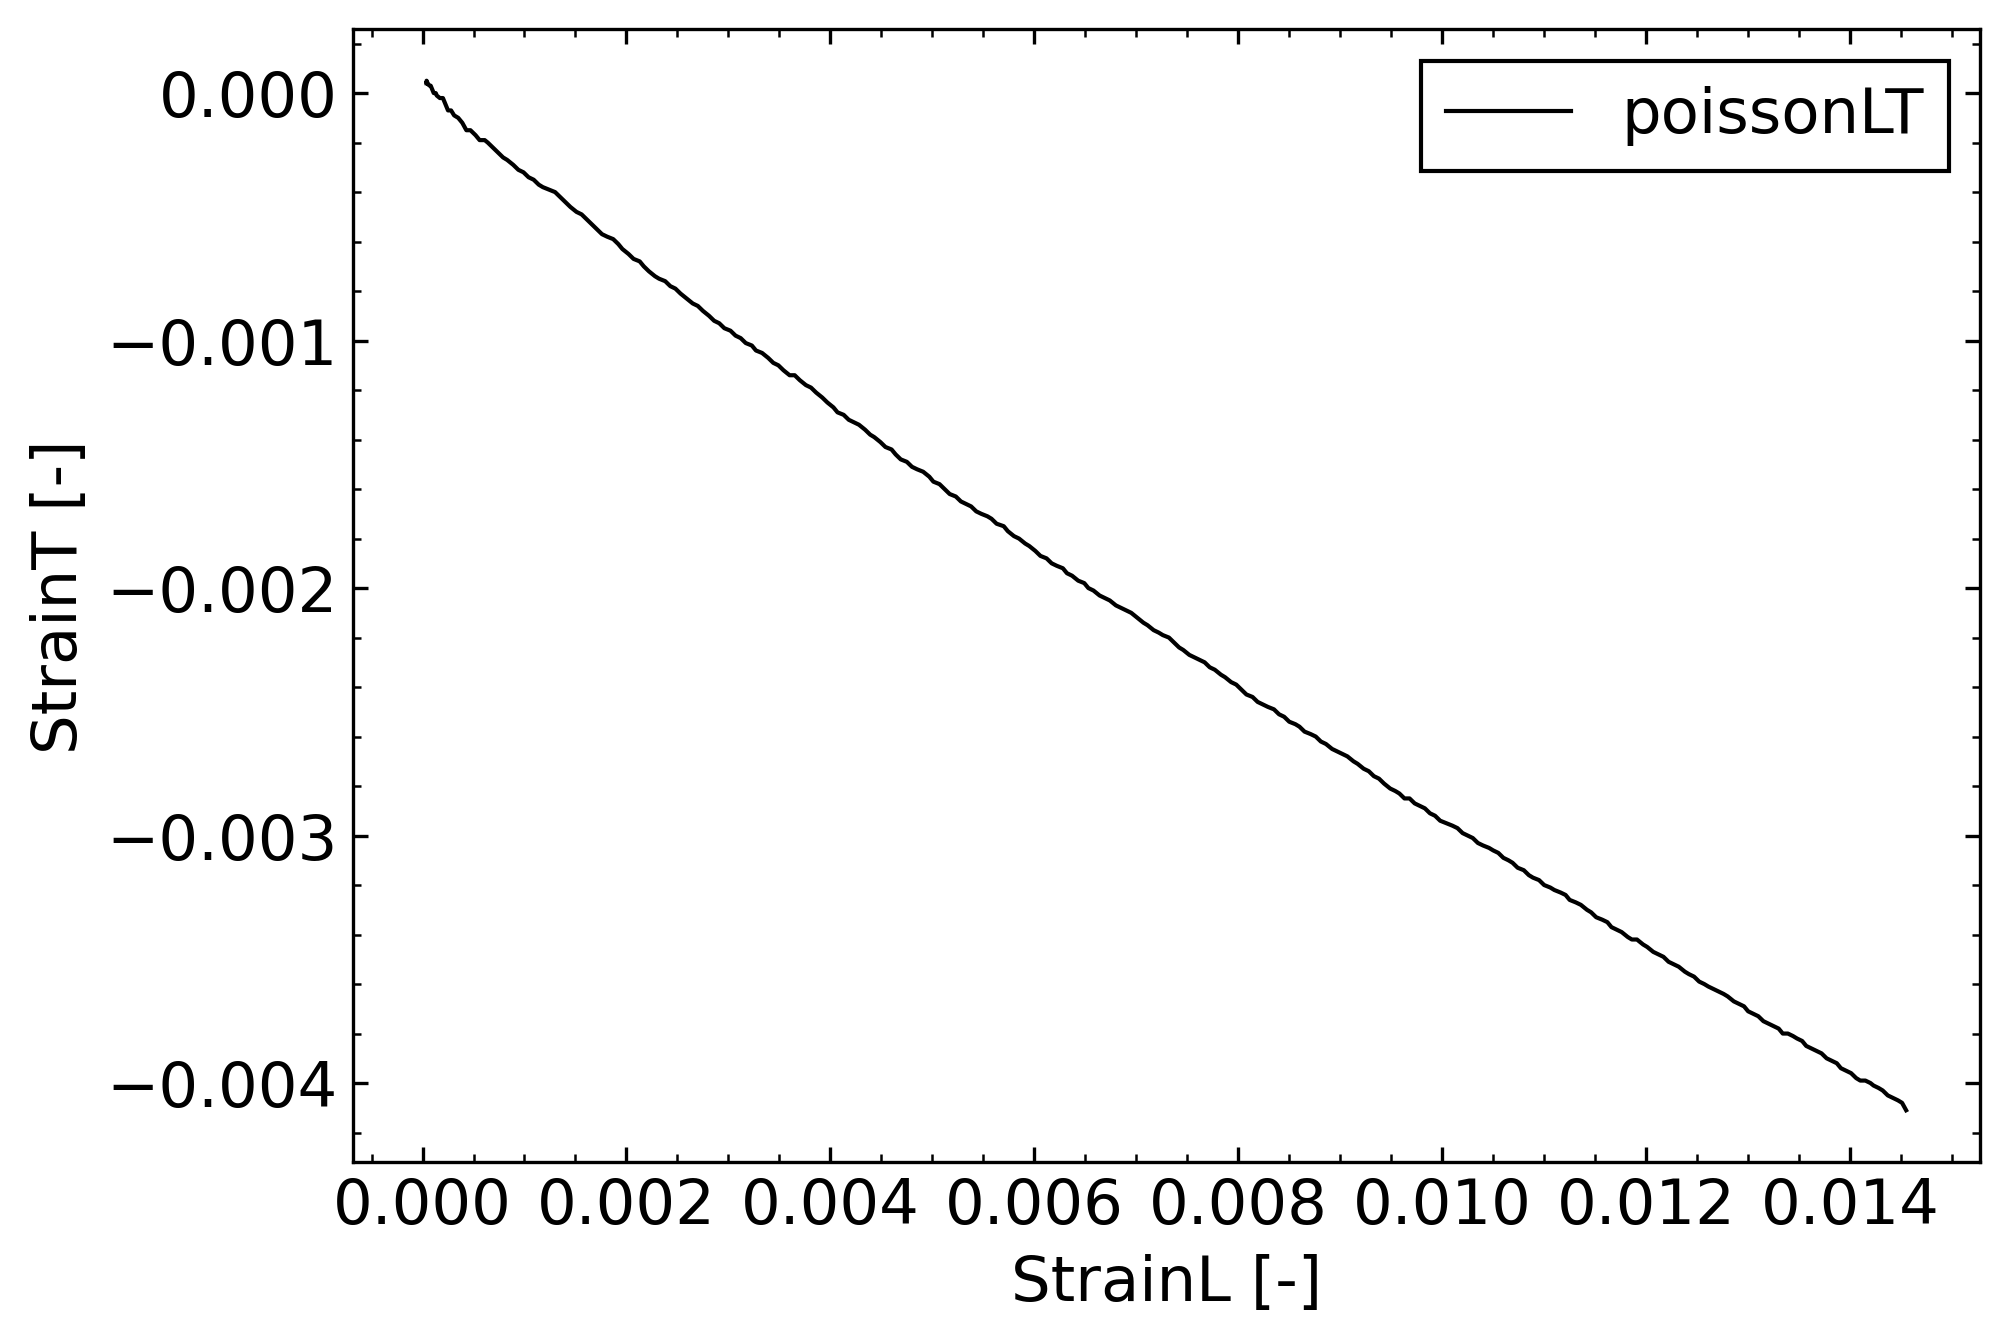

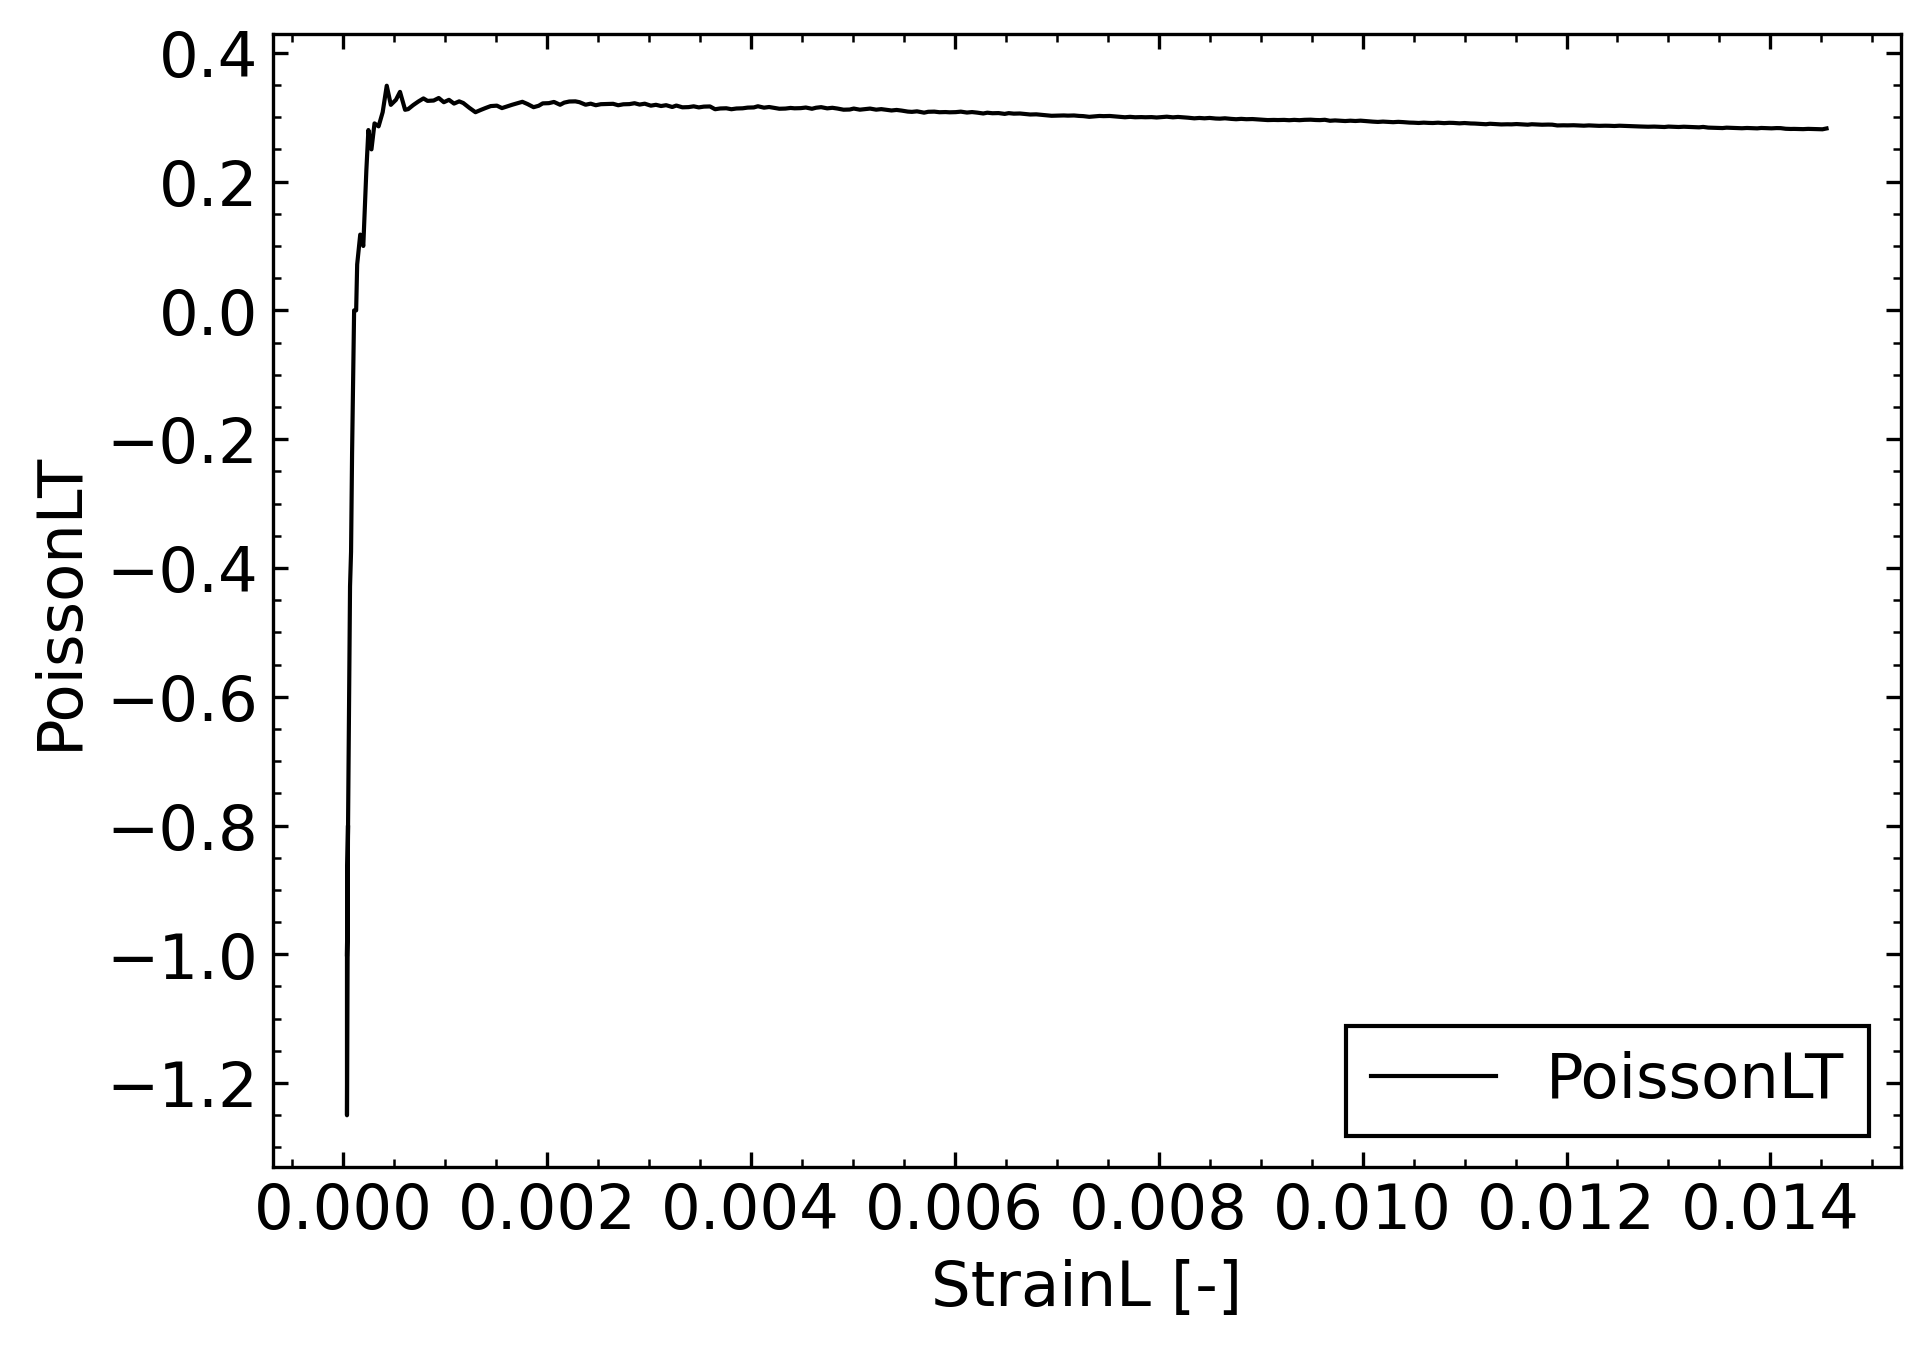

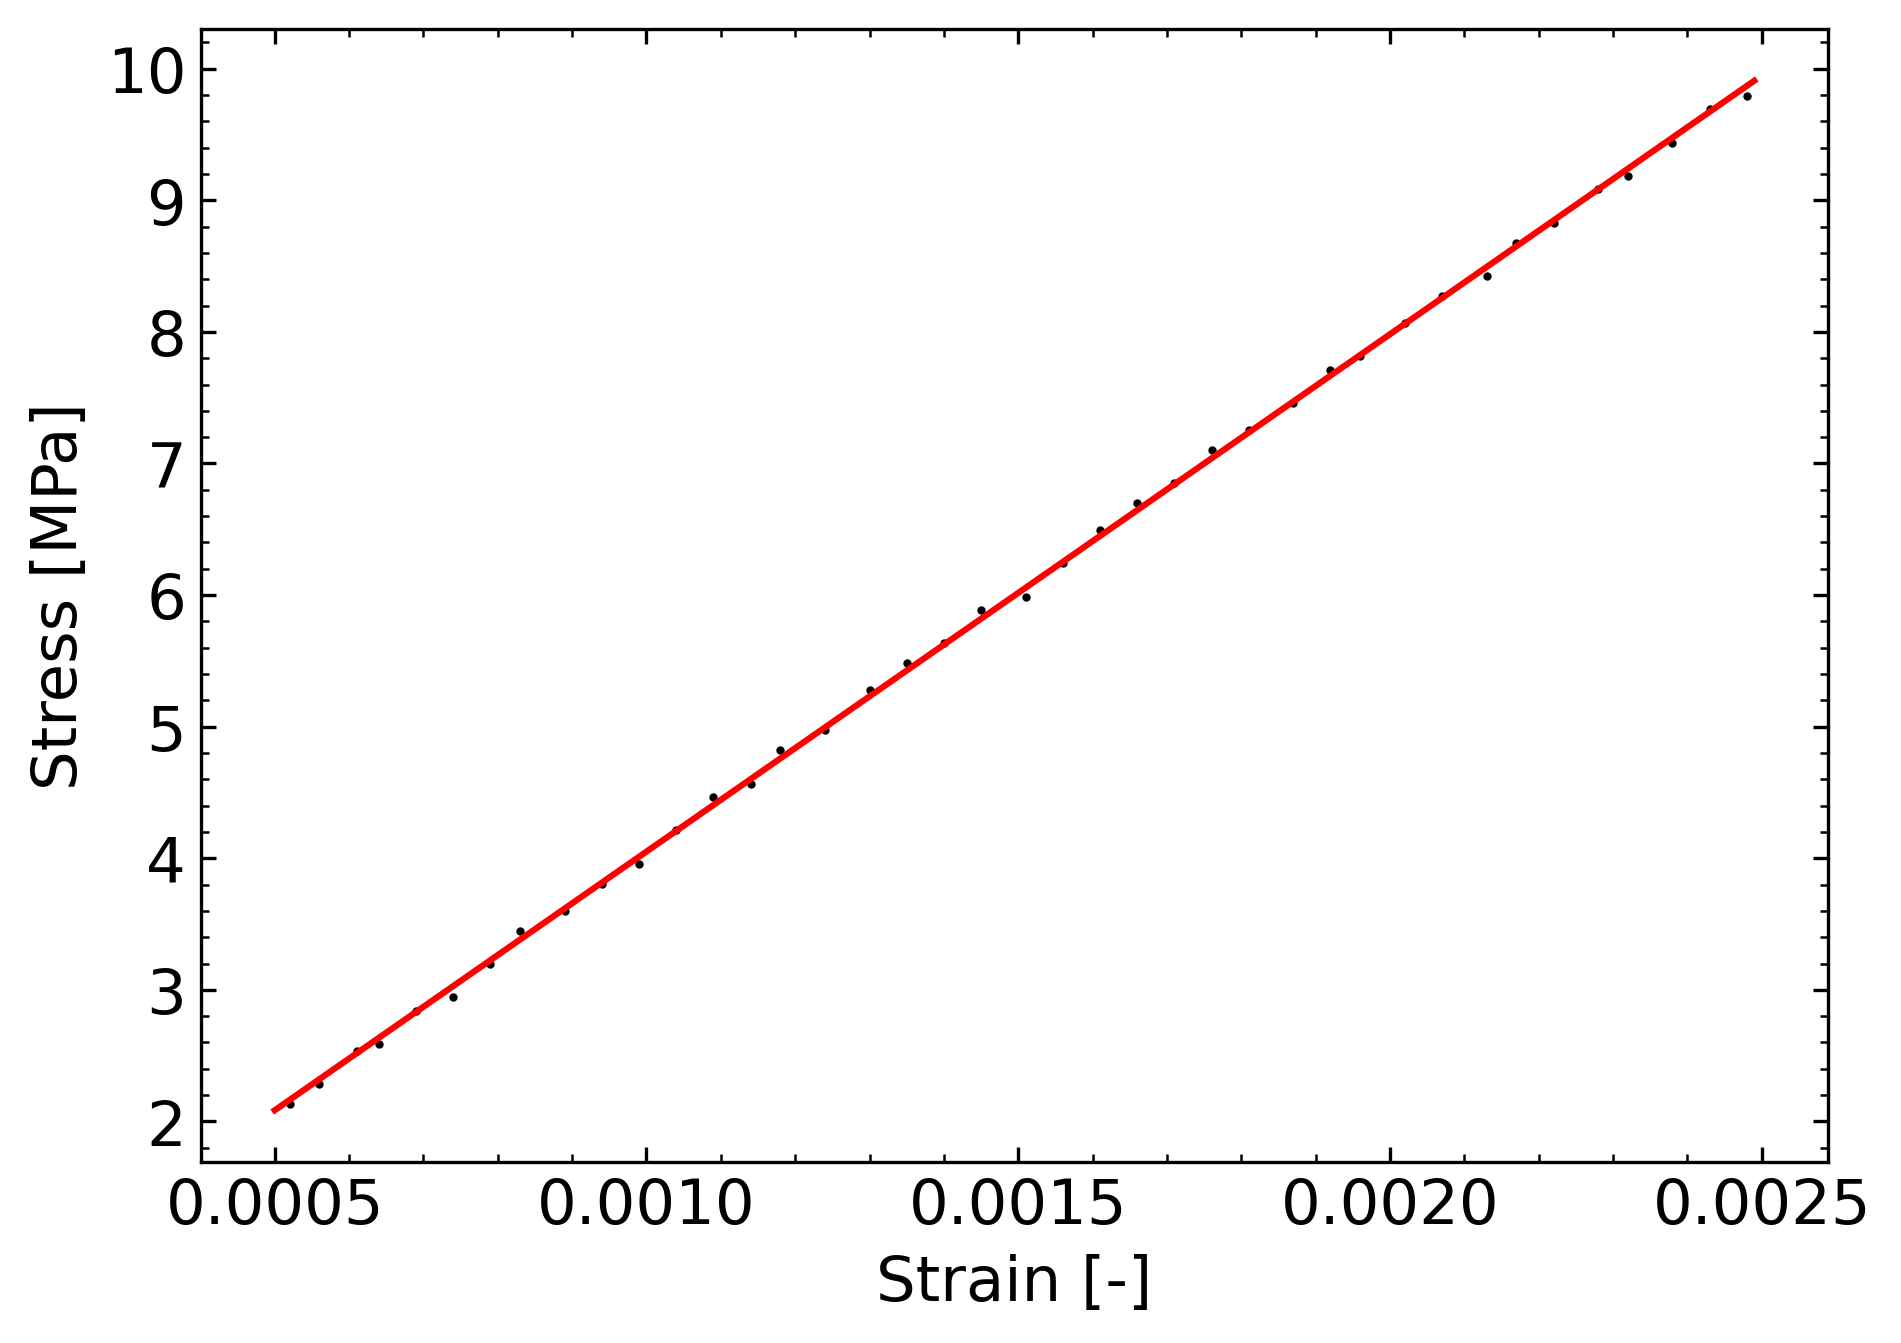

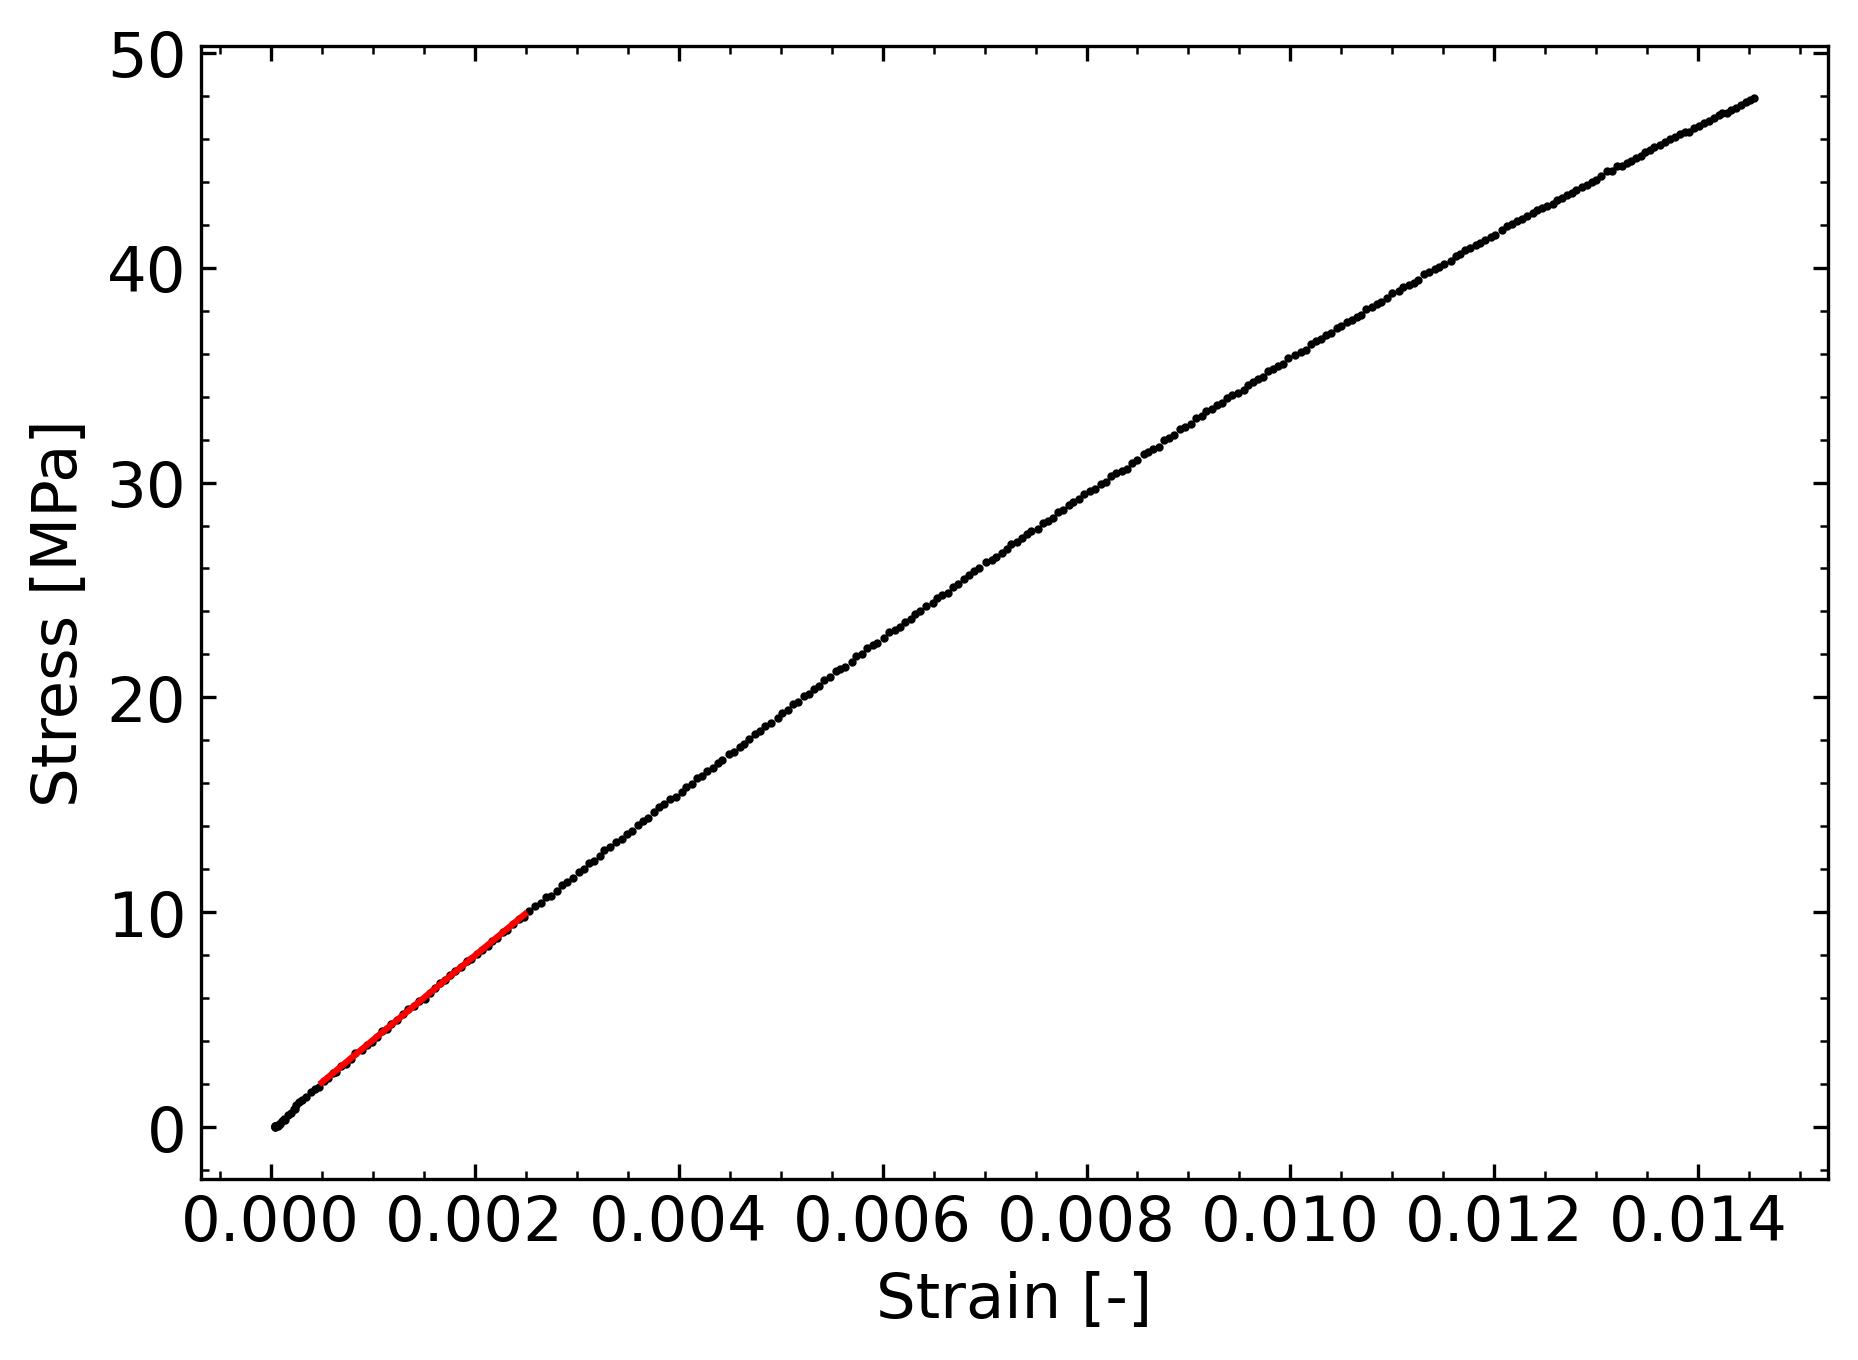

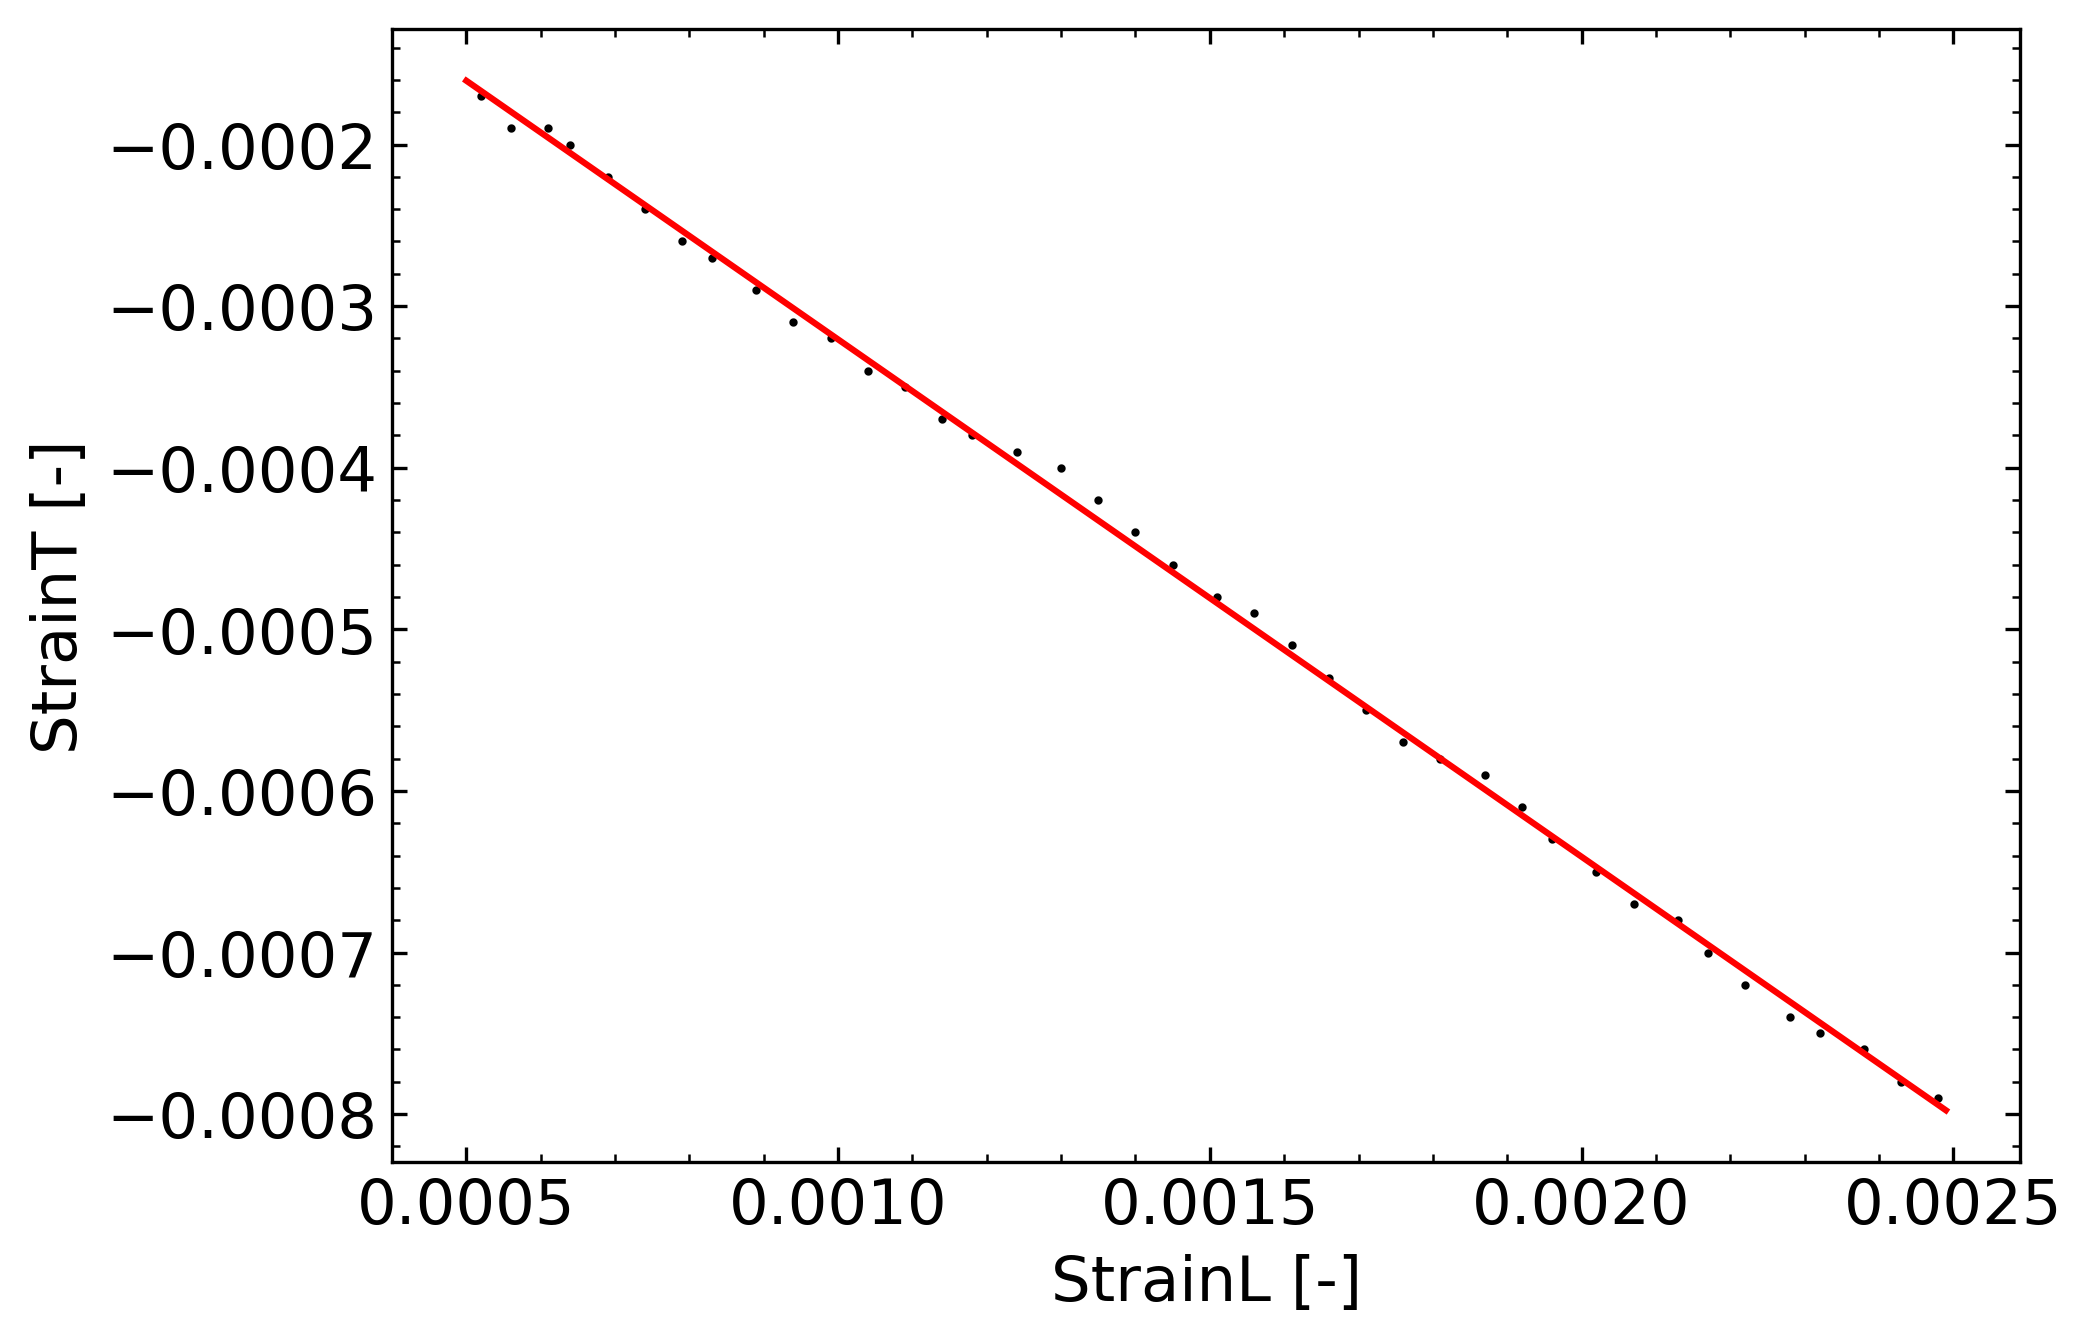

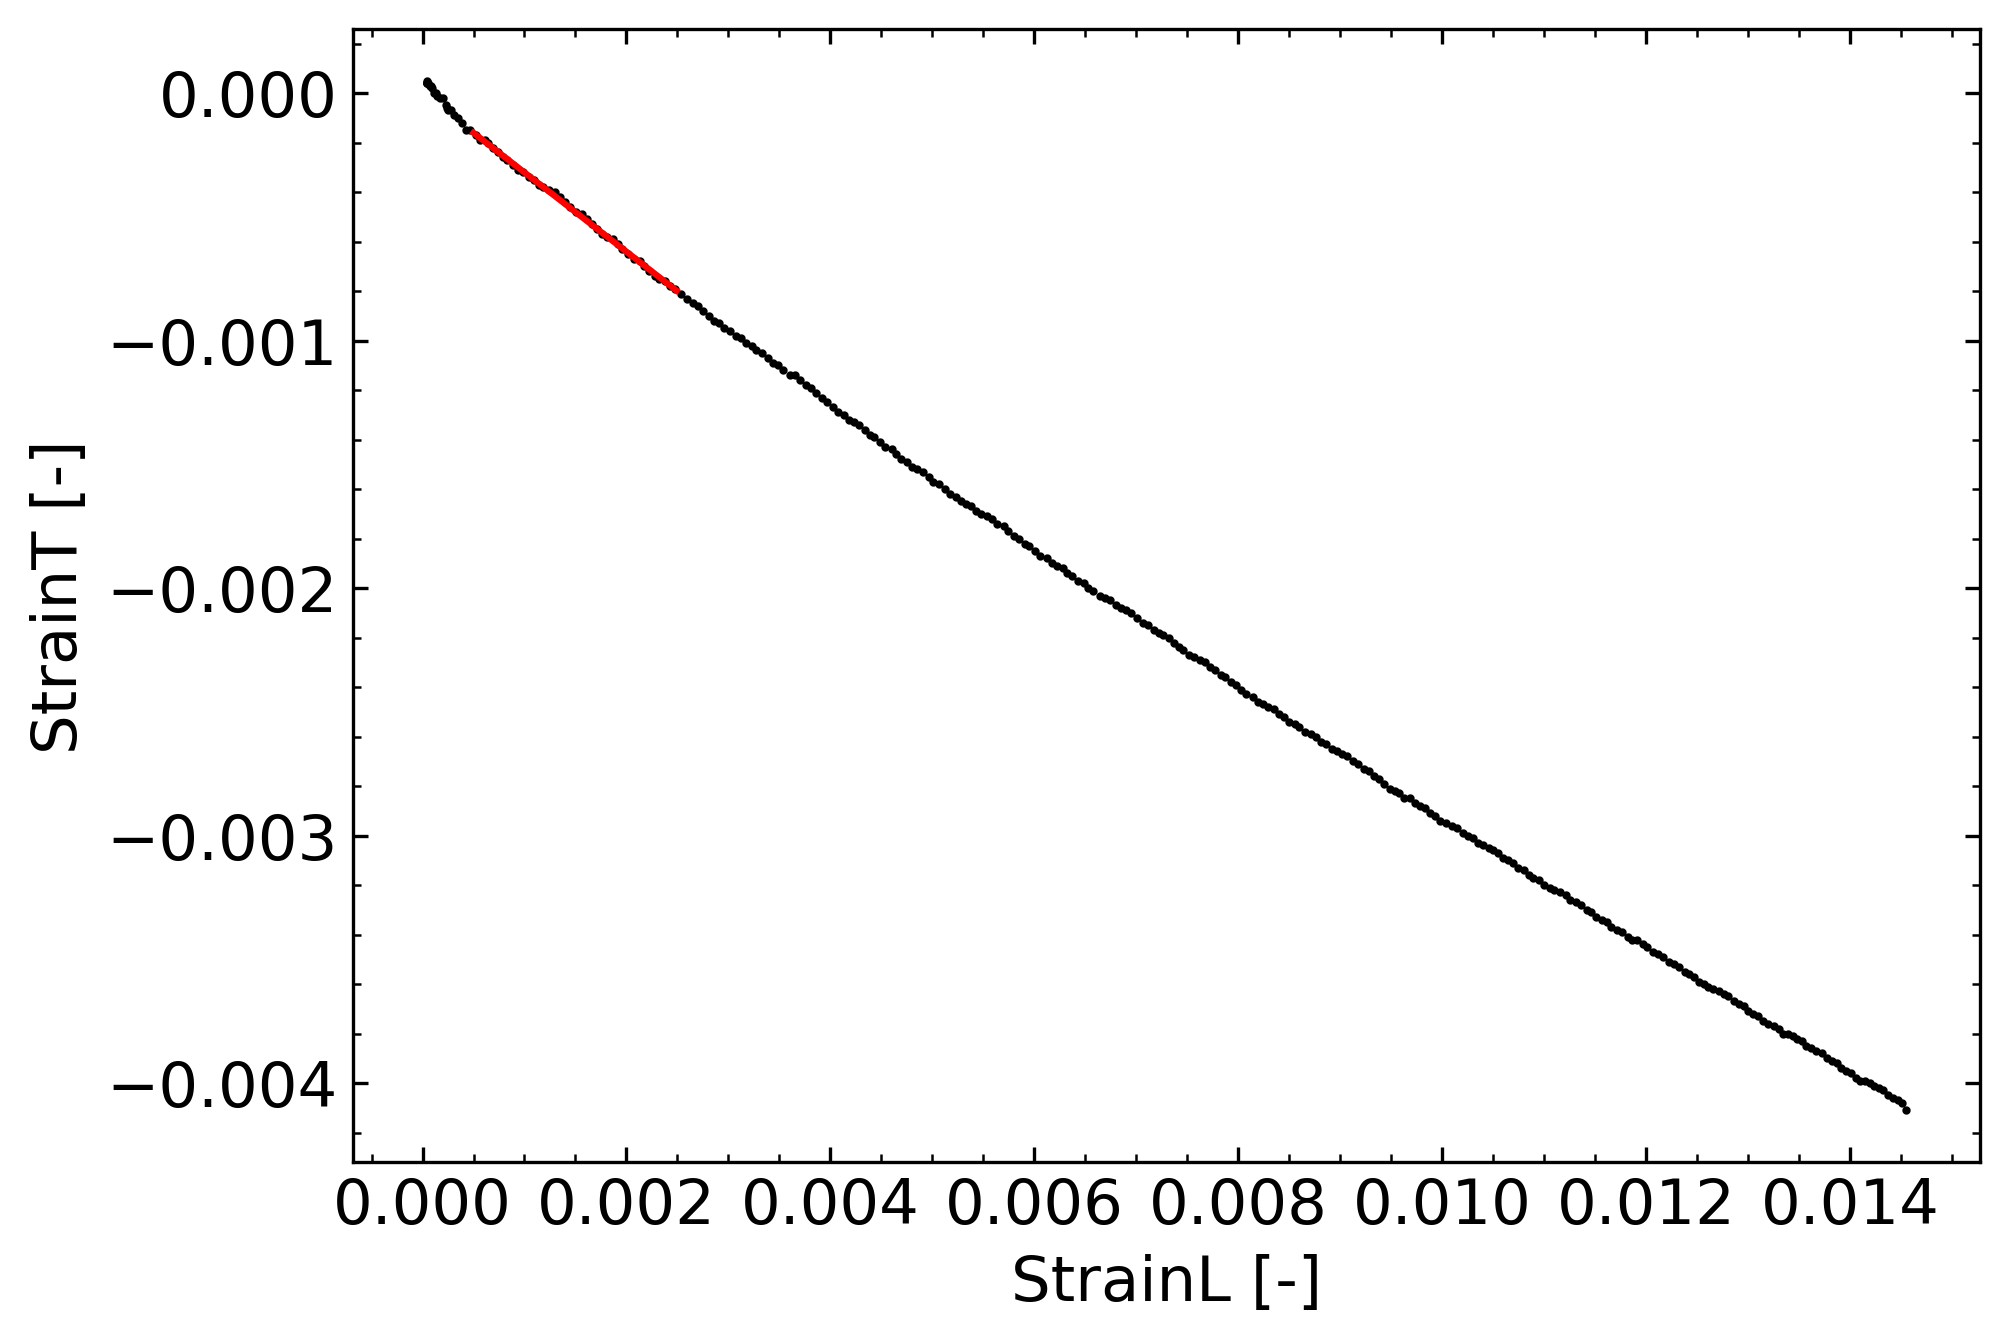

In [ ]:
Test1=TestObject('test_result1.csv')

widths1 = [14.96,14.96,14.96,14.96,15.01,14.97,14.96,14.96,14.96] 
thicknesses1 = [1.35,1.33,1.33,1.31,1.30,1.31,1.30,1.31,1.31]

Test1.set_specimen(widths=widths1, thicknesses=thicknesses1)
Test1.set_test_condition(gauge_rate=2.1, Force_scale=50000/5, cross_head_scale=50/5)
Test1.do_set()

平均幅[mm] 15.005555555555556
平均厚さ[mm] 1.3133333333333335
断面積[m^2] 1.97072962962963e-05
#EndHeader     object
日時(μs)          int64
(1)HA-V01     float64
(1)HA-V02     float64
(2)ST-CH01    float64
(2)ST-CH02    float64
(2)ST-CH03    float64
(2)ST-CH04    float64
dtype: object
              日時(μs)   (1)HA-V01   (1)HA-V02    (2)ST-CH01   (2)ST-CH02  \
count     254.000000  254.000000  254.000000    254.000000   254.000000   
mean   448850.393701    0.036780    0.014283   6038.616142 -2086.771654   
std    286952.643178    0.021462    0.008085   3762.624119  1251.061077   
min      2000.000000    0.000000    0.001000    -10.500000 -4252.500000   
25%    202000.000000    0.018825    0.008000   2808.750000 -3134.250000   
50%    402000.000000    0.038500    0.014000   6100.500000 -2121.000000   
75%    702000.000000    0.055150    0.022000   9205.875000 -1023.750000   
max    902000.000000    0.071300    0.028000  12600.000000     0.000000   

         (2)ST-CH03   (2)ST-CH04      stress  cro

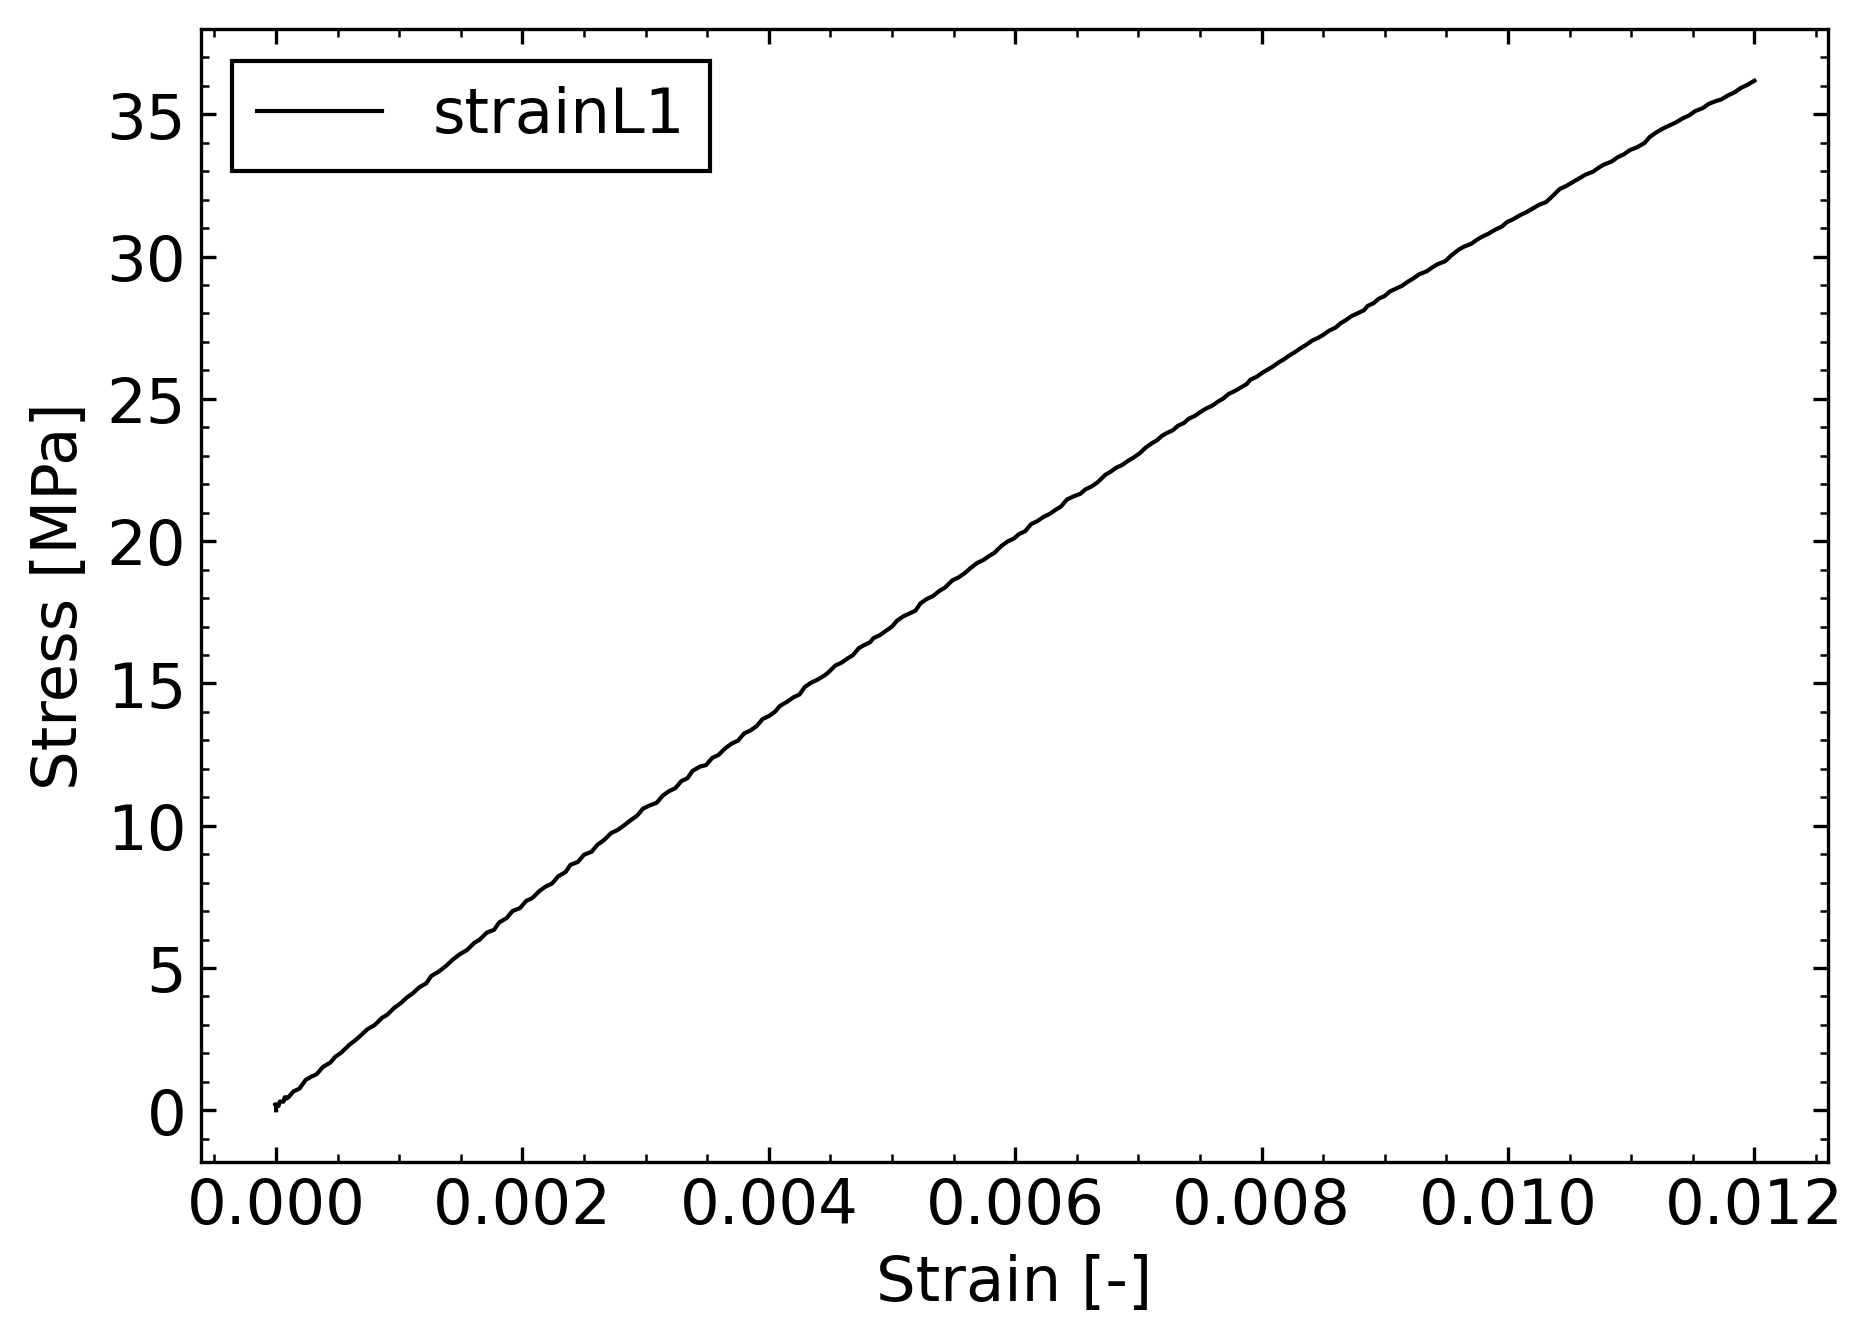

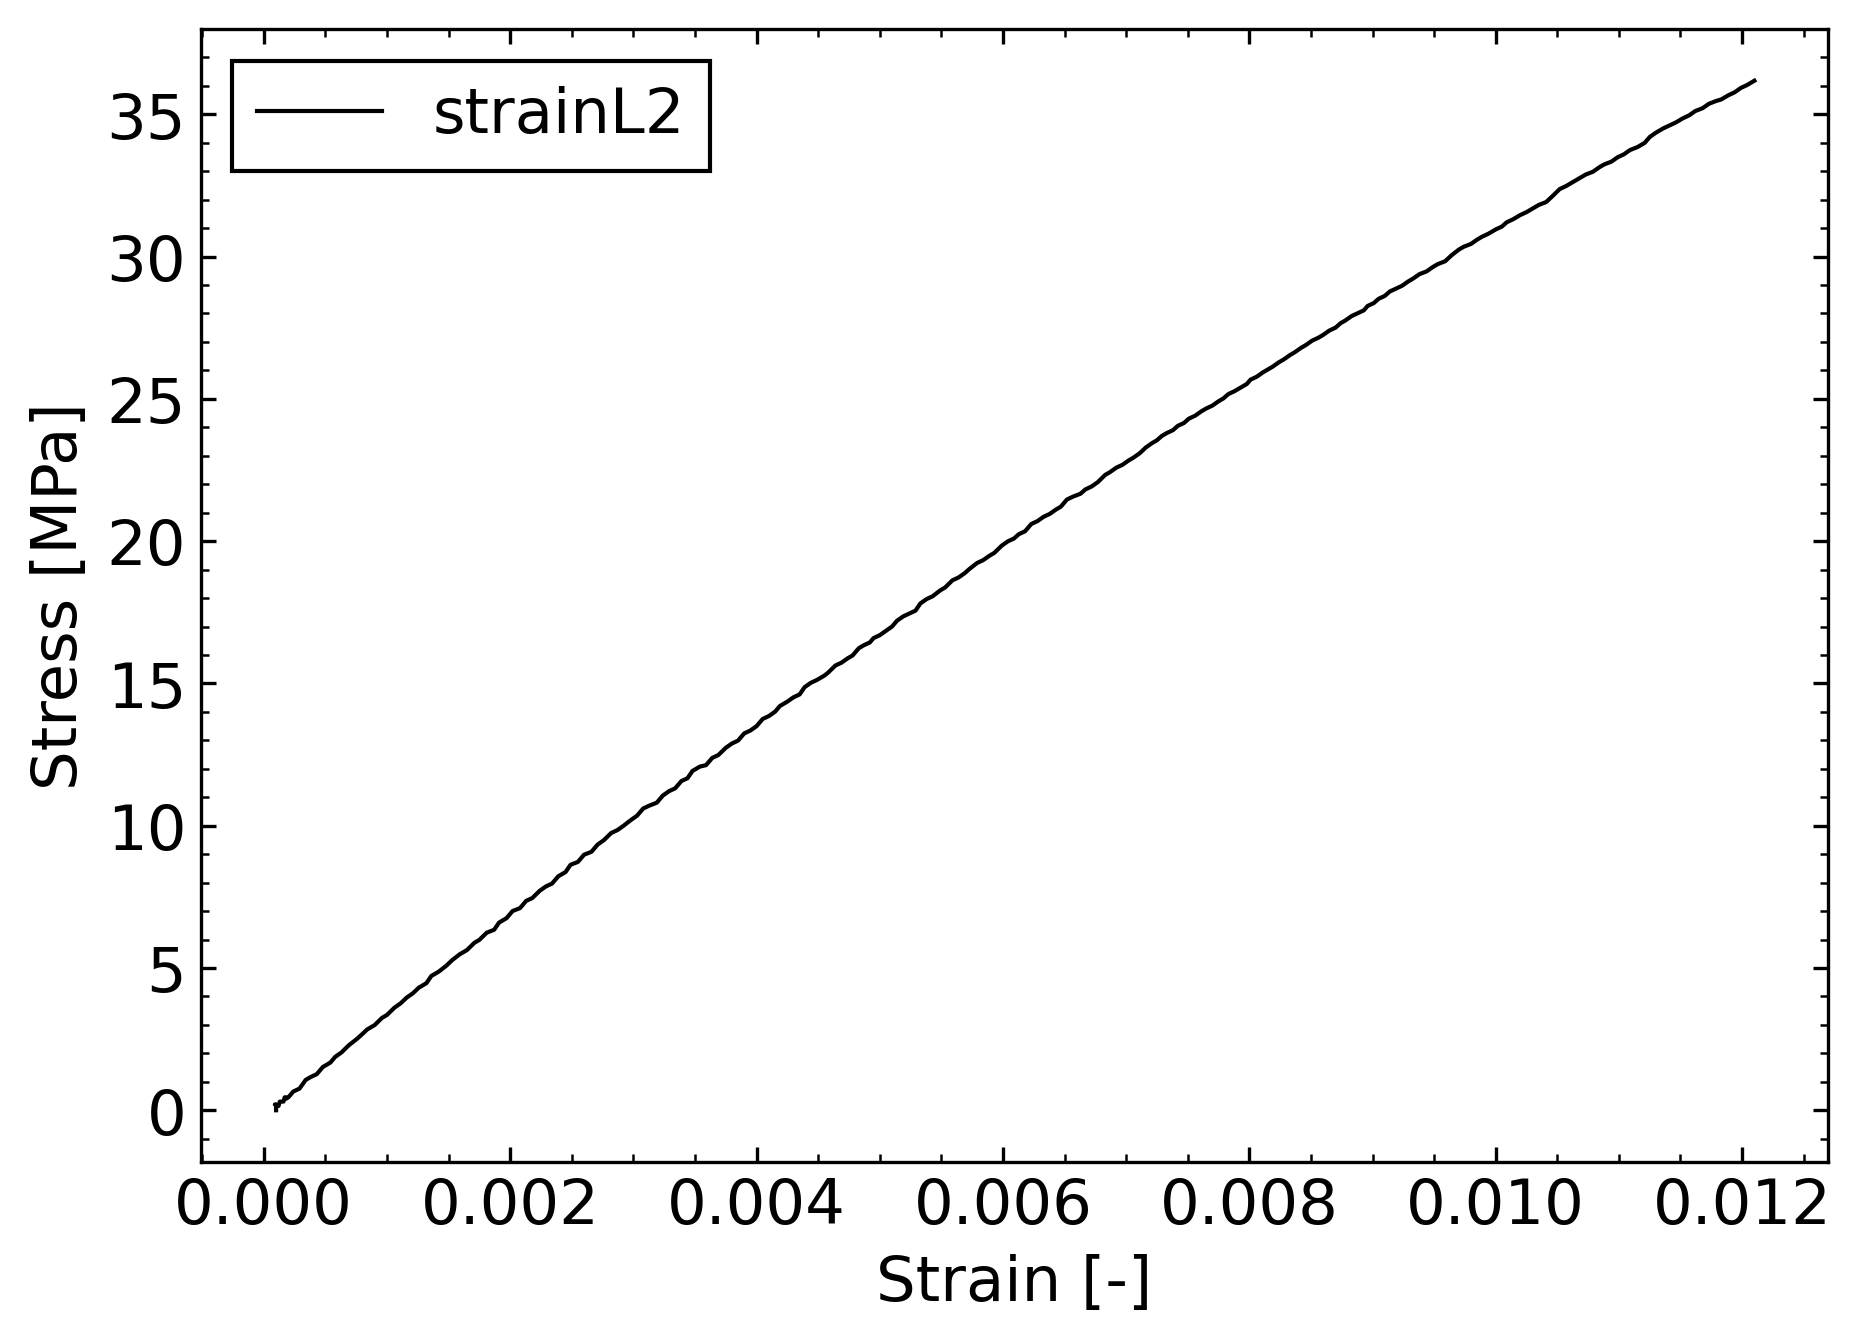

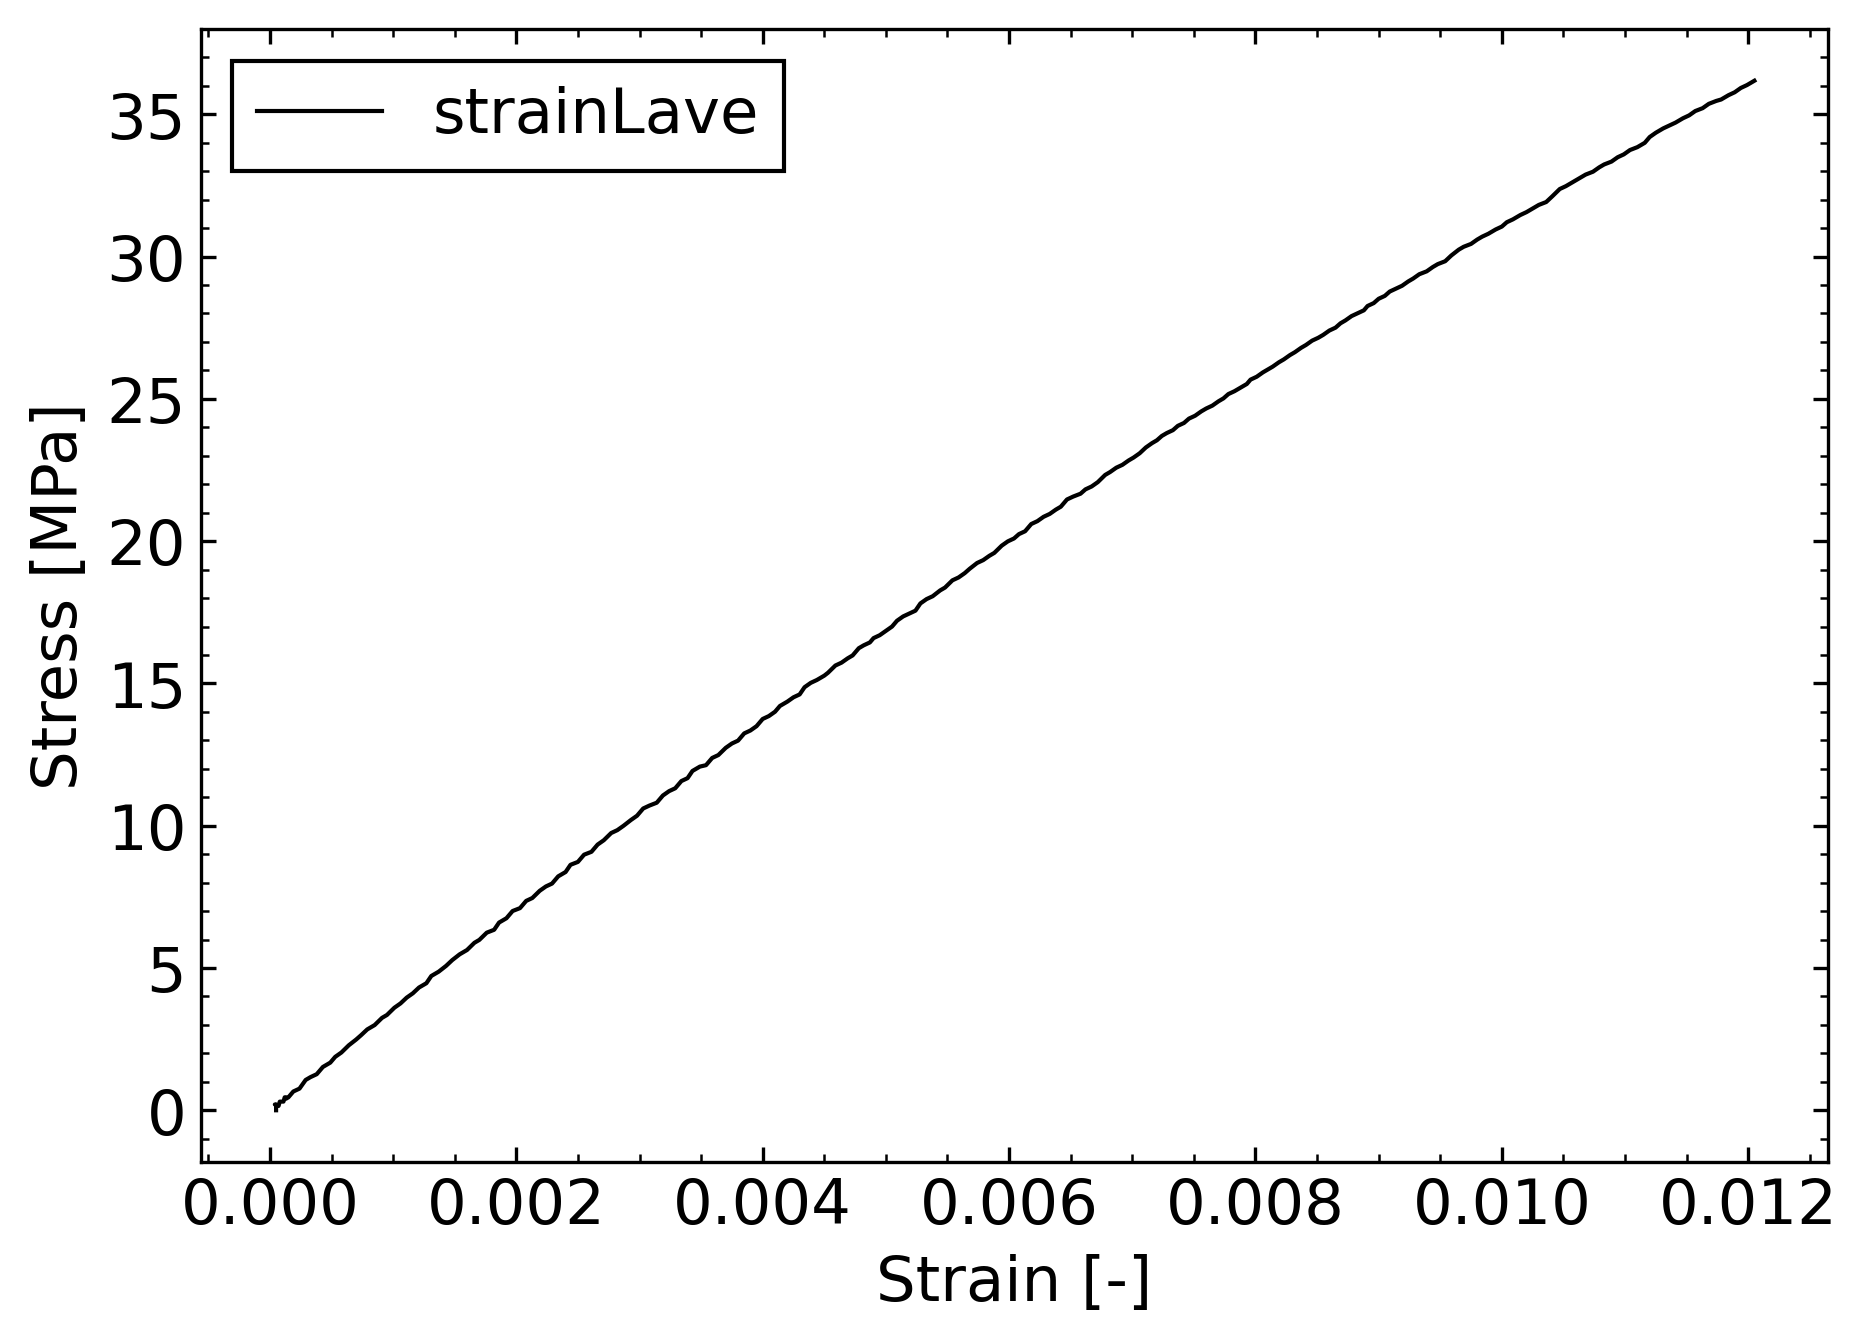

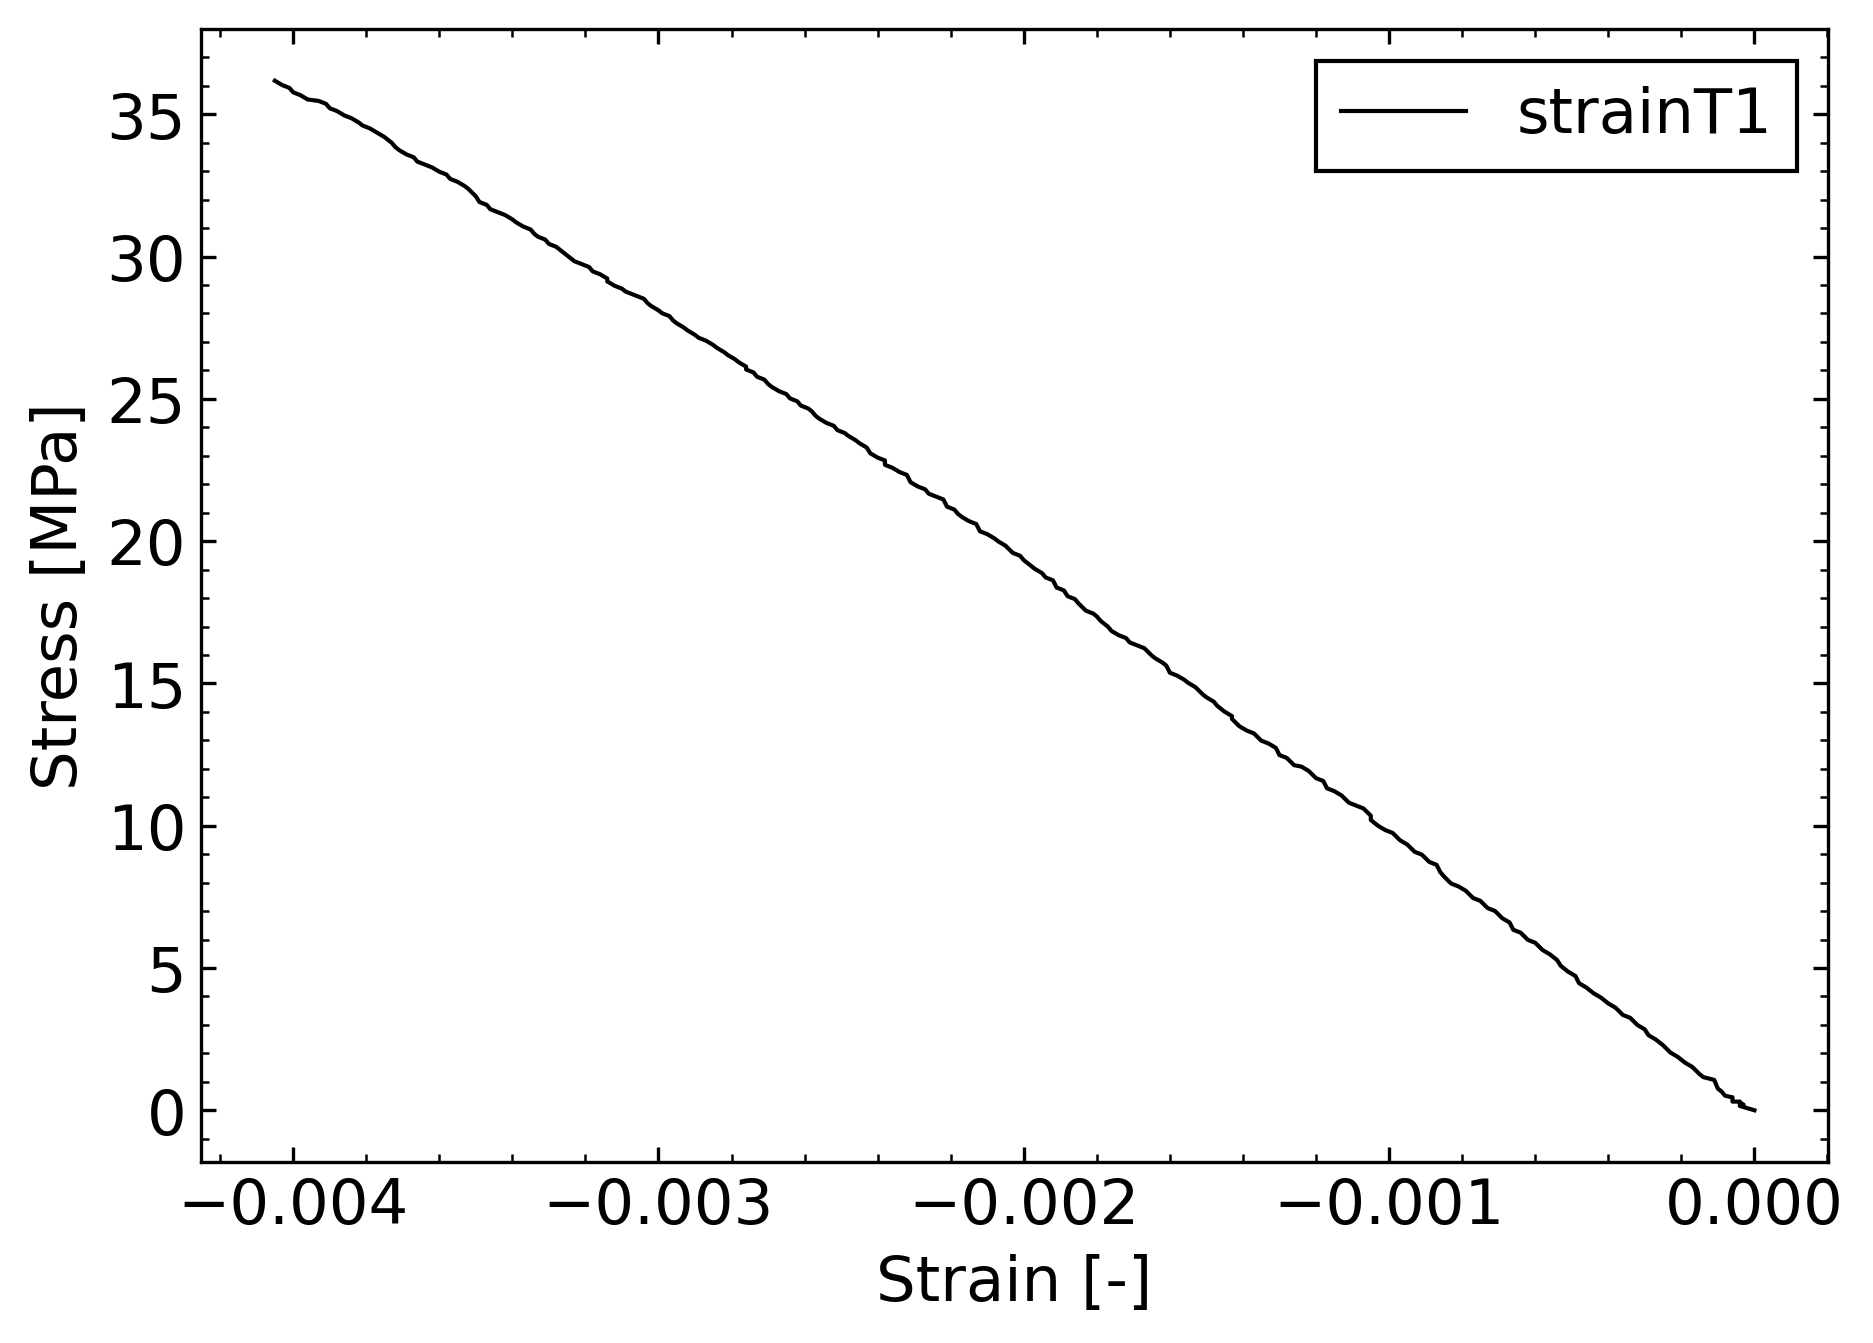

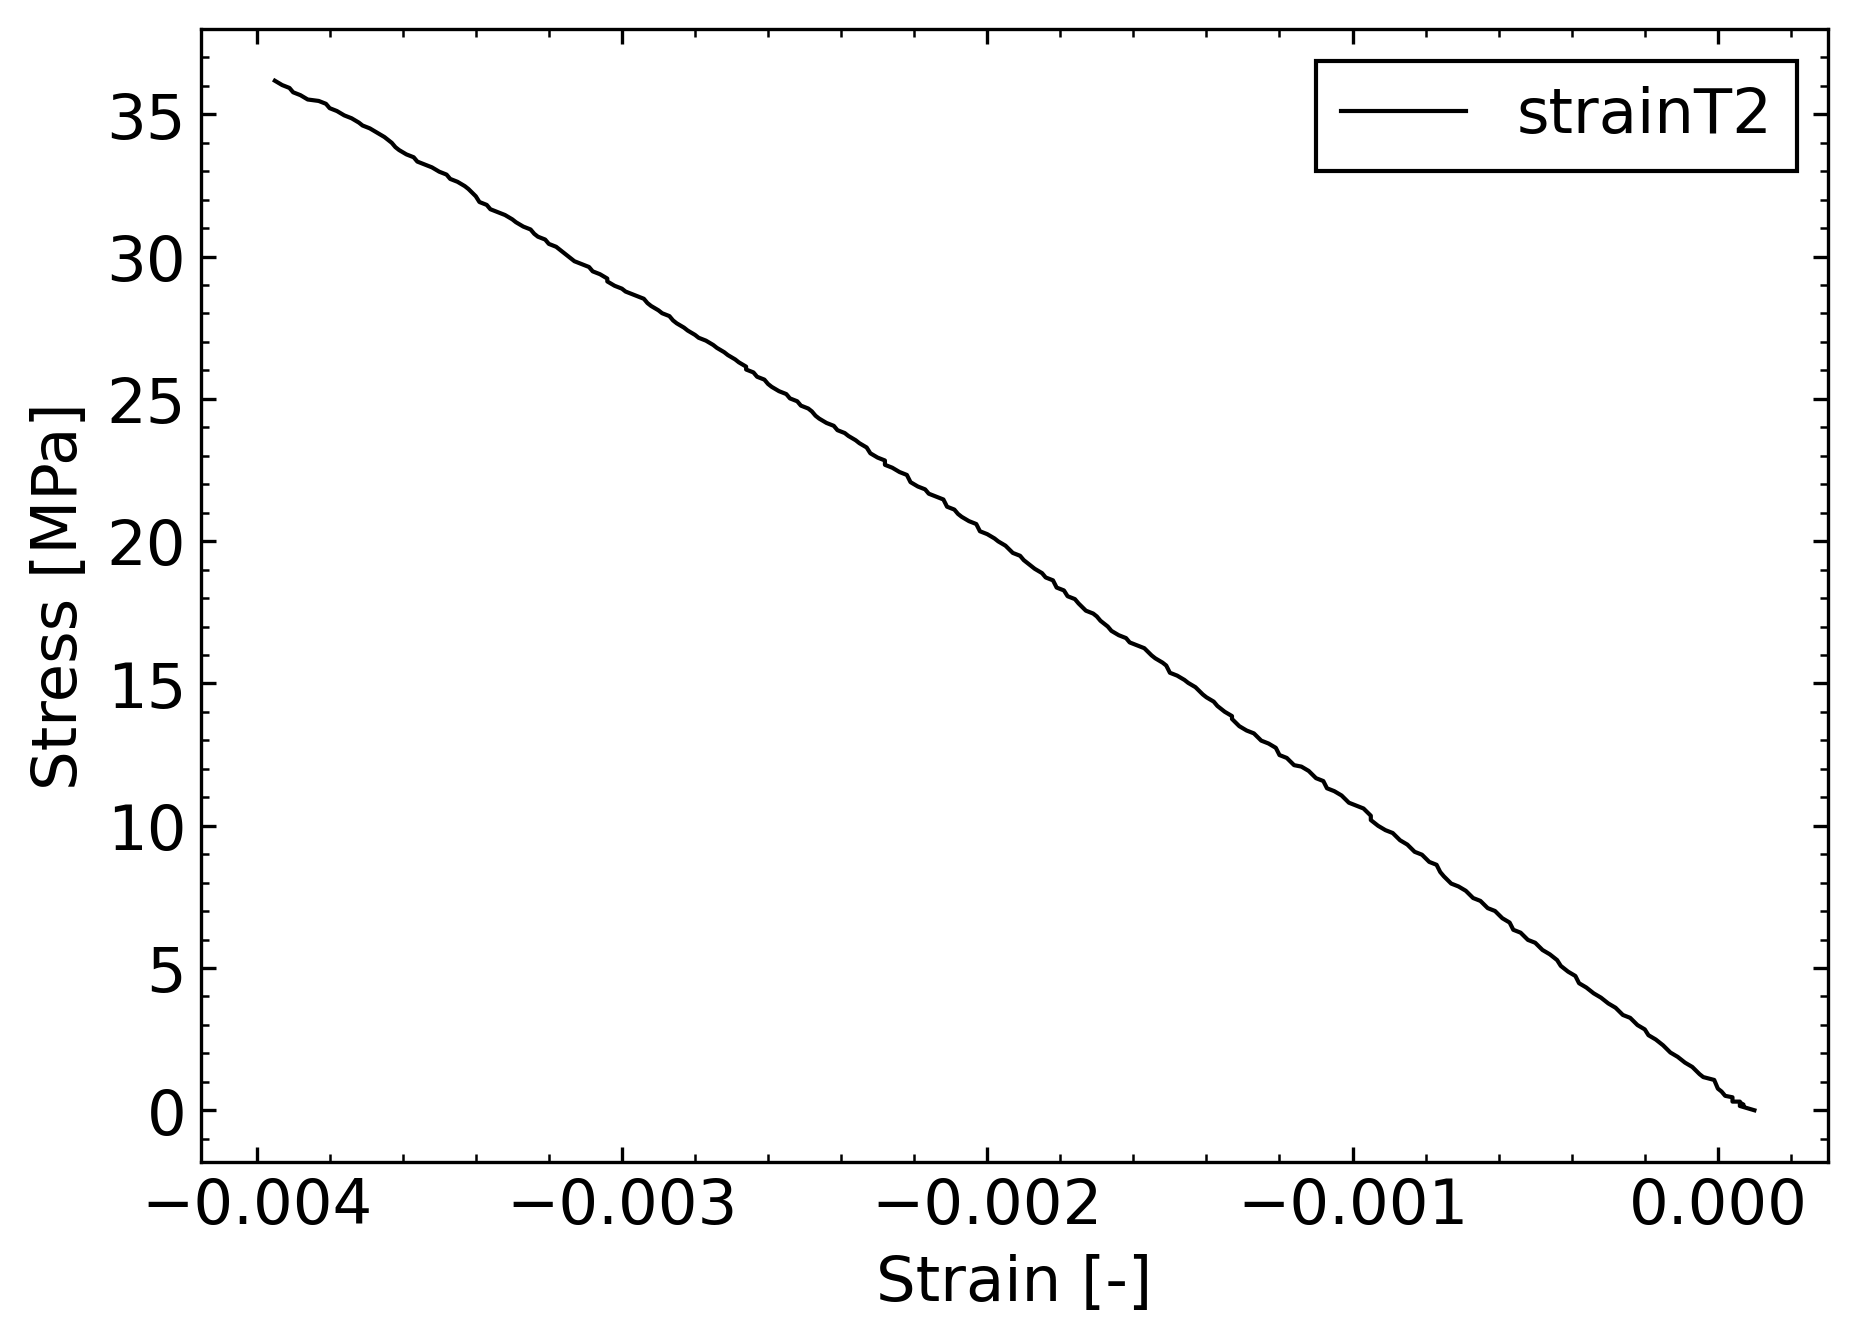

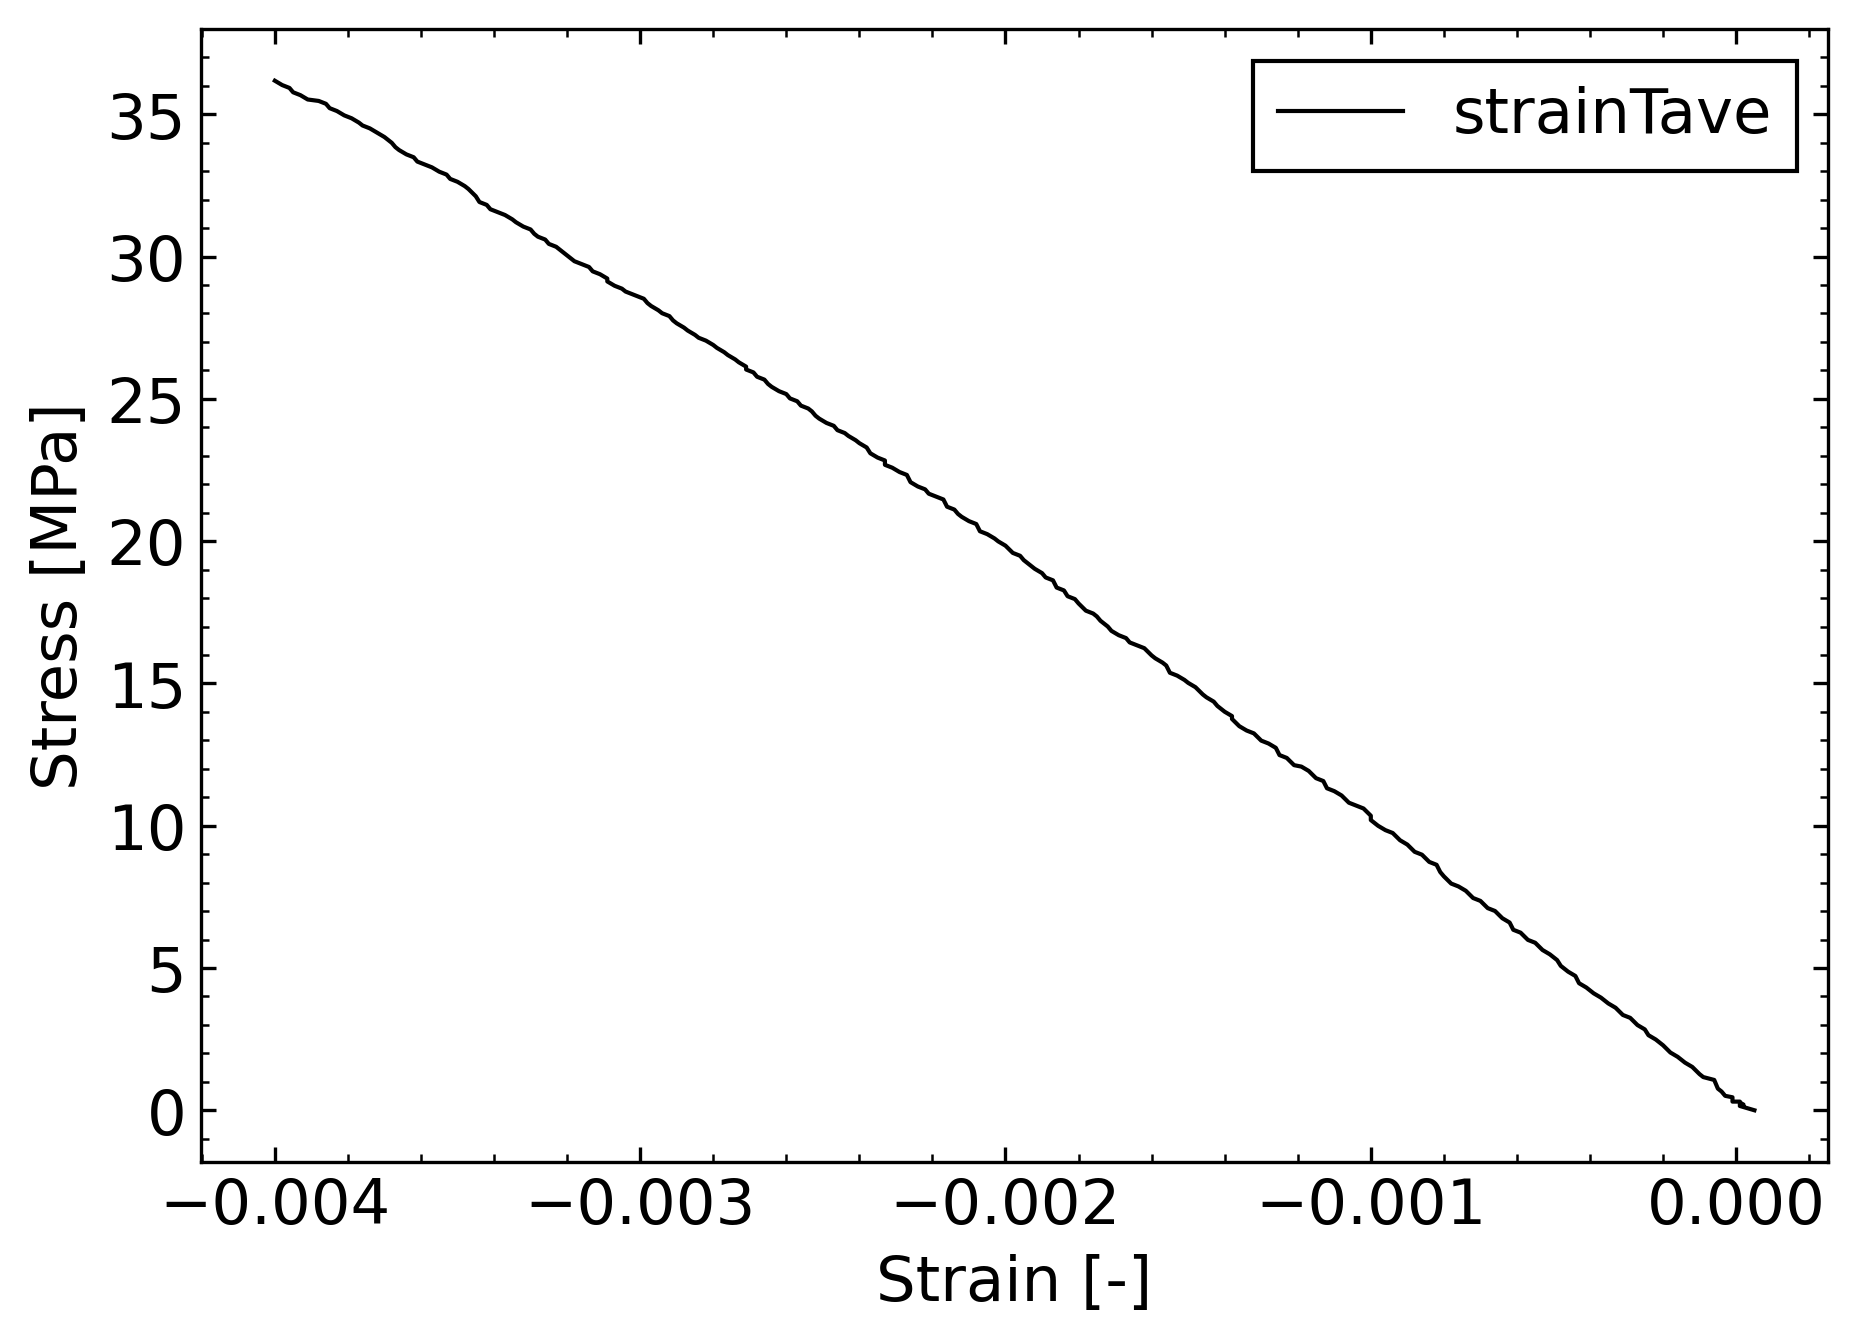

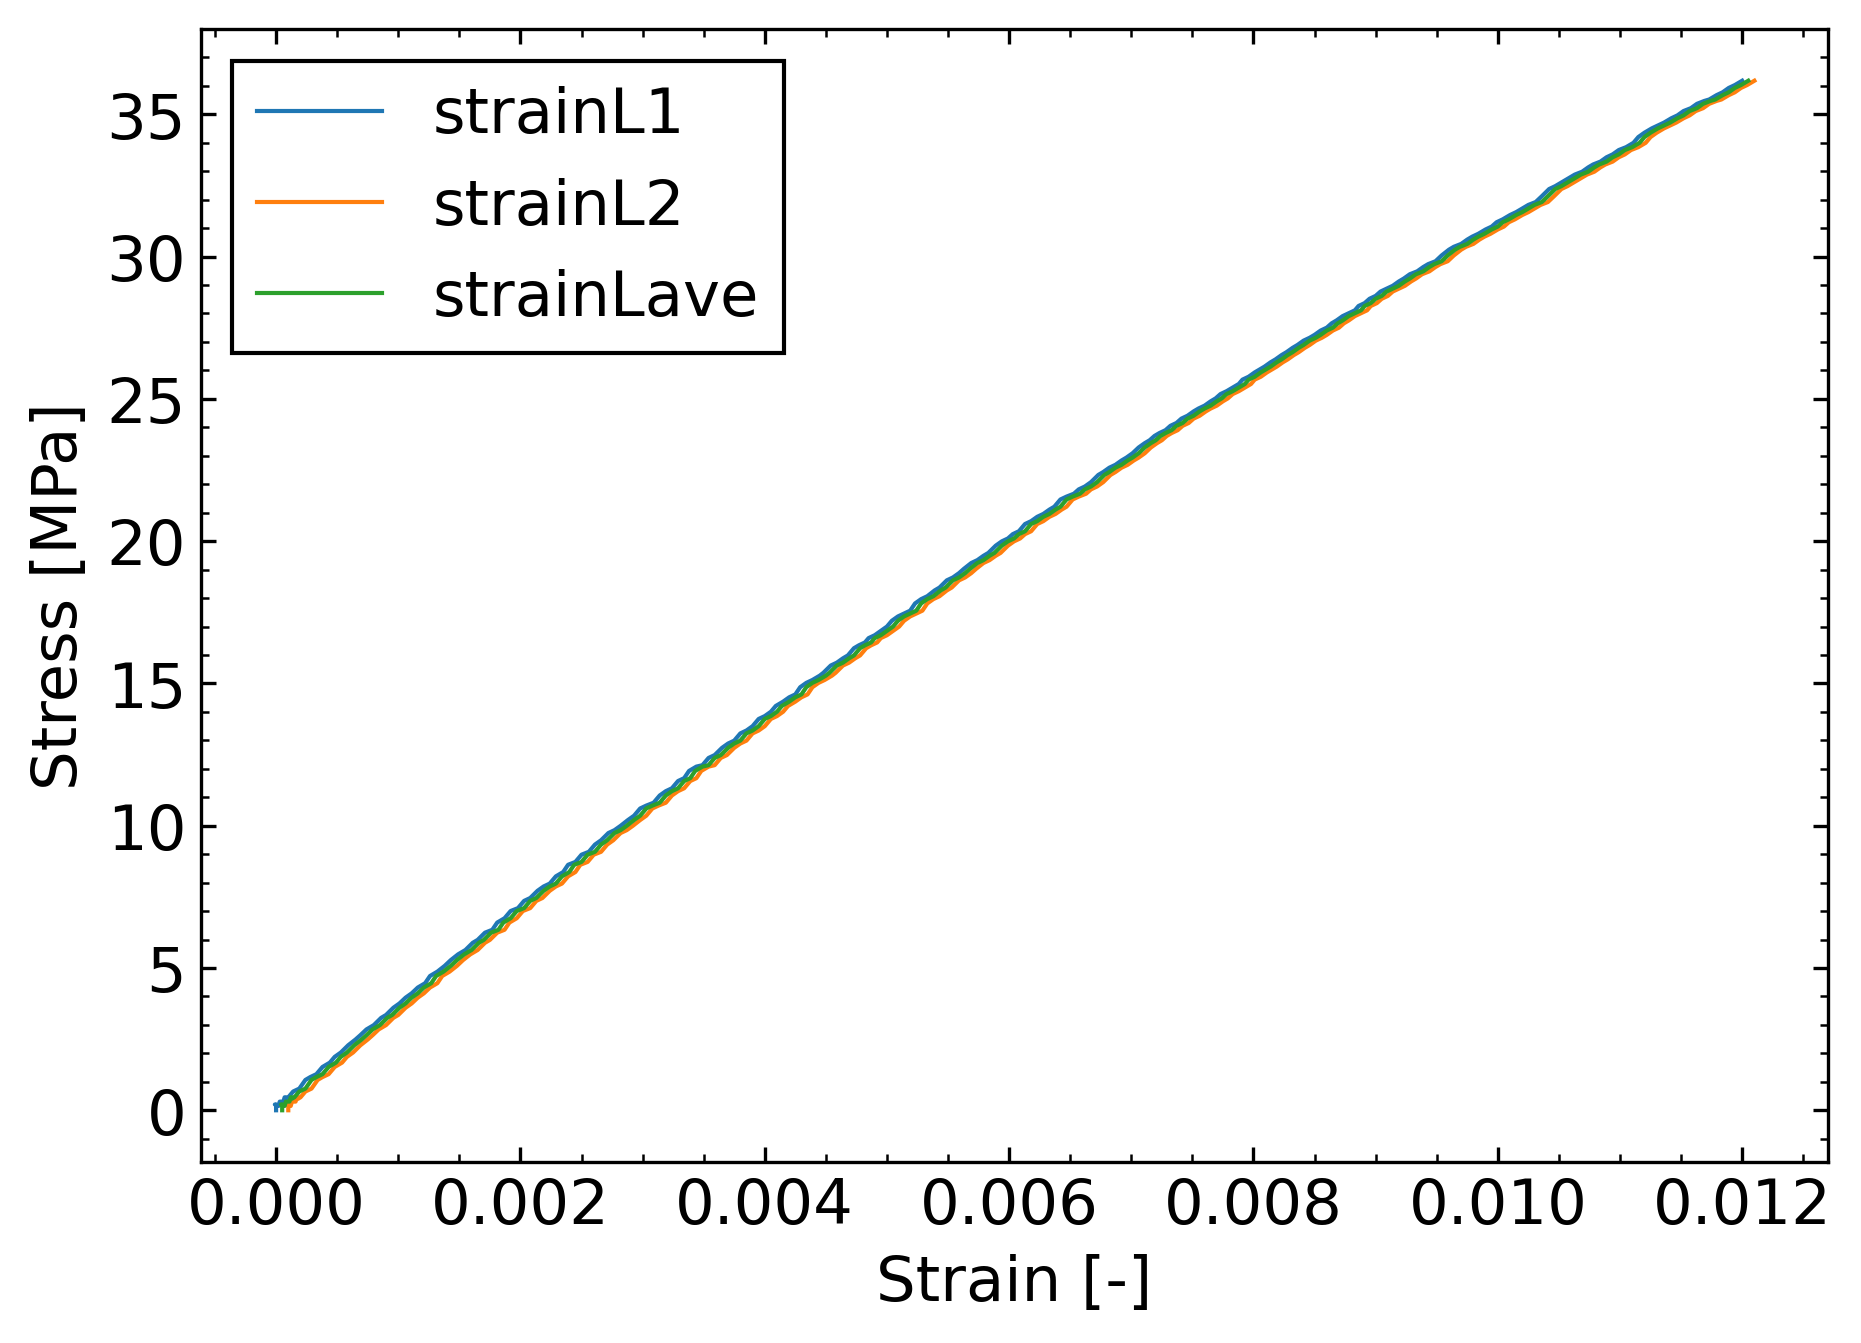

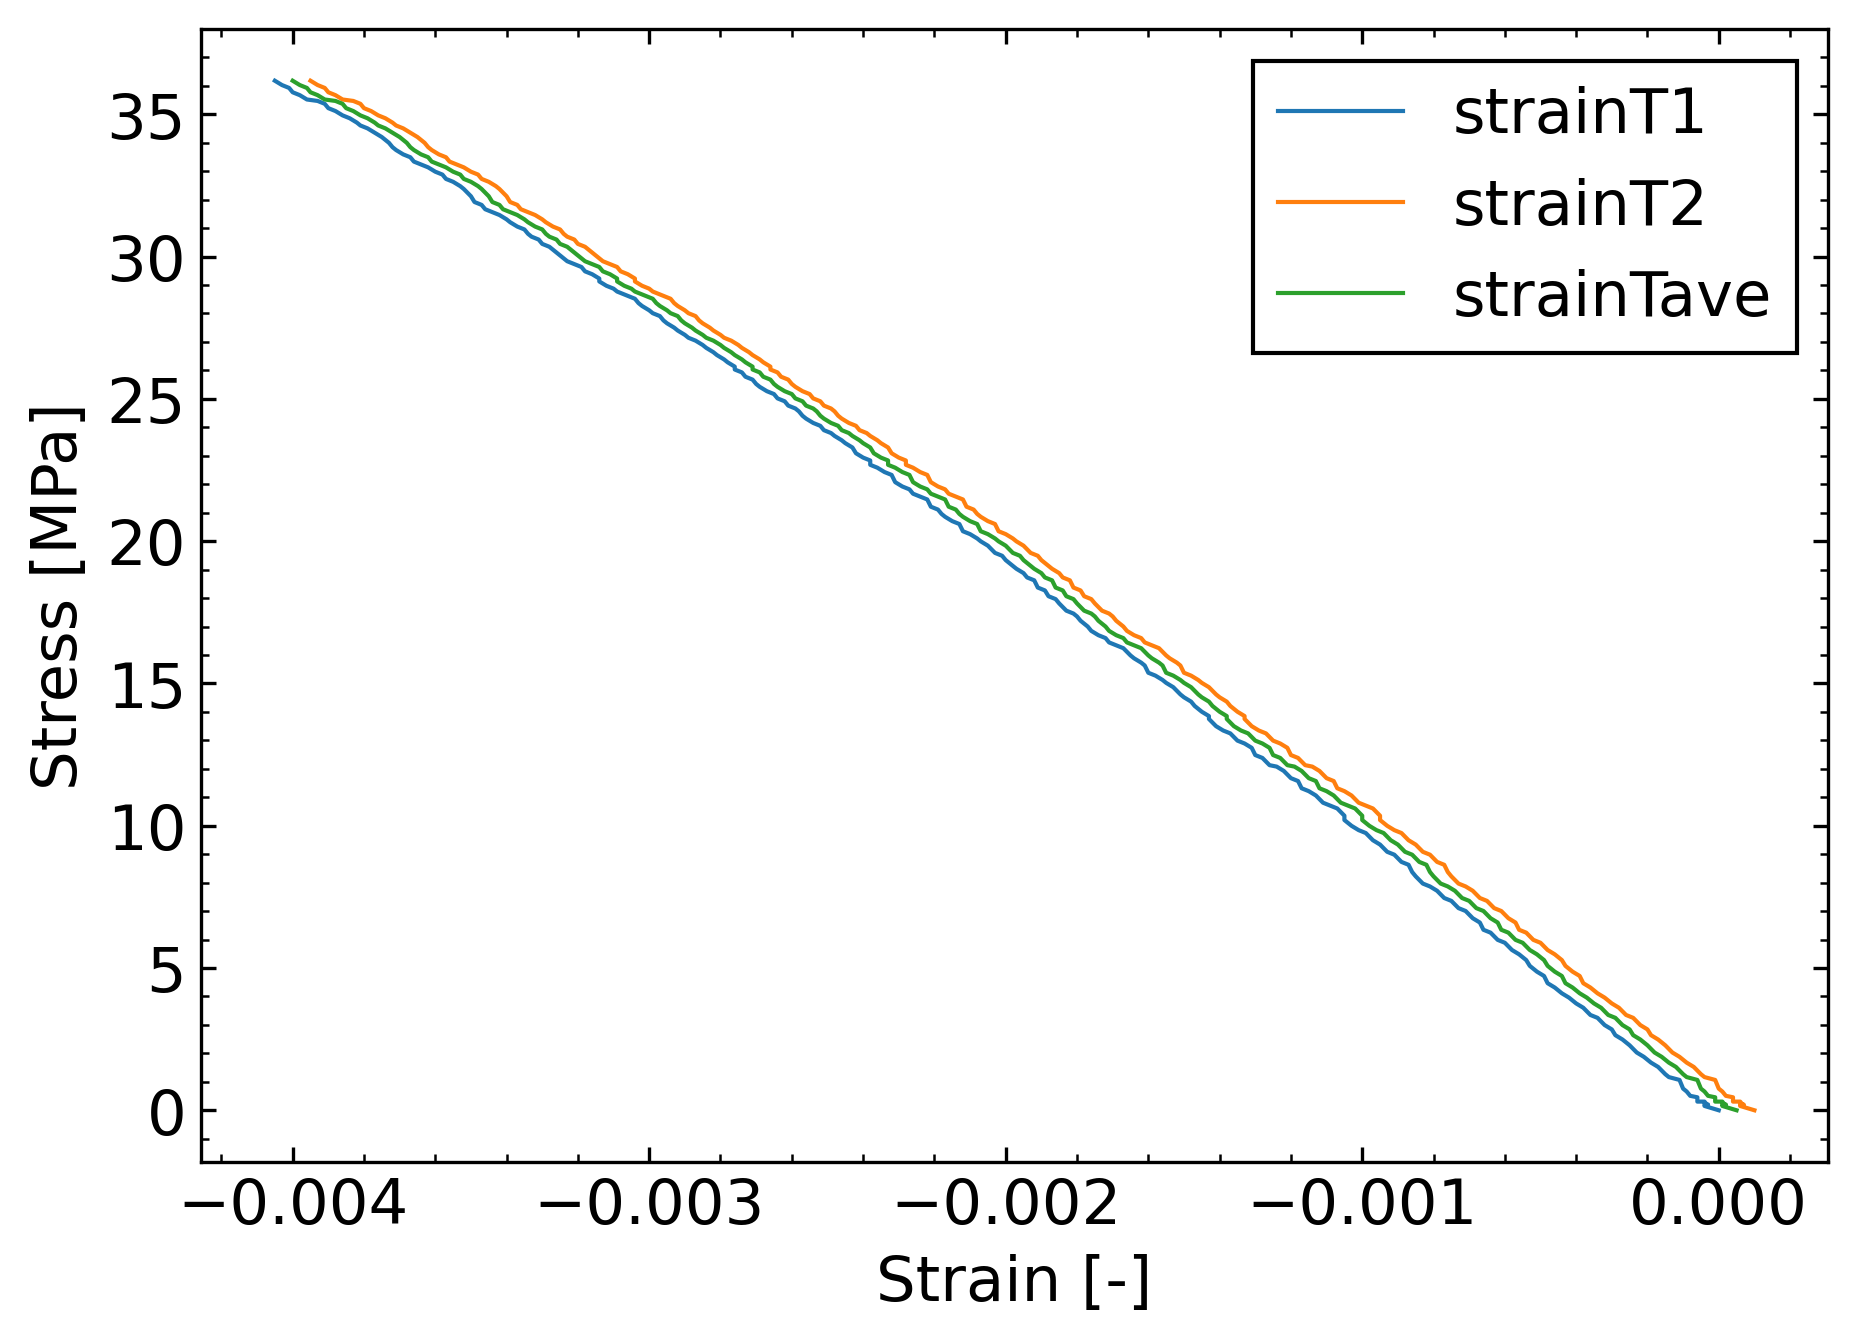

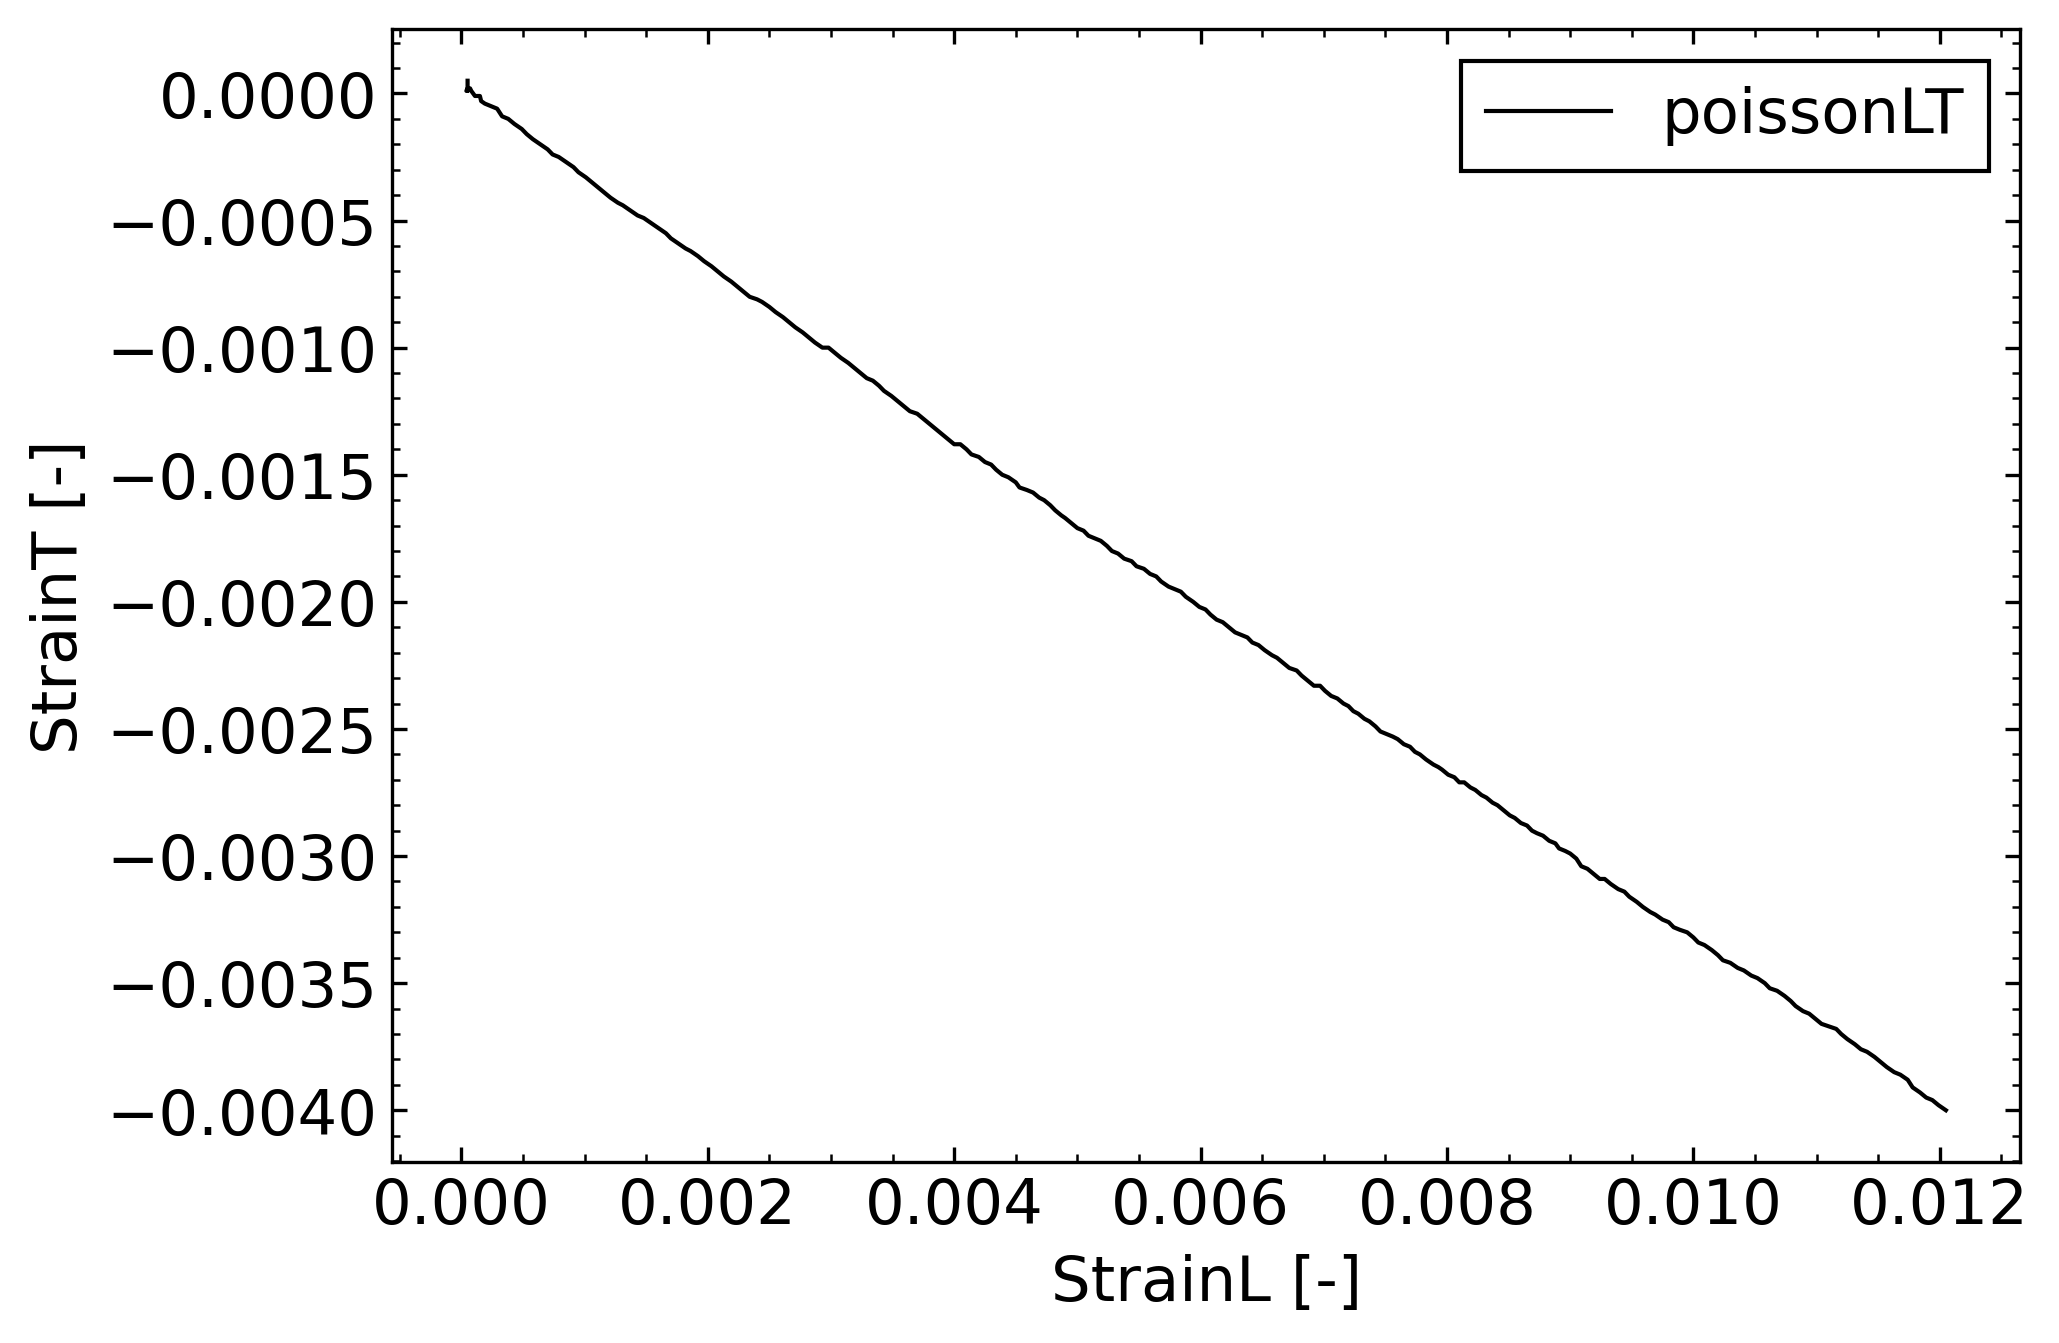

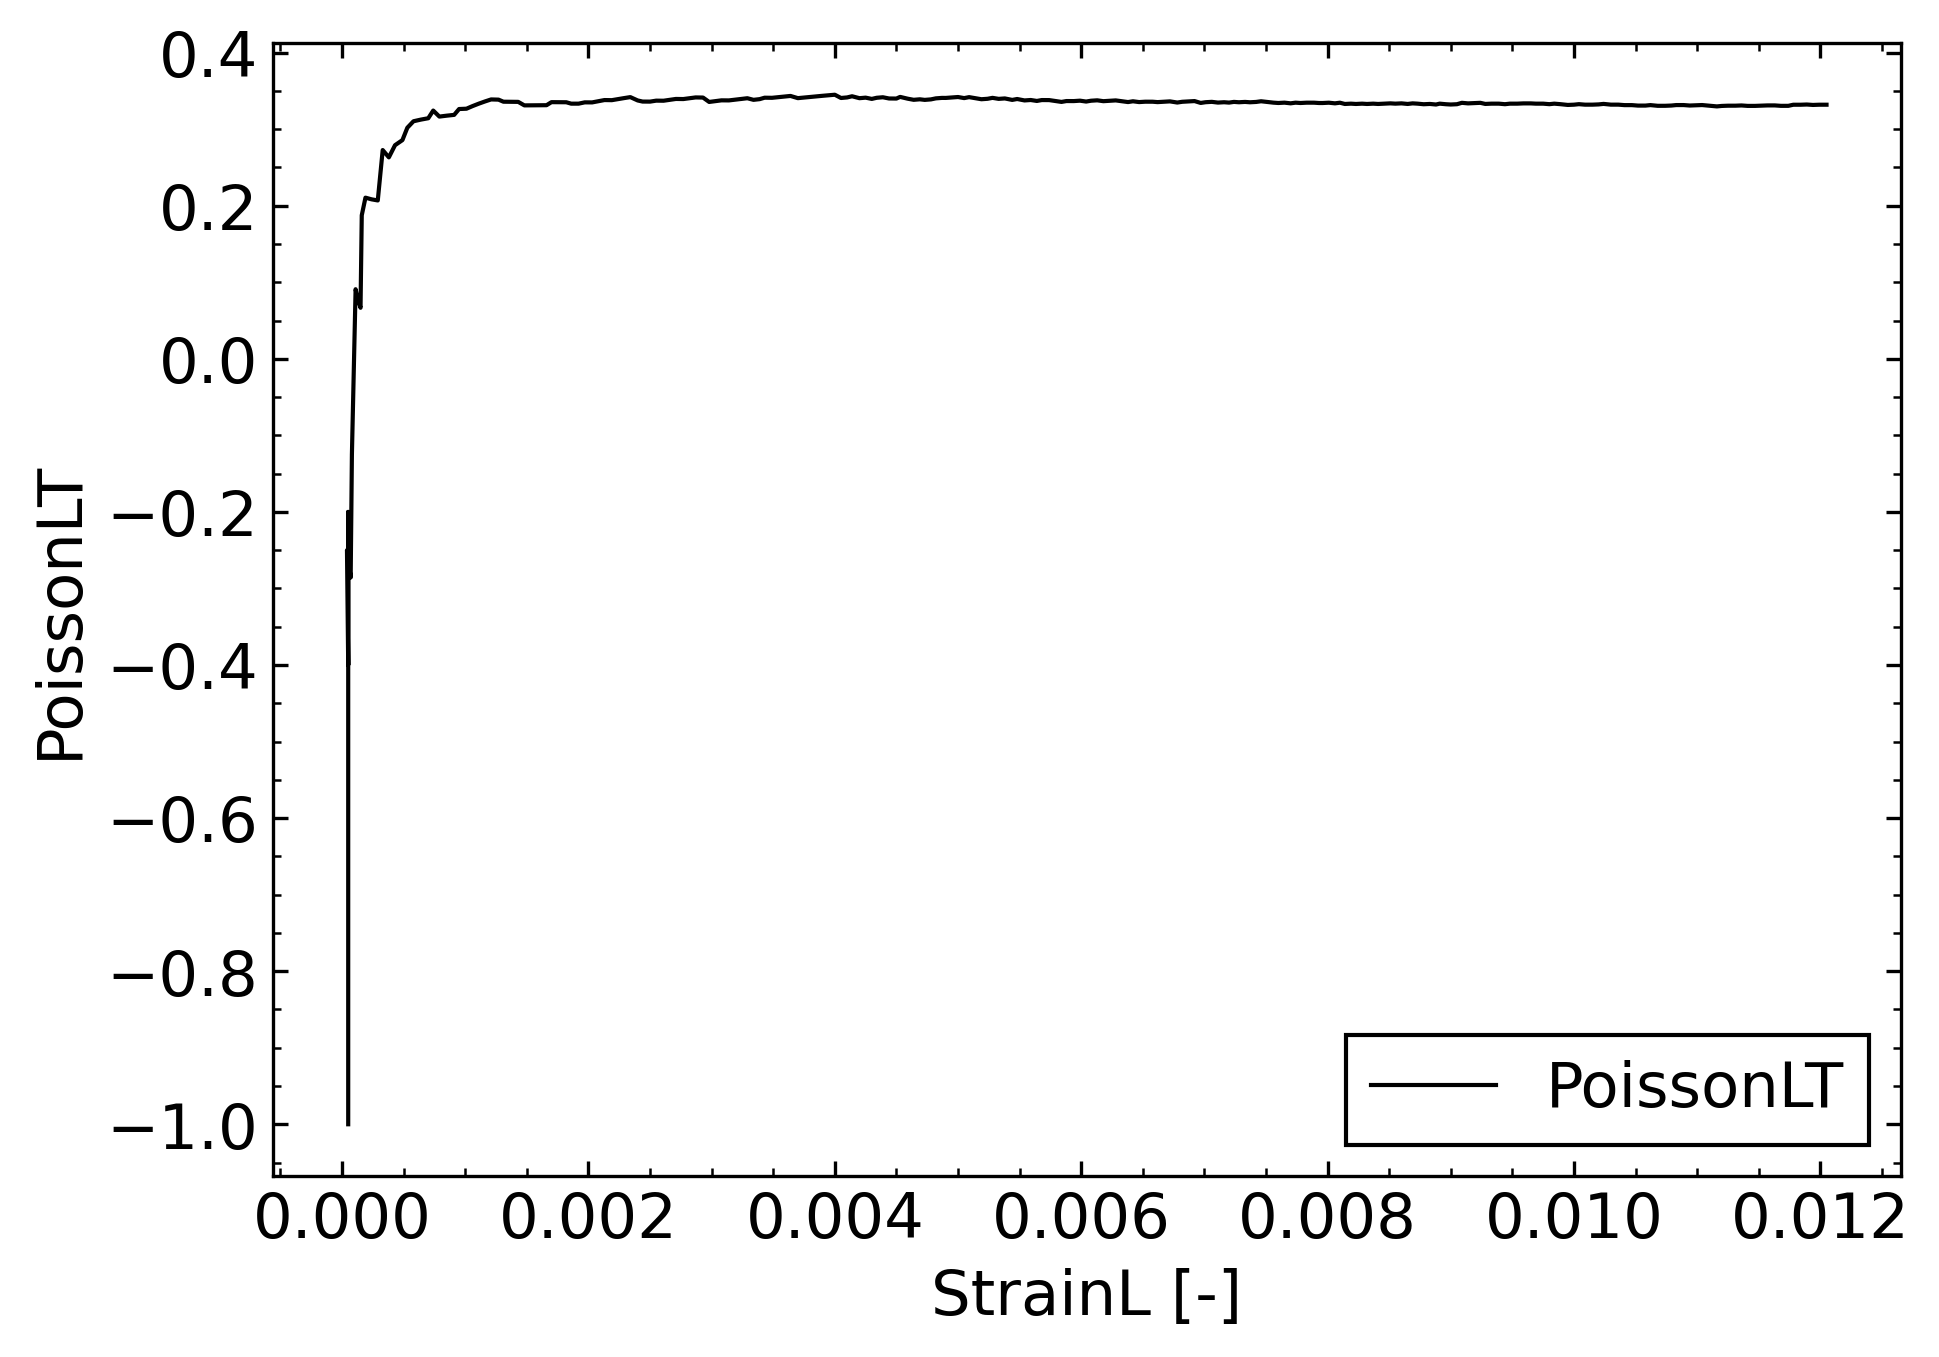

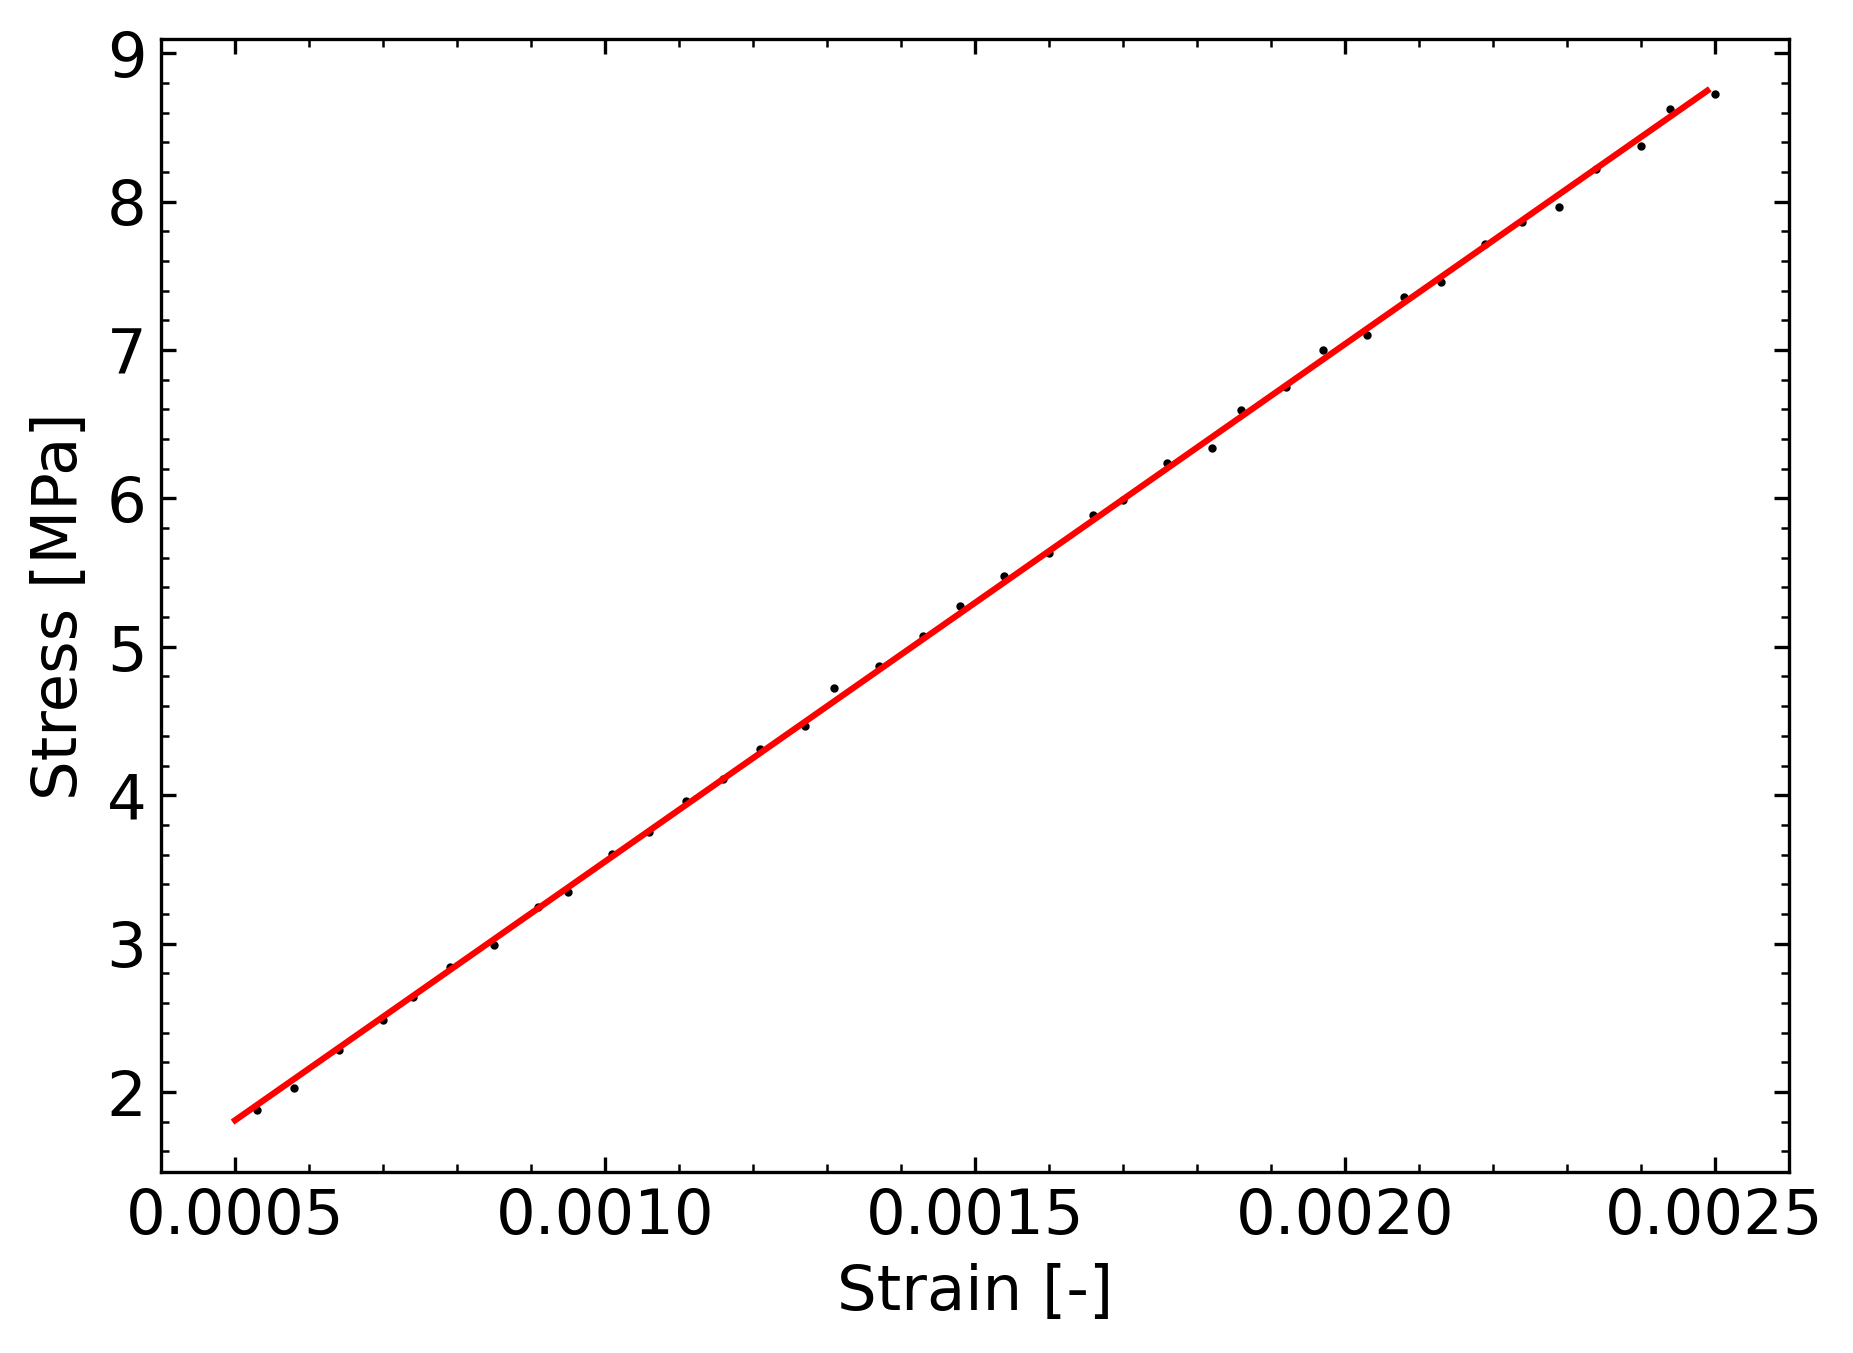

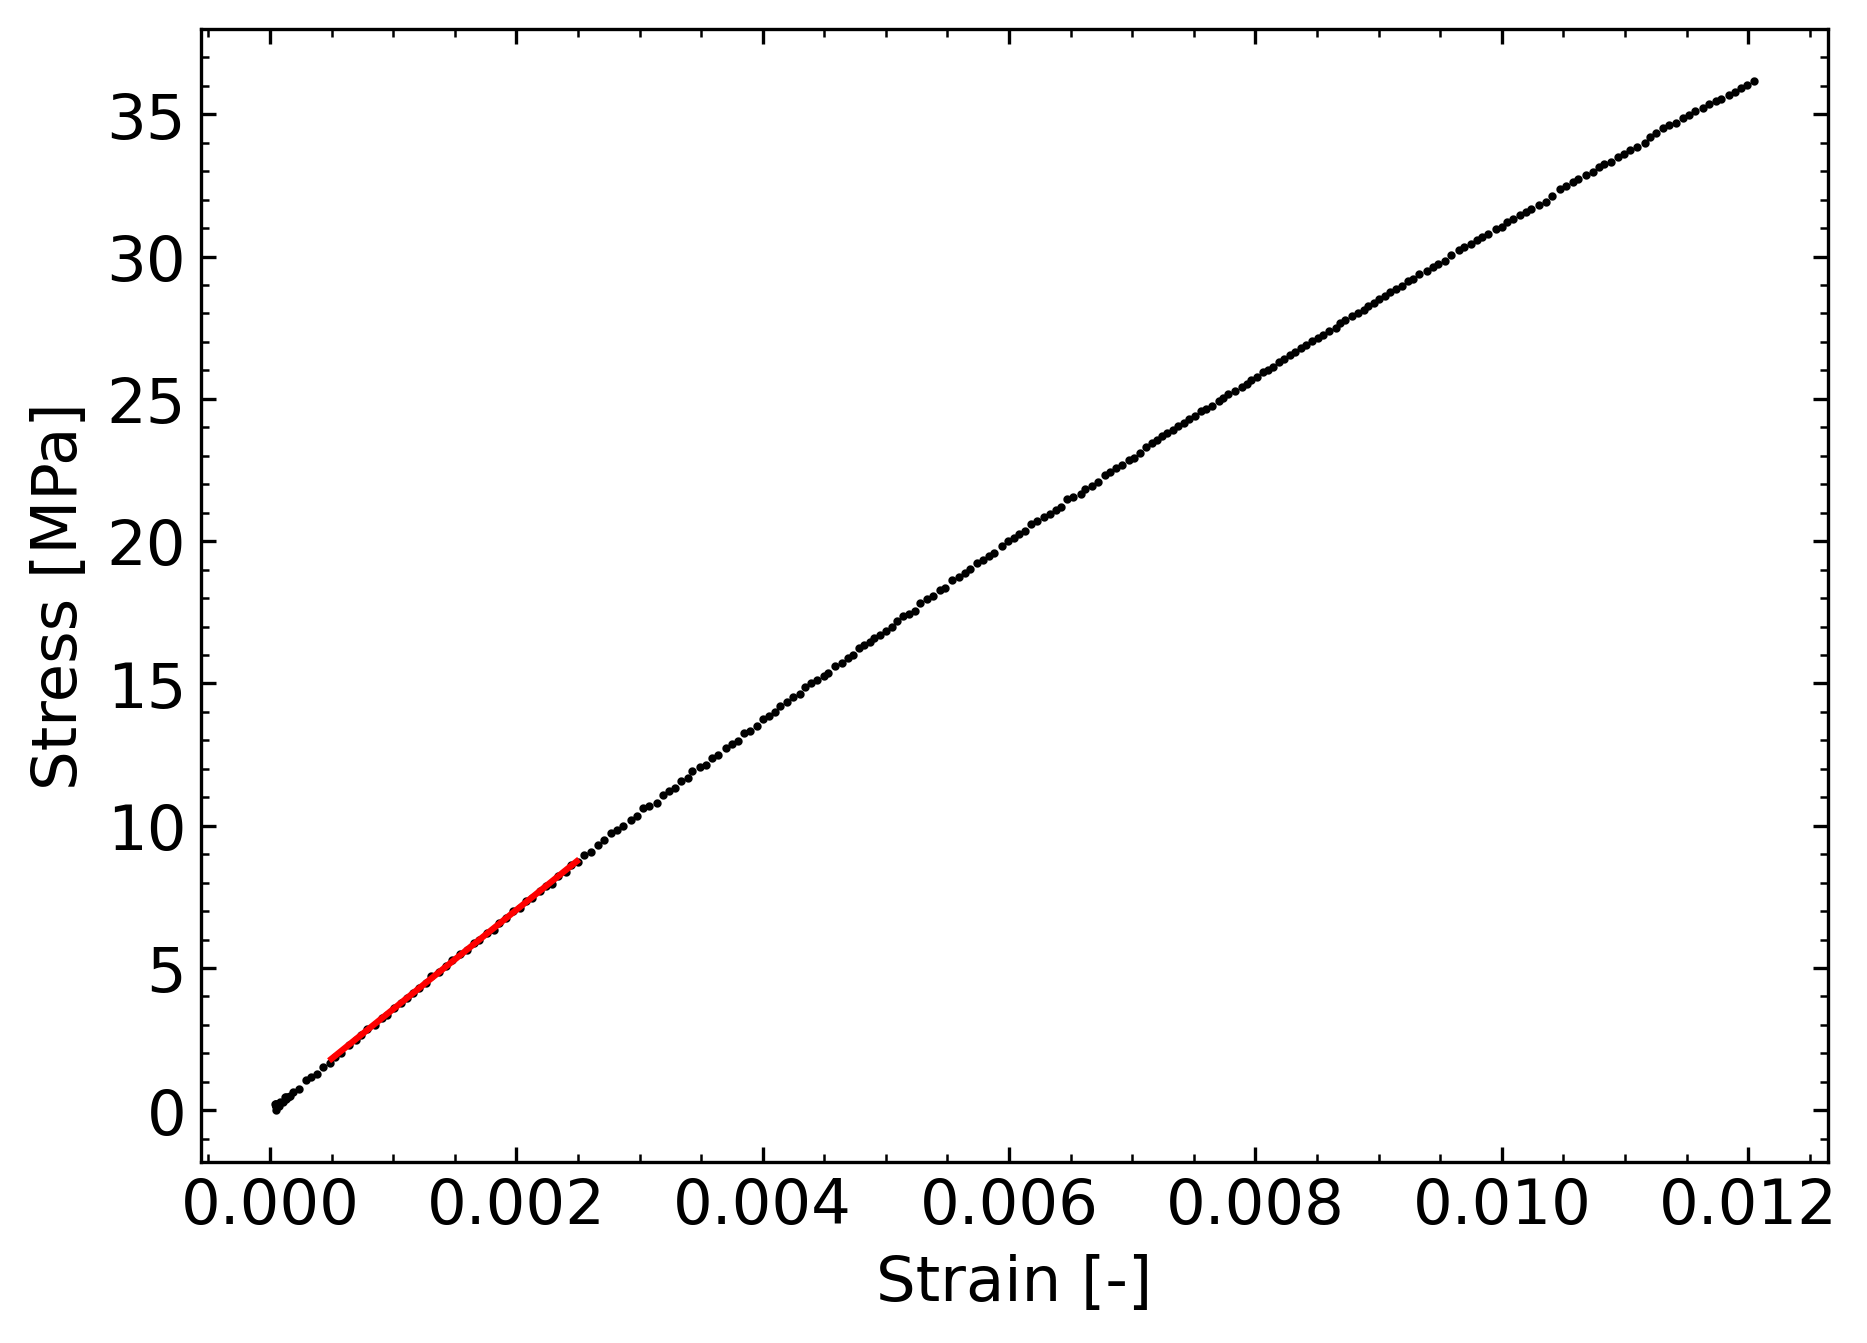

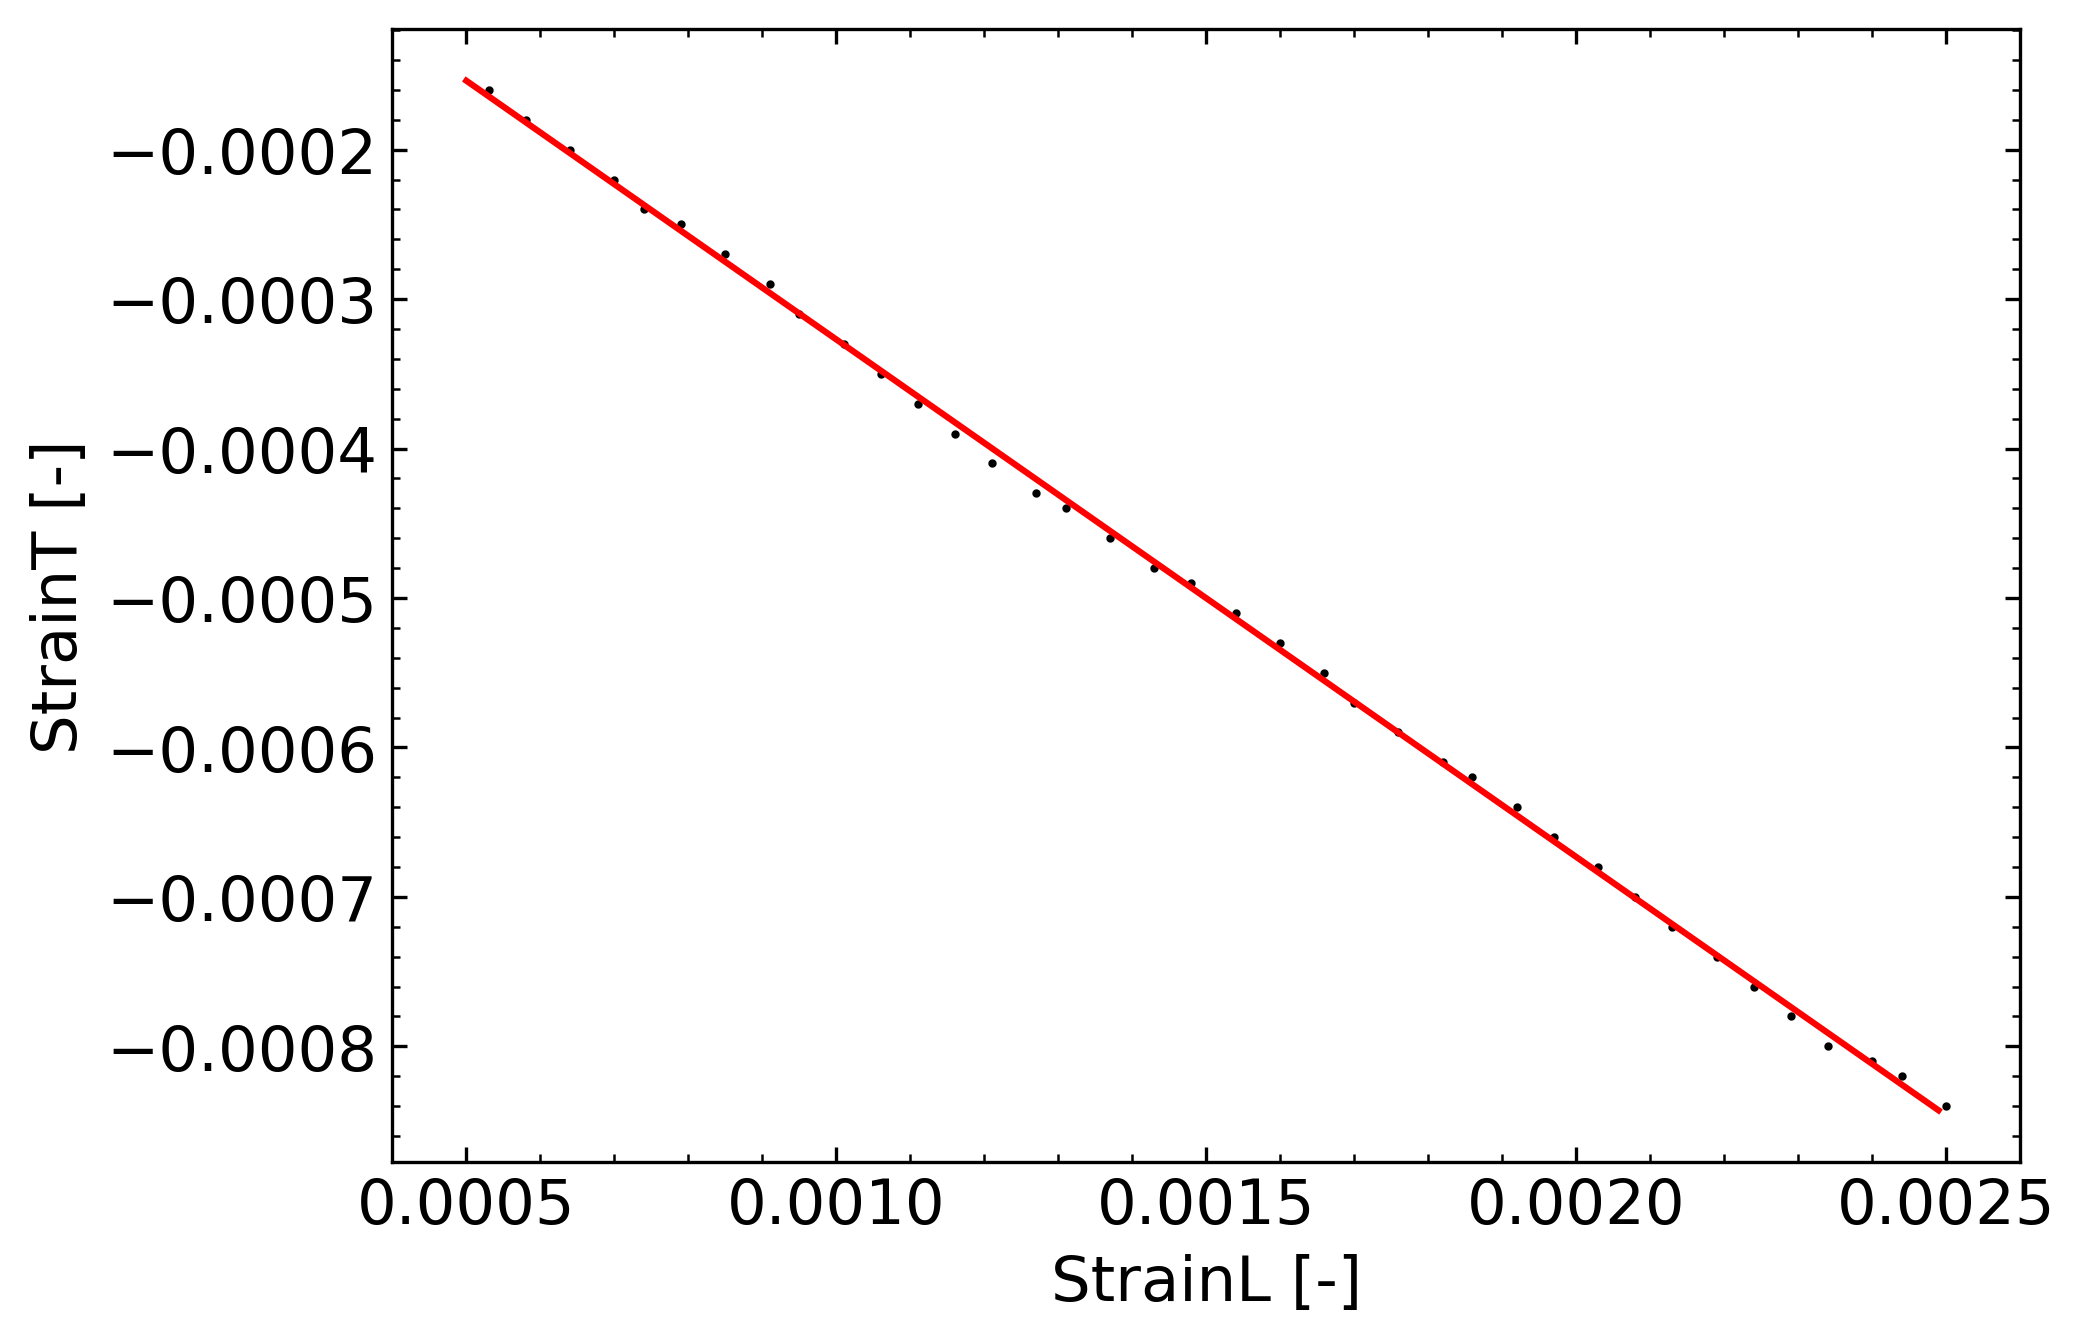

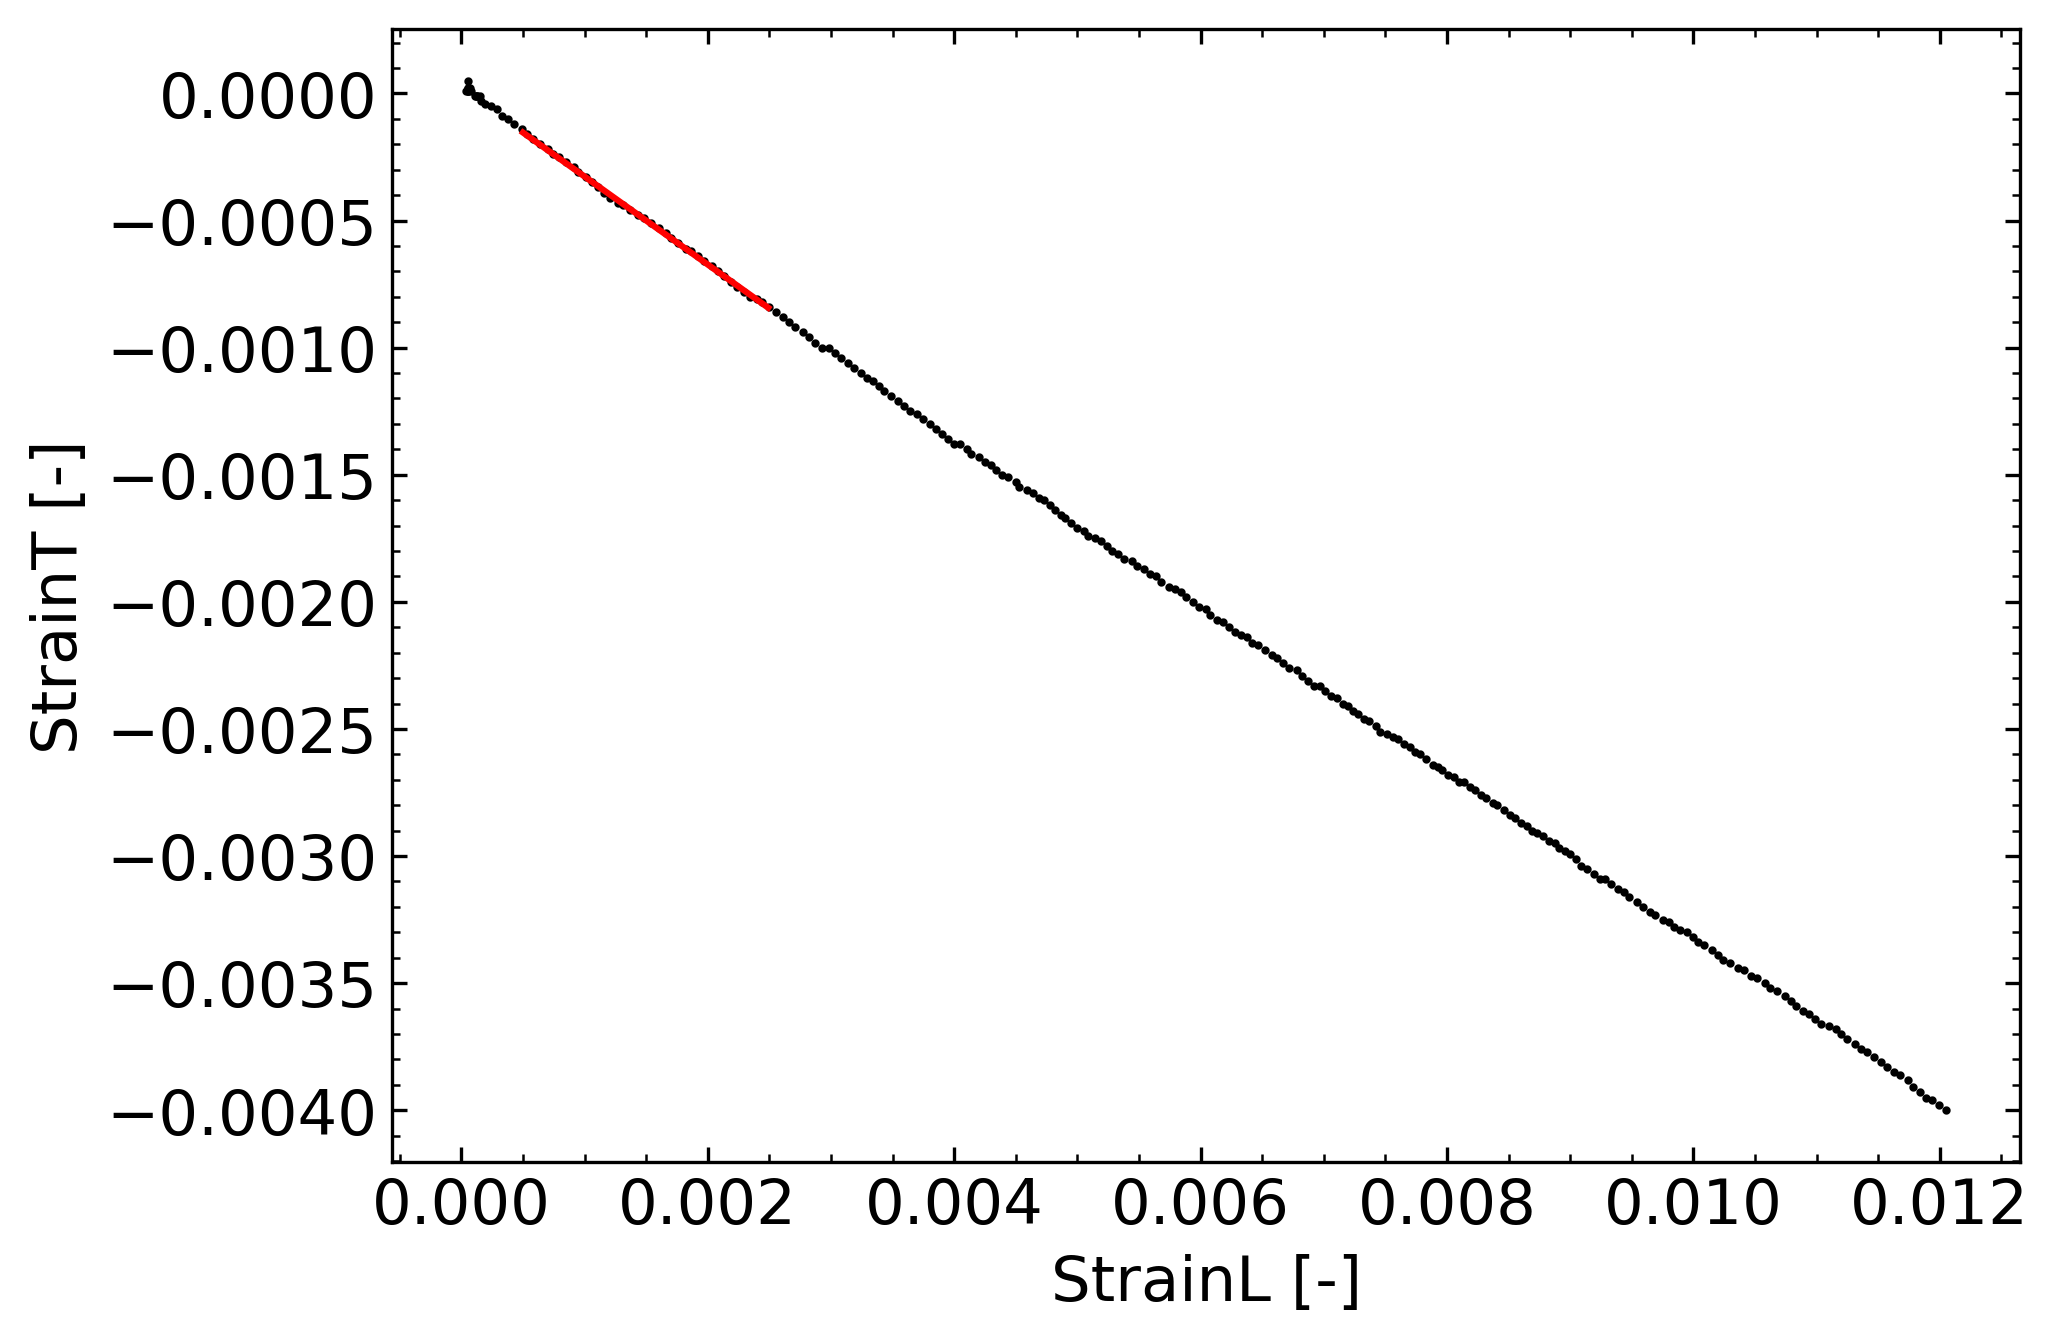

In [ ]:
Test2=TestObject('test_result2.csv')

widths2 = [15.02,15.04,15.03,14.99,14.99,14.99,15.01,14.99,14.99] 
thicknesses2 = [1.33,1.33,1.33,1.31,1.31,1.31,1.30,1.30,1.30]

Test2.set_specimen(widths=widths2, thicknesses=thicknesses2)
Test2.set_test_condition(gauge_rate=2.1, Force_scale=50000/5, cross_head_scale=50/5)
Test2.do_set()

# グラフ作成

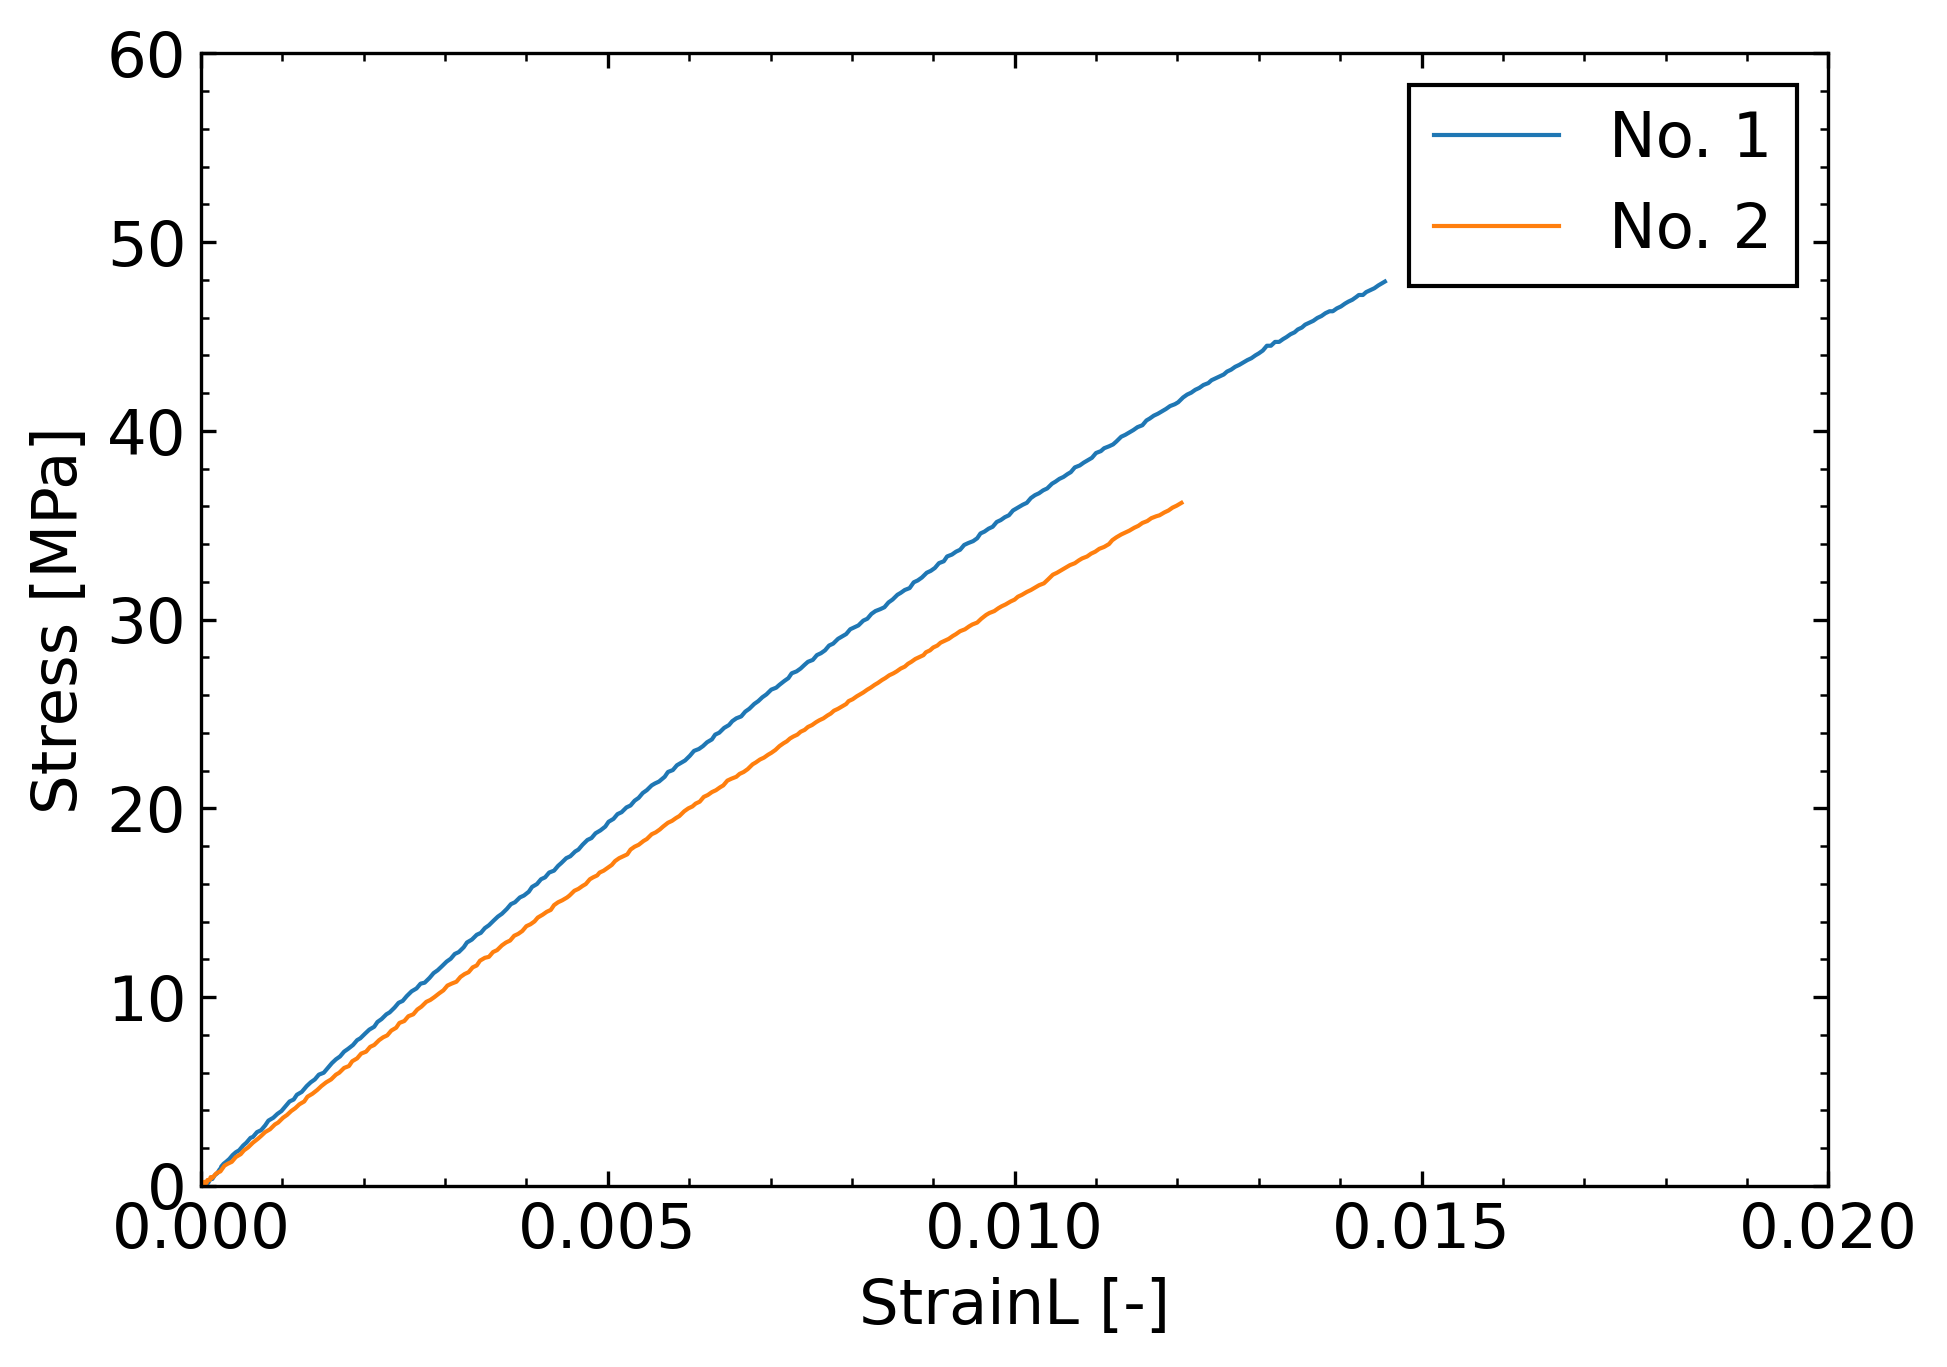

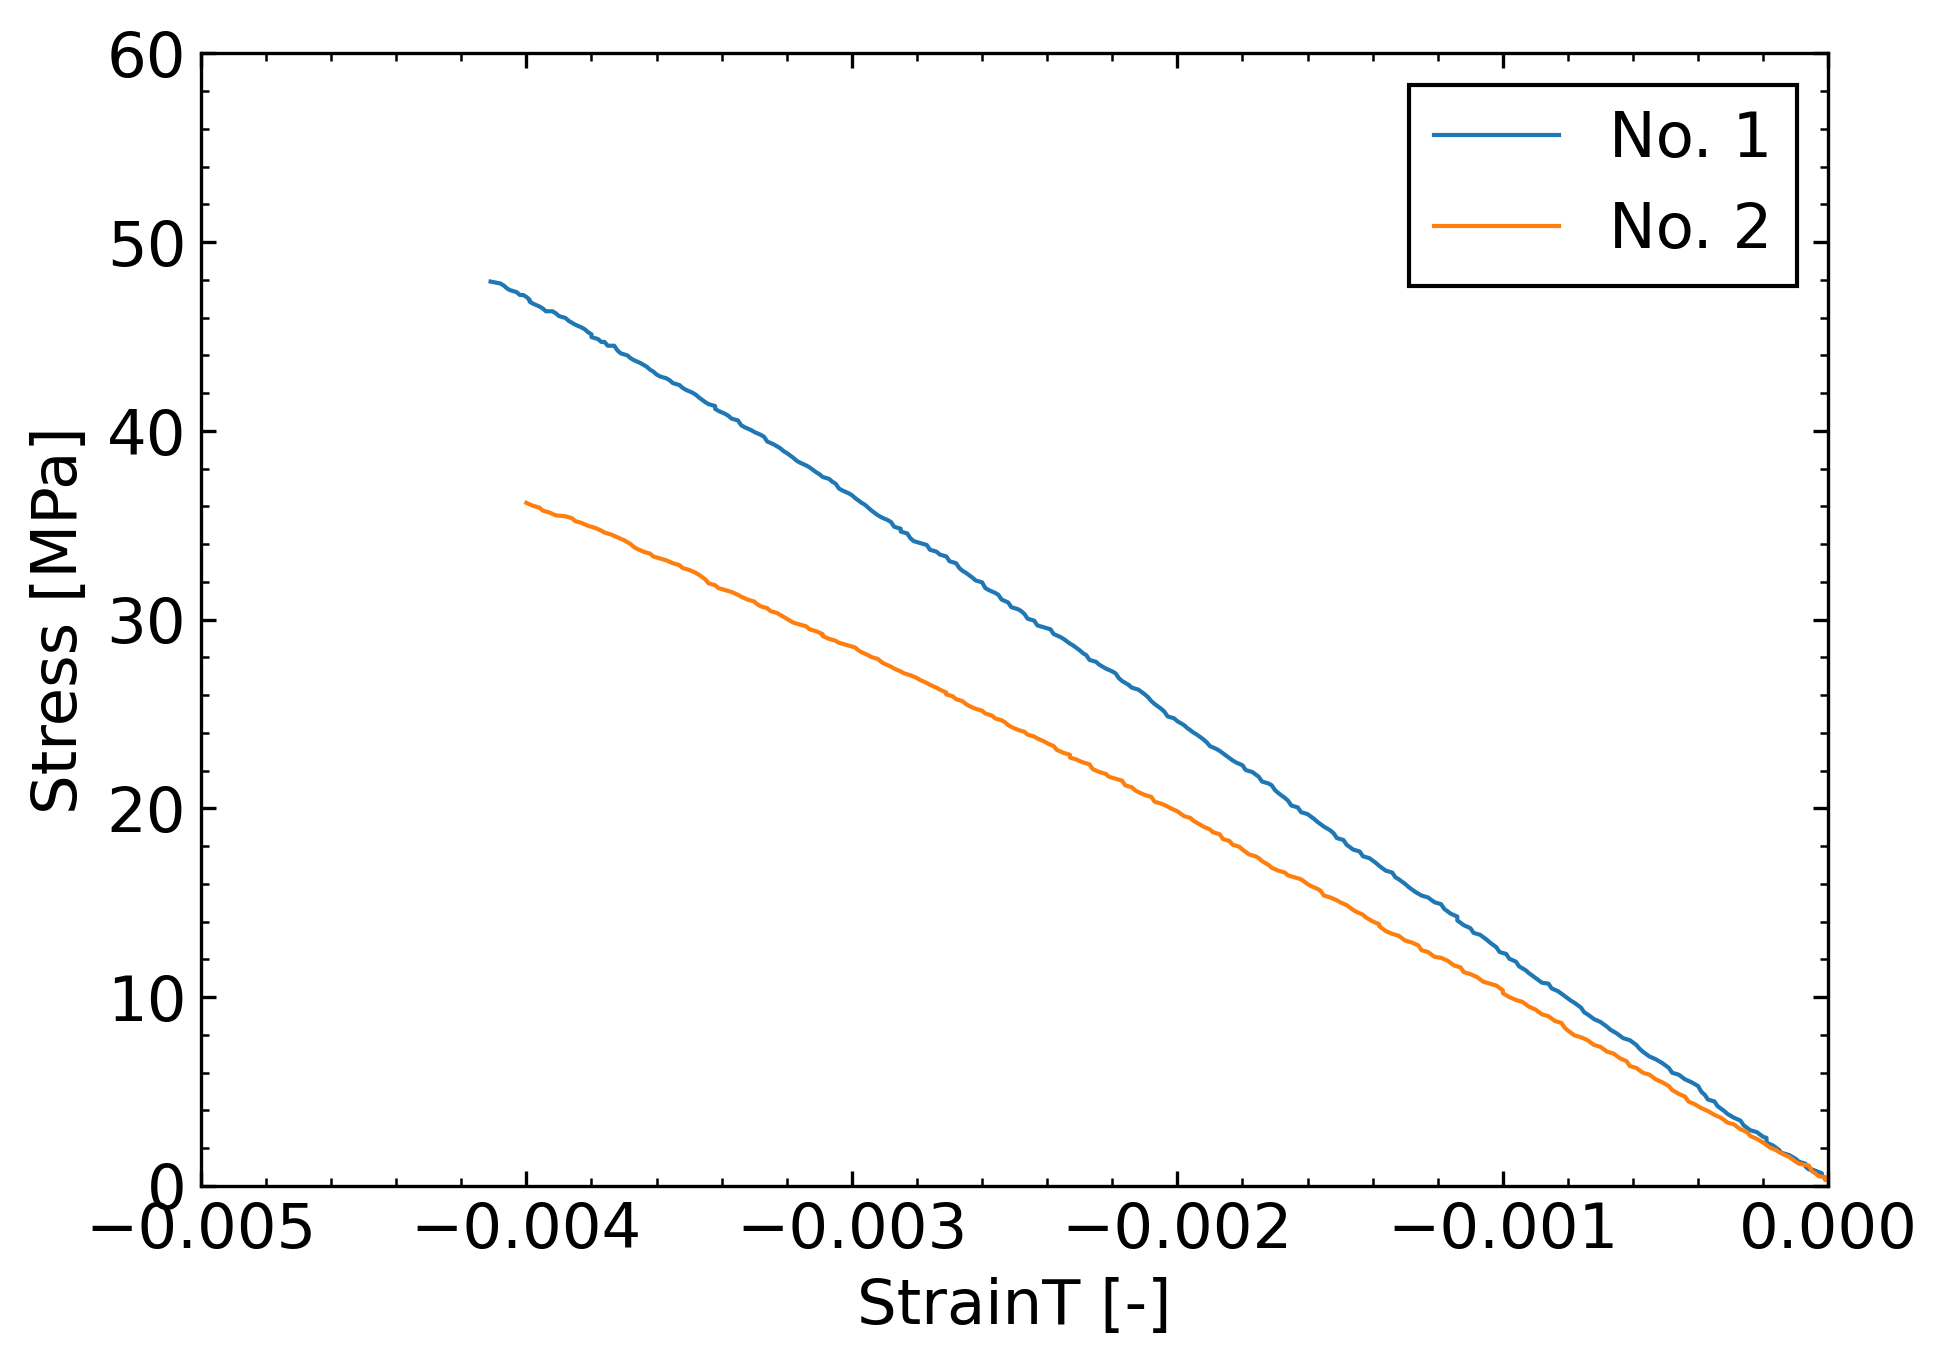

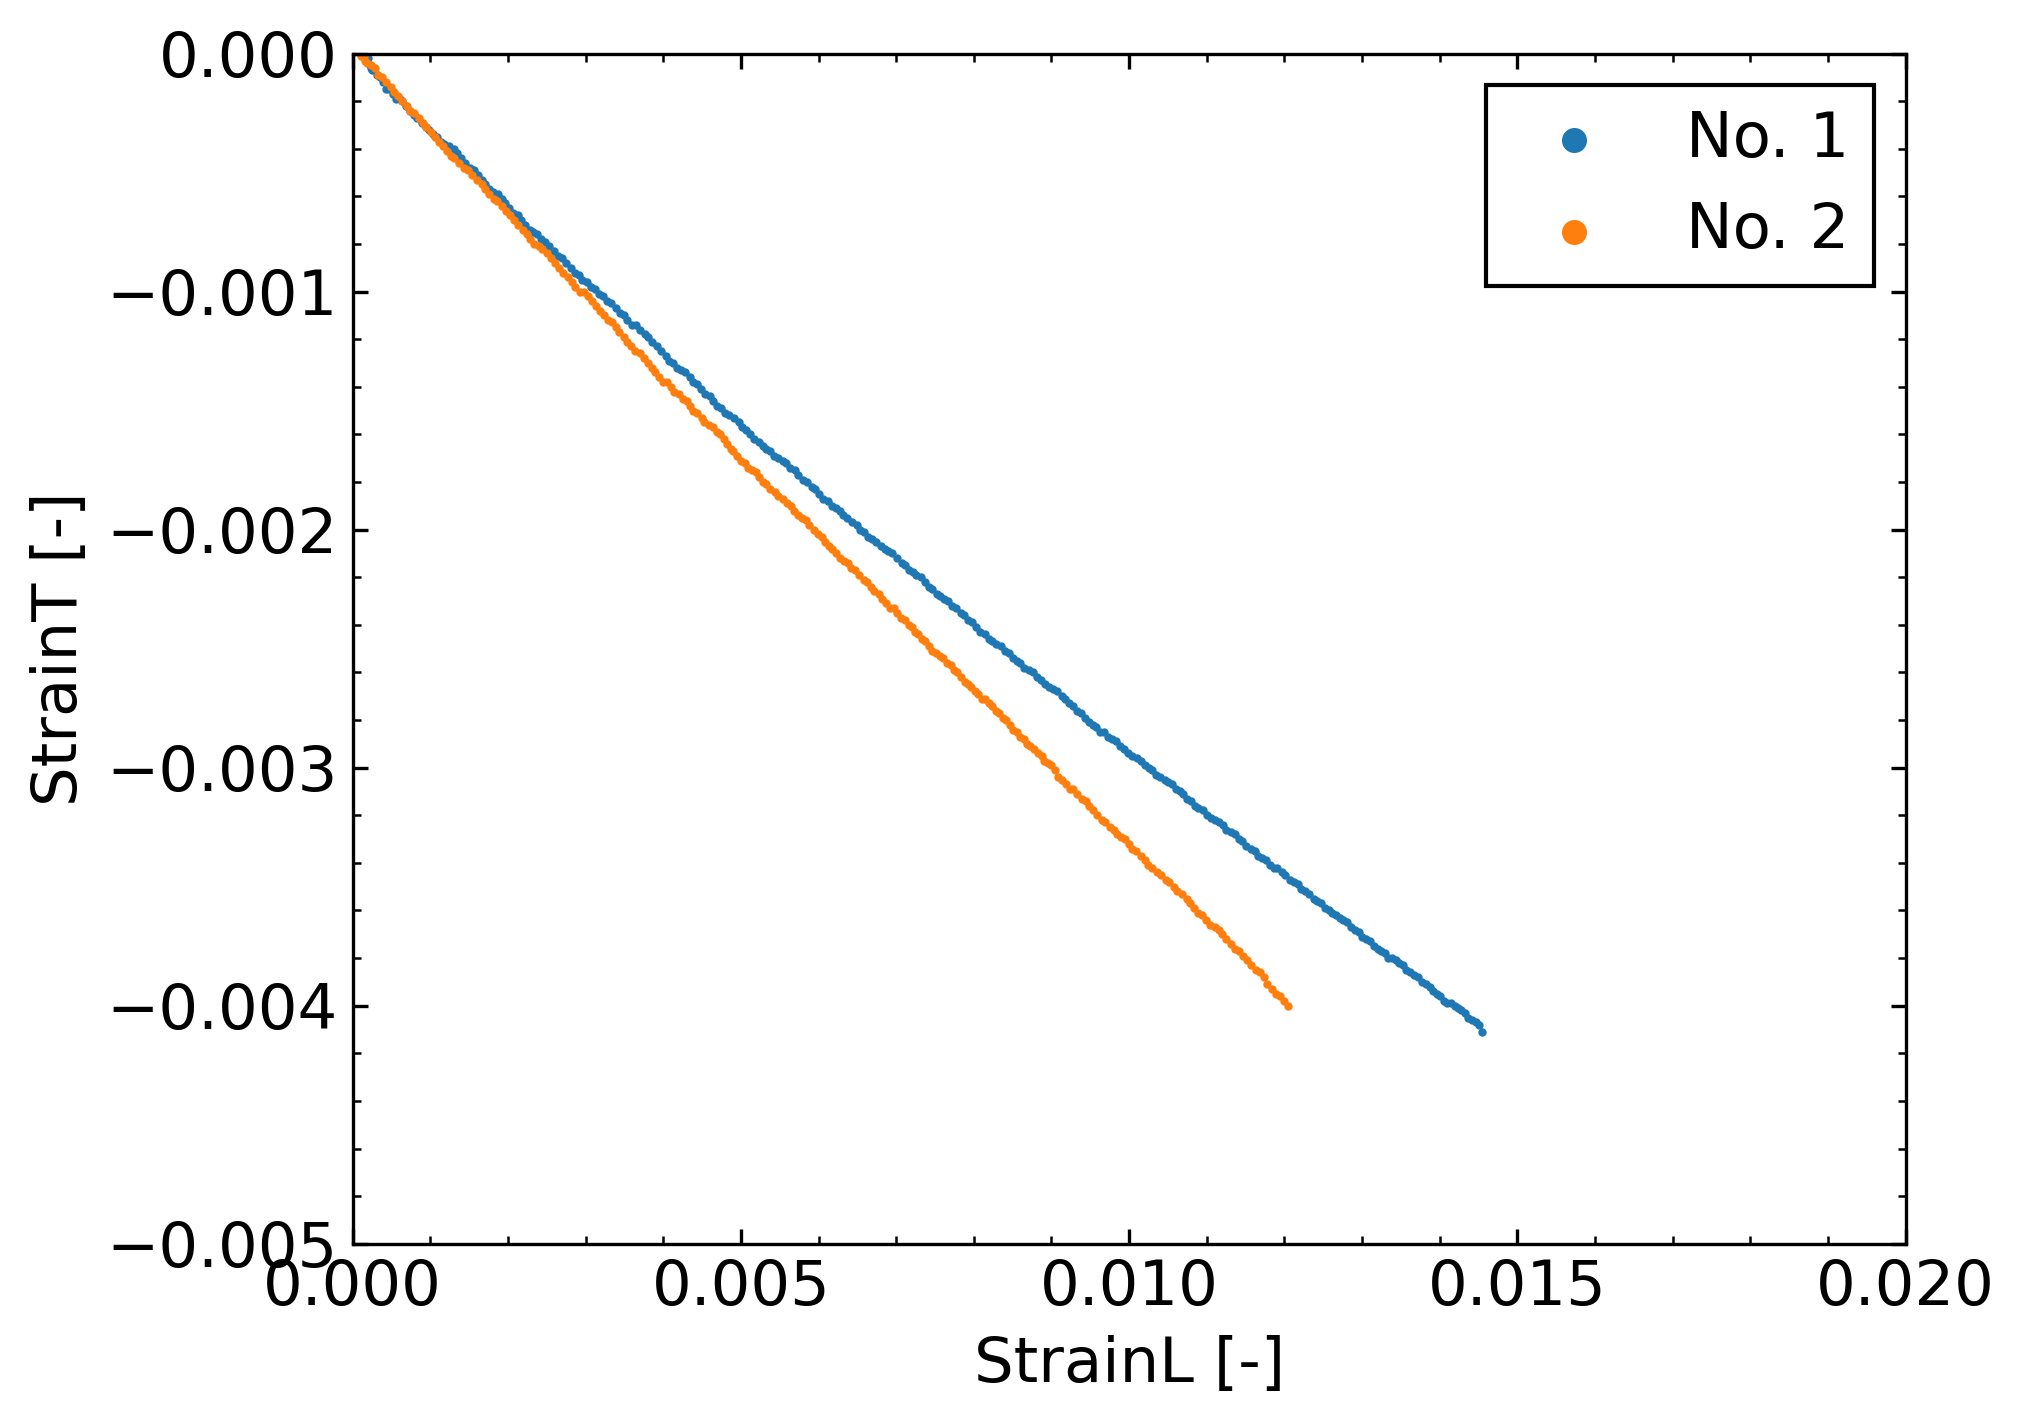

In [ ]:
#グラフ設定

#フォント設定
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
#plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 15 # 全体のフォントサイズが変更されます。
#plt.rcParams['xtick.labelsize'] = 9 # 軸だけ変更されます。
#plt.rcParams['ytick.labelsize'] = 24 # 軸だけ変更されます



#軸設定
plt.rcParams['xtick.direction'] = 'in' # x axis in
plt.rcParams['ytick.direction'] = 'in' # y axis in 
#plt.rcParams['axes.grid'] = True # make grid
#plt.rcParams['grid.linestyle']='--' #グリッドの線種
plt.rcParams["xtick.minor.visible"] = True  #x軸補助目盛りの追加
plt.rcParams["ytick.minor.visible"] = True  #y軸補助目盛りの追加
plt.rcParams['xtick.top'] = True                   #x軸の上部目盛り
plt.rcParams['ytick.right'] = True                 #y軸の右部目盛り



#軸大きさ
#plt.rcParams["xtick.major.width"] = 1.0             #x軸主目盛り線の線幅
#plt.rcParams["ytick.major.width"] = 1.0             #y軸主目盛り線の線幅
#plt.rcParams["xtick.minor.width"] = 1.0             #x軸補助目盛り線の線幅
#plt.rcParams["ytick.minor.width"] = 1.0             #y軸補助目盛り線の線幅
#plt.rcParams["xtick.major.size"] = 10               #x軸主目盛り線の長さ
#plt.rcParams["ytick.major.size"] = 10               #y軸主目盛り線の長さ
#plt.rcParams["xtick.minor.size"] = 5                #x軸補助目盛り線の長さ
#plt.rcParams["ytick.minor.size"] = 5                #y軸補助目盛り線の長さ
#plt.rcParams["axes.linewidth"] = 1.0                #囲みの太さ




#凡例設定
plt.rcParams["legend.fancybox"] = False  # 丸角OFF
plt.rcParams["legend.framealpha"] = 1  # 透明度の指定、0で塗りつぶしなし
plt.rcParams["legend.edgecolor"] = 'black'  # edgeの色を変更
plt.rcParams["legend.markerscale"] = 5 #markerサイズの倍率










#応力ひずみ線図 L方向

plt.figure(figsize=(7,5),dpi=300)
plt.plot(Test1.df["strainLave"],Test1.df["stress"], label="No. 1",lw=1)
plt.plot(Test2.df["strainLave"],Test2.df["stress"], label="No. 2",lw=1)
plt.xlabel("StrainL [-]")
plt.ylabel("Stress [MPa]")

#軸の範囲
plt.xlim(0,0.020)
plt.ylim(0, 60)

#軸の指定
plt.xticks(np.arange(0, 0.021, 0.005))
plt.yticks(np.arange(0, 61, 10))

plt.legend()
plt.savefig("引張L.png", format="png", dpi=300,transparent=True)
plt.show()





#応力ひずみ線図 T方向

plt.figure(figsize=(7,5),dpi=300)
plt.plot(Test1.df["strainTave"],Test1.df["stress"], label="No. 1",lw=1)
plt.plot(Test2.df["strainTave"],Test2.df["stress"], label="No. 2",lw=1)
plt.xlabel("StrainT [-]")
plt.ylabel("Stress [MPa]")

#軸の範囲
plt.xlim(-0.005,0)
plt.ylim(0, 60)

#軸の指定
#plt.xticks(np.arange(0, 0.016, 0.005))
plt.yticks(np.arange(0, 61, 10))

plt.legend()
plt.savefig("引張T.png", format="png", dpi=300,transparent=True)
plt.show()





#ポワソン比

plt.figure(figsize=(7,5),dpi=300)
plt.scatter(Test1.df["strainLave"],Test1.df["strainTave"], label="No. 1",s=1)
plt.scatter(Test2.df["strainLave"],Test2.df["strainTave"], label="No. 2",s=1)

plt.xlabel("StrainL [-]")
plt.ylabel("StrainT [-]")

#軸の範囲
plt.xlim(0,0.020)
plt.ylim(-0.005,0)

#軸の指定
plt.xticks(np.arange(0, 0.021, 0.005))
plt.yticks(np.arange(-0.005, 0.001, 0.001))
plt.legend()

#見切れるから対策
plt.tight_layout()
plt.savefig("引張P.png", format="png",transparent=True)
plt.show()